In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import copy
from skimage import io, transform
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cpu')

In [3]:
dataset_train = pd.read_csv("data/train.csv")
dataset_validation = pd.read_csv("data/val.csv")

In [4]:
class AsetheticsDataset(Dataset):
    '''asethitics dataset'''

    def __init__(self, dataframe, root_dir, transform=None):
        """
            Args:
                csv_file (string): Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(image_name)
        mem_val = self.data.iloc[idx, 1]
        return_sample = {
            'image': image,
            'memorability_score': mem_val
        }
        if self.transform:
            return_sample = self.transform(return_sample)

        return return_sample

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mem_val = sample['image'], sample["memorability_score"]
        h, w = image.shape[:2]

        img = transform.resize(image, (self.output_size, self.output_size, 3))
        return {'image': img, 'memorability_score': mem_val}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mem_val = sample['image'], sample['memorability_score']
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        normalized = (image - self.mean) / self.std
        return {
            "image": normalized,
            "memorability_score": mem_val
        }


transformed_dataset_train = AsetheticsDataset(dataset_train, root_dir="images",
                                              transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                            ]))

transformed_dataset_val = AsetheticsDataset(dataset_validation, root_dir="images",
                                            transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                          ]))

train_dataloader = DataLoader(
    transformed_dataset_train, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(
    transformed_dataset_val, batch_size=32, shuffle=True)
dataloaders = {
    "train": train_dataloader,
    "val": validation_dataloader
}
dataset_sizes = {
    "train": len(dataset_train),
    "val": len(dataset_validation)
}

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history = []
    orignal_model = None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):

                inputs = batched_data["image"]
                inputs = inputs.to(device)
                labels = batched_data["memorability_score"]
                labels = labels.view(-1, 1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ", loss.item())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                running_loss_history.append(epoch_loss)
            else:
                val_running_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < low_loss:
                print("saving best model......")
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "models/vresnet50_scratch_weights.pt")
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    original_model = copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model, original_model, running_loss_history, val_running_loss_history

In [6]:
# idenetity block
class IdentityBlock(nn.Module):
    def __init__(self, f, in_channels, filters):
        super(IdentityBlock, self).__init__()
        '''
        Args:
        
        f -- integer specifying the shape of window
        in_channels : number of channels of input to this identity block
        filters - list of integers (len=3 ) count of feature maps to be produced
        
        Returns 
        X -- output of the identity block,tensor of shape (n_H,n_W,n_C)
        '''
        self.in_channels = in_channels
        self.kernel_size = f
        self.F1 = filters[0]
        self.F2 = filters[1]
        self.F3 = filters[2]
        # first component
        self.conv1 = self.conv_layer(
            in_channels=self.in_channels, out_channels=self.F1, kernel_size=(1, 1), padding=0)
        self.bn1 = nn.BatchNorm2d(self.F1)
        # second component
        self.conv2 = self.conv_layer(in_channels=self.F1, out_channels=self.F2, kernel_size=(
            self.kernel_size, self.kernel_size), padding="same")
        self.bn2 = nn.BatchNorm2d(self.F2)
        # third component
        self.conv3 = self.conv_layer(
            in_channels=self.F2, out_channels=self.F3, kernel_size=(1, 1), padding=0)
        self.bn3 = nn.BatchNorm2d(self.F3)

    def conv_layer(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        '''
        Args:
           in_channels : the number of input channel from the  input tensor
           out_channels : the number of output channels of the feature map 
           kernel_size  : filter size 
           padding      : that takes two values [same ,0]"[default : 0]
           stride       : the stride length [default is zero]

        Output:
            convolution layer
        '''
        if padding == "same":
            padding = int((kernel_size[0]-1)/2)
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = x + x_shortcut
        x = F.relu(x)

        return x

In [7]:
# convolutional block
class ConvolutionalBlock(nn.Module):
    '''
    Args:
    f           : the size of filter that will be used in the intermediate layers of this convolutional block
    in_channels : the number of input channels from the input tensor
    filters      :  list of integers (len=3 ) count of feature maps to be produced
    stride      : the length of stride
    '''

    def __init__(self, f, in_channels, filters, stride=2):
        super(ConvolutionalBlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = f
        self.F1 = filters[0]
        self.F2 = filters[1]
        self.F3 = filters[2]
        self.stride = stride
        # first component
        self.conv1 = self.conv_layer(
            self.in_channels, self.F1, (1, 1), padding=0, stride=self.stride)
        self.bn1 = nn.BatchNorm2d(self.F1)

        # second component
        self.conv2 = self.conv_layer(self.F1, self.F2, (f, f), padding="same")
        self.bn2 = nn.BatchNorm2d(self.F2)

        # third componenet
        self.conv3 = self.conv_layer(self.F2, self.F3, (1, 1))
        self.bn3 = nn.BatchNorm2d(self.F3)

        # shortcut component
        self.sconv = self.conv_layer(
            self.in_channels, self.F3, (1, 1), padding=0, stride=self.stride)
        self.sbn = nn.BatchNorm2d(self.F3)

    def forward(self, x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_shortcut = self.sconv(x_shortcut)
        x_shortcut = self.sbn(x_shortcut)
        x = x+x_shortcut
        x = F.relu(x)
        return x

    def conv_layer(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        '''
        Args:
           in_channels : the number of input channel from the  input tensor
           out_channels : the number of output channels of the feature map 
           kernel_size  : filter size 
           padding      : that takes two values [same ,0]"[default : 0]
           stride       : the stride length [default is zero]

        Output:
            Convolutional layer
        '''
        if padding == "same":
            padding = int((kernel_size[0]-1)/2)
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, stride)

In [8]:
class ResNet50(nn.Module):

    def __init__(self, in_channels, identity_block, convolutional_block):
        super(ResNet50, self).__init__()

        self.in_channels = in_channels
        self.convolutional_block = convolutional_block
        self.identity_block = identity_block

        # stage1
        self.stage1_conv = self.conv_layer(
            self.in_channels, 64, (7, 7), padding=0, stride=2)
        self.stage1_bn = nn.BatchNorm2d(64)
        self.stage1_maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # stage2
        self.stage2_convblock = self.convolutional_block(
            3, 64, [64, 64, 256], 1)
        self.stage2_identity_block1 = self.identity_block(
            3, 256, [64, 64, 256])
        # self.stage2_identity_block2 = self.identity_block(3,256,[64,64,256])

        # stage3
        self.stage3_convblock = self.convolutional_block(
            3, 256, [128, 128, 512])
        self.stage3_identity_block1 = self.identity_block(
            3, 512, [128, 128, 512])
        # self.stage3_identity_block2 = self.identity_block(3,512,[128,128,512])
        # self.stage3_identity_block3 = self.identity_block(3,512,[128,128,512])

        # #stage 4
        self.stage4_convblock = self.convolutional_block(
            3, 512, [128, 128, 1024])
        self.stage4_identity_block1 = self.identity_block(
            3, 1024, [128, 128, 1024])
        # self.stage4_identity_block2 = self.identity_block(3,1024,[128,128,1024])
        # self.stage4_identity_block3 = self.identity_block(3,1024,[128,128,1024])
        # self.stage4_identity_block4 = self.identity_block(3,1024,[128,128,1024])
        # self.stage4_identity_block5 = self.identity_block(3,1024,[128,128,1024])

        # #stage5
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, 1)

    def forward(self, x):
        # stage1
        x = self.stage1_conv(x)
        x = self.stage1_bn(x)
        x = F.relu(x)
        x = self.stage1_maxpool(x)

        # stage2
        x = self.stage2_convblock(x)
        x = self.stage2_identity_block1(x)
        # x = self.stage2_identity_block2(x)

        # stage3
        x = self.stage3_convblock(x)
        x = self.stage3_identity_block1(x)
        # x = self.stage3_identity_block2(x)
        # x = self.stage3_identity_block3(x)

        # #stage4
        x = self.stage4_convblock(x)
        x = self.stage4_identity_block1(x)
        # x = self.stage4_identity_block2(x)
        # x = self.stage4_identity_block3(x)
        # x = self.stage4_identity_block4(x)
        # x = self.stage4_identity_block5(x)

        # #stage5
        # x = self.stage5_convblock(x)
        # x = self.stage5_identity_block1(x)
        # x = self.stage5_identity_block2(x)

        # pooling
        x = self.gap(x)
        print(x.shape)
        x = x.squeeze()
        if len(x.shape) == 1:
            print("single element")
            x = x.unsqueeze(0)

        # fully connected
        x = self.fc(x)
        print(x.shape)

    def conv_layer(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        if padding == "same":
            padding = int((kernel_size[0]-1)/2)
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

In [9]:
class VRNet(nn.Module):

    def __init__(self, in_channels, identity_block, convolutional_block):
        super(VRNet, self).__init__()

        self.in_channels = in_channels
        self.convolutional_block = convolutional_block
        self.identity_block = identity_block

        # stage1
        self.stage1_conv = self.conv_layer(
            self.in_channels, 64, (7, 7), padding=0, stride=2)
        self.stage1_bn = nn.BatchNorm2d(64)
        self.stage1_maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        self.stage1_interconv3x3 = self.conv_layer(
            64, 64, (3, 3), padding=0, stride=2)
        self.stage1_interpool = nn.AdaptiveAvgPool2d(64)
        self.stage1_intercon1x1 = self.conv_layer(
            64, 32, (1, 1), padding=0, stride=2)

        # stage2
        self.stage2_convblock = self.convolutional_block(
            3, 64, [64, 64, 256], 1)
        self.stage2_identity_block1 = self.identity_block(
            3, 256, [64, 64, 256])
        self.stage2_identity_block2 = self.identity_block(
            3, 256, [64, 64, 256])

        self.stage2_interconv3x3 = self.conv_layer(
            256, 64, (3, 3), padding=0, stride=2)
        self.stage2_interpool = nn.AdaptiveAvgPool2d(64)
        self.stage2_intercon1x1 = self.conv_layer(
            64, 32, (1, 1), padding=0, stride=2)

        # stage3
        self.stage3_convblock = self.convolutional_block(
            3, 256, [128, 128, 512])
        self.stage3_identity_block1 = self.identity_block(
            3, 512, [128, 128, 512])
        self.stage3_identity_block2 = self.identity_block(
            3, 512, [128, 128, 512])
        # self.stage3_identity_block3 = self.identity_block(3,512,[128,128,512])

        self.stage3_interconv3x3 = self.conv_layer(
            512, 128, (3, 3), padding=0, stride=2)
        self.stage3_interpool = nn.AdaptiveAvgPool2d(64)
        self.stage3_intercon1x1 = self.conv_layer(
            128, 64, (1, 1), padding=0, stride=2)

        # #stage 4
        # empty

        # final conv
        self.final_conv1x1 = self.conv_layer(
            (32+32+64), 64, (1, 1), padding=0, stride=2)
        self.final_conv3x3 = self.conv_layer(
            64, 128, (3, 3), padding=0, stride=2)
        self.final_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # stage1
        x = self.stage1_conv(x)
        x = self.stage1_bn(x)
        x = F.relu(x)
        x = self.stage1_maxpool(x)
        stage1_inter = x
        # stage1 inter
        stage1_inter = self.stage1_interconv3x3(stage1_inter)
        stage1_inter = self.stage1_interpool(stage1_inter)
        stage1_inter = self.stage1_intercon1x1(stage1_inter)

        # stage2
        x = self.stage2_convblock(x)
        x = self.stage2_identity_block1(x)
        x = self.stage2_identity_block2(x)
        stage2_inter = x
        stage2_inter = self.stage2_interconv3x3(stage2_inter)
        stage2_inter = self.stage2_interpool(stage2_inter)
        stage2_inter = self.stage2_intercon1x1(stage2_inter)

        # stage3
        x = self.stage3_convblock(x)
        x = self.stage3_identity_block1(x)
        x = self.stage3_identity_block2(x)
        # x = self.stage3_identity_block3(x)
        # stage3 inter
        # stage3_inter = x
        x = self.stage3_interconv3x3(x)
        x = self.stage3_interpool(x)
        x = self.stage3_intercon1x1(x)

        # #stage4
        # empty

        # #stage5
        # empty

        # concatenate all feature maps
        concatenated_maps = torch.cat((stage1_inter, stage2_inter, x), 1)
        # final stage
        concatenad_maps = self.final_conv1x1(concatenated_maps)
        concatenad_maps = self.final_conv3x3(concatenad_maps)
        concatenad_maps = self.final_pool(concatenad_maps)
        concatenad_maps = concatenad_maps.squeeze()
        if len(concatenad_maps.shape) == 1:
            concatenad_maps = concatenad_maps.unsqueeze(0)

        output = self.fc(concatenad_maps)
        return output

    def conv_layer(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        if padding == "same":
            padding = int((kernel_size[0]-1)/2)
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

In [10]:
resnet = VRNet(3, IdentityBlock, ConvolutionalBlock).to(device).double()

In [11]:
x = torch.rand([32, 3, 22, 22]).to(device).double()

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
epchocs_count = 100

In [14]:
best_model, model, running_loss_history, val_running_loss_history = train_model(
    resnet, criterion, optimizer, exp_lr_scheduler, epchocs_count)

Epoch 0/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.2961658314610905


  4%|███                                                                                 | 1/27 [00:04<02:08,  4.95s/it]

  batch loss:     0.012843498668982298


  7%|██████▏                                                                             | 2/27 [00:09<01:59,  4.79s/it]

  batch loss:     0.13073501248693803


 11%|█████████▎                                                                          | 3/27 [00:14<01:53,  4.74s/it]

  batch loss:     0.09385090501110871


 15%|████████████▍                                                                       | 4/27 [00:19<01:48,  4.73s/it]

  batch loss:     0.01543519176243716


 19%|███████████████▌                                                                    | 5/27 [00:23<01:45,  4.79s/it]

  batch loss:     0.021277146308362263


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:42,  4.87s/it]

  batch loss:     0.04504996500200787


 26%|█████████████████████▊                                                              | 7/27 [00:33<01:36,  4.80s/it]

  batch loss:     0.058264883722291994


 30%|████████████████████████▉                                                           | 8/27 [00:38<01:30,  4.76s/it]

  batch loss:     0.031505924807451874


 33%|████████████████████████████                                                        | 9/27 [00:43<01:26,  4.82s/it]

  batch loss:     0.020331804097880917


 37%|██████████████████████████████▋                                                    | 10/27 [00:47<01:21,  4.77s/it]

  batch loss:     0.00835688114983552


 41%|█████████████████████████████████▊                                                 | 11/27 [00:52<01:13,  4.58s/it]

  batch loss:     0.024688118682957467


 44%|████████████████████████████████████▉                                              | 12/27 [00:55<01:04,  4.31s/it]

  batch loss:     0.04021392856314218


 48%|███████████████████████████████████████▉                                           | 13/27 [00:59<00:57,  4.10s/it]

  batch loss:     0.02871771265605049


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:51,  3.93s/it]

  batch loss:     0.0284777716198235


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:45,  3.83s/it]

  batch loss:     0.011387518416266578


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:42,  3.83s/it]

  batch loss:     0.014977521589721331


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:14<00:38,  3.83s/it]

  batch loss:     0.031893277573371626


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:17<00:34,  3.80s/it]

  batch loss:     0.028665223657567126


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:29,  3.75s/it]

  batch loss:     0.023231511647391616


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:26,  3.73s/it]

  batch loss:     0.02316817242377624


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:22,  3.71s/it]

  batch loss:     0.015406474671664342


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:18,  3.68s/it]

  batch loss:     0.009682003273240071


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:14,  3.66s/it]

  batch loss:     0.009791381582466799


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:10,  3.62s/it]

  batch loss:     0.012388724223043055


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:07,  3.65s/it]

  batch loss:     0.014476992868944806


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:03,  3.67s/it]

  batch loss:     0.009660129779894874


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.05s/it]


train Loss: 0.0398


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.007719594229283606


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.00878099739724419


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.00991053687368423


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.009396458528300174


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.004984253907730318
val Loss: 0.0084
saving best model......

Epoch 1/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.013626530672517349


  4%|███                                                                                 | 1/27 [00:03<01:41,  3.91s/it]

  batch loss:     0.007635521073196614


  7%|██████▏                                                                             | 2/27 [00:07<01:37,  3.89s/it]

  batch loss:     0.011359624395333603


 11%|█████████▎                                                                          | 3/27 [00:11<01:32,  3.84s/it]

  batch loss:     0.013515578750399198


 15%|████████████▍                                                                       | 4/27 [00:15<01:27,  3.78s/it]

  batch loss:     0.010463990617441615


 19%|███████████████▌                                                                    | 5/27 [00:19<01:24,  3.85s/it]

  batch loss:     0.011183363715630546


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:23,  3.98s/it]

  batch loss:     0.00833437516377133


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:26,  4.35s/it]

  batch loss:     0.008497701870142154


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:25,  4.51s/it]

  batch loss:     0.010193397033460349


 33%|████████████████████████████                                                        | 9/27 [00:38<01:22,  4.59s/it]

  batch loss:     0.008568151138686388


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:16,  4.48s/it]

  batch loss:     0.006308124847411381


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:09,  4.35s/it]

  batch loss:     0.008007291427378842


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:03,  4.25s/it]

  batch loss:     0.006130037305069015


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:58,  4.15s/it]

  batch loss:     0.0089173716561151


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:53,  4.14s/it]

  batch loss:     0.008804550253602075


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:48,  4.08s/it]

  batch loss:     0.007639598806355702


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.03s/it]

  batch loss:     0.011591477581936198


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:39,  3.99s/it]

  batch loss:     0.007386359621564951


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:35,  3.93s/it]

  batch loss:     0.007499184390109182


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:30,  3.85s/it]

  batch loss:     0.010724563570828053


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:26,  3.77s/it]

  batch loss:     0.008774599743267959


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:22,  3.77s/it]

  batch loss:     0.006077783554756303


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:18,  3.76s/it]

  batch loss:     0.0053391520036218665


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:14,  3.74s/it]

  batch loss:     0.007219244584069662


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.76s/it]

  batch loss:     0.006832660007797361


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.73s/it]

  batch loss:     0.006933373513787633


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:03,  3.74s/it]

  batch loss:     0.011005113344757551


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.92s/it]


train Loss: 0.0088


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.0053956113889178725


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.00762511224996743


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.006238186965171414


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.0067565926198586215


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.006657342660041727
val Loss: 0.0065
saving best model......

Epoch 2/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.012204120829748488


  4%|███                                                                                 | 1/27 [00:04<01:57,  4.53s/it]

  batch loss:     0.007986266426154253


  7%|██████▏                                                                             | 2/27 [00:09<01:56,  4.66s/it]

  batch loss:     0.005001960983623623


 11%|█████████▎                                                                          | 3/27 [00:13<01:41,  4.25s/it]

  batch loss:     0.009019132329941882


 15%|████████████▍                                                                       | 4/27 [00:17<01:35,  4.14s/it]

  batch loss:     0.007825144048642449


 19%|███████████████▌                                                                    | 5/27 [00:21<01:29,  4.09s/it]

  batch loss:     0.00839220795092604


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:25,  4.09s/it]

  batch loss:     0.005204502751112465


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:28,  4.40s/it]

  batch loss:     0.008729320849107915


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:24,  4.42s/it]

  batch loss:     0.0098529544176682


 33%|████████████████████████████                                                        | 9/27 [00:38<01:15,  4.19s/it]

  batch loss:     0.005302072739797667


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:09,  4.06s/it]

  batch loss:     0.00914384579455425


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:03,  3.97s/it]

  batch loss:     0.006456942722456423


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<00:59,  3.97s/it]

  batch loss:     0.00887163395049907


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:55,  3.97s/it]

  batch loss:     0.009591338570605871


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:51,  3.94s/it]

  batch loss:     0.009887559157978475


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:47,  3.95s/it]

  batch loss:     0.005458259697012778


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:42,  3.90s/it]

  batch loss:     0.0056207843837139245


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:39,  3.90s/it]

  batch loss:     0.005535923274357988


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:34,  3.88s/it]

  batch loss:     0.010510479278995039


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:30,  3.86s/it]

  batch loss:     0.004660535014908225


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:26,  3.83s/it]

  batch loss:     0.008617269329799174


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.92s/it]

  batch loss:     0.005519076273082293


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:21,  4.20s/it]

  batch loss:     0.00862530202714519


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:16,  4.22s/it]

  batch loss:     0.0034956739610203635


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:12,  4.13s/it]

  batch loss:     0.009879673445713898


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.18s/it]

  batch loss:     0.011745583938188845


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.12s/it]

  batch loss:     0.007196662595927526


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.01s/it]


train Loss: 0.0078


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007085906395550189


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.008837523823467332


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.007202073857506223


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.006442071885337504


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.008273560135182946
val Loss: 0.0075

Epoch 3/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.005968246311456352


  4%|███                                                                                 | 1/27 [00:04<02:07,  4.91s/it]

  batch loss:     0.005660066710071805


  7%|██████▏                                                                             | 2/27 [00:09<02:01,  4.88s/it]

  batch loss:     0.006996015610459687


 11%|█████████▎                                                                          | 3/27 [00:13<01:48,  4.51s/it]

  batch loss:     0.005971651052012811


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.51s/it]

  batch loss:     0.005463392834019795


 19%|███████████████▌                                                                    | 5/27 [00:22<01:33,  4.24s/it]

  batch loss:     0.005023119843104102


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.12s/it]

  batch loss:     0.005833142955564749


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:21,  4.08s/it]

  batch loss:     0.006163377921683486


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:17,  4.08s/it]

  batch loss:     0.0037384751415725295


 33%|████████████████████████████                                                        | 9/27 [00:38<01:13,  4.09s/it]

  batch loss:     0.008018333658000183


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:08,  4.06s/it]

  batch loss:     0.00863173061803935


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:05,  4.12s/it]

  batch loss:     0.00801313173000392


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:01,  4.10s/it]

  batch loss:     0.00572313314483005


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:57,  4.10s/it]

  batch loss:     0.009734744283203622


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:53,  4.09s/it]

  batch loss:     0.00803708524615209


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:48,  4.08s/it]

  batch loss:     0.013199052459493881


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.06s/it]

  batch loss:     0.009410597637588461


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:41,  4.17s/it]

  batch loss:     0.008328768209027402


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:37,  4.13s/it]

  batch loss:     0.00539175329277148


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:33,  4.15s/it]

  batch loss:     0.010789123496777625


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:28,  4.13s/it]

  batch loss:     0.007459825379762421


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:24,  4.12s/it]

  batch loss:     0.013368044161503974


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:20,  4.02s/it]

  batch loss:     0.011160516741008956


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:16,  4.04s/it]

  batch loss:     0.0058198523160114075


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.06s/it]

  batch loss:     0.005245966725258491


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:08,  4.16s/it]

  batch loss:     0.0042442919373025375


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.12s/it]

  batch loss:     0.008716601243133825


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.09s/it]


train Loss: 0.0075


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.007079831169188778


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.007926447457883434


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.008953007692004465


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.0078756348339187


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.008364303518664806
val Loss: 0.0080

Epoch 4/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0048845168272574286


  4%|███                                                                                 | 1/27 [00:04<02:02,  4.69s/it]

  batch loss:     0.005418355982433235


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.29s/it]

  batch loss:     0.0052935775976545914


 11%|█████████▎                                                                          | 3/27 [00:12<01:42,  4.25s/it]

  batch loss:     0.0051576757702292125


 15%|████████████▍                                                                       | 4/27 [00:17<01:40,  4.35s/it]

  batch loss:     0.007730950913569784


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.23s/it]

  batch loss:     0.0052542770016696955


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:29,  4.24s/it]

  batch loss:     0.0034979180385108473


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:23,  4.19s/it]

  batch loss:     0.007269070567124949


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.16s/it]

  batch loss:     0.009809044378718254


 33%|████████████████████████████                                                        | 9/27 [00:37<01:14,  4.13s/it]

  batch loss:     0.00900562772722609


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:10,  4.13s/it]

  batch loss:     0.005722709906632019


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:06,  4.14s/it]

  batch loss:     0.0068668024551342645


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:03,  4.22s/it]

  batch loss:     0.006020799631876418


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:57,  4.14s/it]

  batch loss:     0.007507112991700315


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:53,  4.10s/it]

  batch loss:     0.006594834657024755


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:49,  4.10s/it]

  batch loss:     0.0043807258579999075


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.06s/it]

  batch loss:     0.002633565898757353


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.06s/it]

  batch loss:     0.006110184043900921


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:36,  4.09s/it]

  batch loss:     0.010542222761755898


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:32,  4.10s/it]

  batch loss:     0.005909744649195577


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:28,  4.12s/it]

  batch loss:     0.007246243300521912


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:26,  4.34s/it]

  batch loss:     0.008749126608661093


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:21,  4.23s/it]

  batch loss:     0.0056531472347955


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.19s/it]

  batch loss:     0.005972390498536587


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:40<00:13,  4.37s/it]

  batch loss:     0.006473343554247996


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:08,  4.23s/it]

  batch loss:     0.012149026111322715


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:04,  4.14s/it]

  batch loss:     0.006060178463073388


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.10s/it]


train Loss: 0.0066


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.008089672639866033


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.0047905490555989125


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.007494365711888702


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.005771084251926496


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.006631910518926563
val Loss: 0.0066

Epoch 5/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.004472544437413904


  4%|███                                                                                 | 1/27 [00:04<01:48,  4.17s/it]

  batch loss:     0.007705907088934341


  7%|██████▏                                                                             | 2/27 [00:08<01:41,  4.06s/it]

  batch loss:     0.005458187879739094


 11%|█████████▎                                                                          | 3/27 [00:11<01:34,  3.92s/it]

  batch loss:     0.0106439274512023


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.86s/it]

  batch loss:     0.004603806547303157


 19%|███████████████▌                                                                    | 5/27 [00:19<01:26,  3.94s/it]

  batch loss:     0.006256804357696303


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:21,  3.90s/it]

  batch loss:     0.004103951946988987


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:17,  3.89s/it]

  batch loss:     0.005923739768210336


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:13,  3.89s/it]

  batch loss:     0.00593694014809816


 33%|████████████████████████████                                                        | 9/27 [00:35<01:09,  3.88s/it]

  batch loss:     0.004543619314087524


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:07,  3.98s/it]

  batch loss:     0.004004473641316187


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:05,  4.08s/it]

  batch loss:     0.005985809049095305


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<01:00,  4.06s/it]

  batch loss:     0.010008200450172143


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:57,  4.08s/it]

  batch loss:     0.0041080987544793324


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:53,  4.09s/it]

  batch loss:     0.004327926828932561


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:48,  4.06s/it]

  batch loss:     0.007880811809822474


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:45,  4.10s/it]

  batch loss:     0.00599102173369279


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:41,  4.14s/it]

  batch loss:     0.0028100931308372035


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:38,  4.27s/it]

  batch loss:     0.004131878227244461


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:34,  4.25s/it]

  batch loss:     0.004952184756650789


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:29,  4.22s/it]

  batch loss:     0.005957524749327278


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:24,  4.15s/it]

  batch loss:     0.0051961809453267655


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:20,  4.07s/it]

  batch loss:     0.007330566598093752


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.96s/it]

  batch loss:     0.0053268793646495845


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.87s/it]

  batch loss:     0.005988436756613648


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.81s/it]

  batch loss:     0.006492796496144403


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:03,  3.74s/it]

  batch loss:     0.0036325663851059964


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.92s/it]


train Loss: 0.0057


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.008076863994101543


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.00803901779081018


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.00955561363682181


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.007105251485592268


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.008619657682188704
val Loss: 0.0083

Epoch 6/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.004621505968498397


  4%|███                                                                                 | 1/27 [00:04<01:52,  4.34s/it]

  batch loss:     0.0031993472836514035


  7%|██████▏                                                                             | 2/27 [00:08<01:44,  4.19s/it]

  batch loss:     0.0076119139753425425


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.11s/it]

  batch loss:     0.003719648974830208


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.05s/it]

  batch loss:     0.005856715864753738


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.09s/it]

  batch loss:     0.003807536929824242


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.02s/it]

  batch loss:     0.004333262141087549


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:19,  3.97s/it]

  batch loss:     0.0026921775429483226


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:14,  3.92s/it]

  batch loss:     0.005986793691613655


 33%|████████████████████████████                                                        | 9/27 [00:36<01:10,  3.92s/it]

  batch loss:     0.00413591698224468


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:07,  3.96s/it]

  batch loss:     0.004125619484957047


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:03,  3.94s/it]

  batch loss:     0.005486670359495021


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:59,  3.98s/it]

  batch loss:     0.0028815578466954562


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:56,  4.03s/it]

  batch loss:     0.004523891888907514


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:52,  4.03s/it]

  batch loss:     0.0031688896200251374


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:48,  4.02s/it]

  batch loss:     0.003993823377611749


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:45,  4.17s/it]

  batch loss:     0.006097459093523511


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:41,  4.10s/it]

  batch loss:     0.004302642632910005


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:36,  4.07s/it]

  batch loss:     0.0034883202332164263


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:32,  4.09s/it]

  batch loss:     0.005476404212205306


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:30,  4.29s/it]

  batch loss:     0.005899542464771169


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:26,  4.40s/it]

  batch loss:     0.0037830817234346253


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:21,  4.24s/it]

  batch loss:     0.004674912067319688


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:16,  4.12s/it]

  batch loss:     0.003926139514887483


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:12,  4.06s/it]

  batch loss:     0.005432113295090192


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:07,  4.00s/it]

  batch loss:     0.0051649385944138315


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:03,  3.97s/it]

  batch loss:     0.005207551459694008


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:47<00:00,  3.99s/it]


train Loss: 0.0046


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.01004042548502035


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.006250281167637084


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.010181391500726463


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.009034180299813267


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.0051726638497906294
val Loss: 0.0083

Epoch 7/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.005557852394070939


  4%|███                                                                                 | 1/27 [00:04<02:00,  4.65s/it]

  batch loss:     0.003722056643630396


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.30s/it]

  batch loss:     0.0028985387332994086


 11%|█████████▎                                                                          | 3/27 [00:12<01:39,  4.15s/it]

  batch loss:     0.004040445523407057


 15%|████████████▍                                                                       | 4/27 [00:16<01:35,  4.14s/it]

  batch loss:     0.0027108528735008673


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.22s/it]

  batch loss:     0.0038646214137950698


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.12s/it]

  batch loss:     0.003868611059444557


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.14s/it]

  batch loss:     0.0043525442285492965


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:22,  4.32s/it]

  batch loss:     0.0026827795854293766


 33%|████████████████████████████                                                        | 9/27 [00:38<01:21,  4.52s/it]

  batch loss:     0.0032319361987103957


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:17,  4.56s/it]

  batch loss:     0.0023732489494837977


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:13,  4.60s/it]

  batch loss:     0.0032282702391528703


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:09,  4.61s/it]

  batch loss:     0.006748629362389436


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.49s/it]

  batch loss:     0.0020231750310268854


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:58,  4.52s/it]

  batch loss:     0.0025275172744168165


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:51,  4.33s/it]

  batch loss:     0.0050900486872341895


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:45,  4.18s/it]

  batch loss:     0.0021626020599742144


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:41,  4.13s/it]

  batch loss:     0.0031904899354668823


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:17<00:36,  4.10s/it]

  batch loss:     0.003145229915677884


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:32,  4.08s/it]

  batch loss:     0.00516313456691176


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:29,  4.20s/it]

  batch loss:     0.002803506312238585


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:24,  4.12s/it]

  batch loss:     0.003575465816149473


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:20,  4.14s/it]

  batch loss:     0.003014821869498559


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:38<00:16,  4.22s/it]

  batch loss:     0.0023137206189565137


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:42<00:12,  4.18s/it]

  batch loss:     0.002491746471948048


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:08,  4.20s/it]

  batch loss:     0.002642980411044036


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.10s/it]

  batch loss:     0.005057247749331031


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.17s/it]


train Loss: 0.0035


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.00763491760118838


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.007563441112766884


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.66s/it]

  batch loss:     0.005579974308184859


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.011129601559658007


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.006197571513377861
val Loss: 0.0077

Epoch 8/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.004324879481329958


  4%|███                                                                                 | 1/27 [00:04<02:02,  4.73s/it]

  batch loss:     0.0029997092473534387


  7%|██████▏                                                                             | 2/27 [00:08<01:44,  4.20s/it]

  batch loss:     0.002261070527858097


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.12s/it]

  batch loss:     0.002640727323290221


 15%|████████████▍                                                                       | 4/27 [00:16<01:36,  4.20s/it]

  batch loss:     0.002782471243770395


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.20s/it]

  batch loss:     0.0022936309503825305


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:27,  4.19s/it]

  batch loss:     0.005420257302195572


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.12s/it]

  batch loss:     0.0036396332861964066


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.13s/it]

  batch loss:     0.003431758949820123


 33%|████████████████████████████                                                        | 9/27 [00:38<01:17,  4.28s/it]

  batch loss:     0.0022077813956107584


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:11,  4.21s/it]

  batch loss:     0.0032286279181144586


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:05,  4.10s/it]

  batch loss:     0.002449010558634763


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:01,  4.09s/it]

  batch loss:     0.003082295902442924


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:58,  4.15s/it]

  batch loss:     0.001863316035784038


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:52,  4.07s/it]

  batch loss:     0.0033608110366079875


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:48,  4.07s/it]

  batch loss:     0.0036769698910047617


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.04s/it]

  batch loss:     0.003096699810921941


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.06s/it]

  batch loss:     0.0031600162440193857


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:38,  4.24s/it]

  batch loss:     0.004216652537305077


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:35,  4.49s/it]

  batch loss:     0.0021617374446969467


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:24<00:31,  4.51s/it]

  batch loss:     0.0026698123141165007


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:27,  4.59s/it]

  batch loss:     0.002238765240999495


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:33<00:22,  4.59s/it]

  batch loss:     0.0026333447014645025


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:17,  4.42s/it]

  batch loss:     0.0035450827147884504


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:42<00:13,  4.59s/it]

  batch loss:     0.002858965634385213


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:48<00:09,  4.78s/it]

  batch loss:     0.0013800384502976274


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.78s/it]

  batch loss:     0.005731237287383753


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:55<00:00,  4.26s/it]


train Loss: 0.0030


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.0058847159011941996


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.008469595374400805


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.00787741576315171


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.008240910529892417


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.008085332639820173
val Loss: 0.0077

Epoch 9/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001582395451652212


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.78s/it]

  batch loss:     0.0026812990171253535


  7%|██████▏                                                                             | 2/27 [00:09<01:56,  4.65s/it]

  batch loss:     0.0019325985161897327


 11%|█████████▎                                                                          | 3/27 [00:13<01:44,  4.34s/it]

  batch loss:     0.0024227480381776244


 15%|████████████▍                                                                       | 4/27 [00:17<01:36,  4.19s/it]

  batch loss:     0.002040835528505915


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.19s/it]

  batch loss:     0.0035272891792897717


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.13s/it]

  batch loss:     0.0023149040219551833


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:21,  4.08s/it]

  batch loss:     0.0018837028681733526


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:17,  4.08s/it]

  batch loss:     0.0031362047781130975


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.10s/it]

  batch loss:     0.004185045615428472


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:09,  4.09s/it]

  batch loss:     0.0026886385719136585


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.06s/it]

  batch loss:     0.00398773599052373


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:03,  4.25s/it]

  batch loss:     0.002406332044577862


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<01:00,  4.33s/it]

  batch loss:     0.002823260631984757


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:55,  4.25s/it]

  batch loss:     0.0020569265832468355


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:50,  4.18s/it]

  batch loss:     0.0020614595863197513


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:45,  4.10s/it]

  batch loss:     0.0035350949428157967


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:40,  4.10s/it]

  batch loss:     0.0032917543679626374


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:36,  4.07s/it]

  batch loss:     0.0016846714693694543


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:32,  4.06s/it]

  batch loss:     0.0020798189421765353


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.02s/it]

  batch loss:     0.0032120241208418144


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.01s/it]

  batch loss:     0.00329475895068672


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.02s/it]

  batch loss:     0.001755405882619555


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:16,  4.02s/it]

  batch loss:     0.003367566297793286


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.06s/it]

  batch loss:     0.0036939893781946283


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:08,  4.06s/it]

  batch loss:     0.005368414578359711


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.05s/it]

  batch loss:     0.0026915444383500044


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.06s/it]


train Loss: 0.0028


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.009315973558949149


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.62s/it]

  batch loss:     0.007323760111319783


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.00627766367016912


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.007123451571562409


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.009280362826003646
val Loss: 0.0078

Epoch 10/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0022722378442895643


  4%|███                                                                                 | 1/27 [00:04<01:57,  4.51s/it]

  batch loss:     0.0016911155245233303


  7%|██████▏                                                                             | 2/27 [00:08<01:43,  4.15s/it]

  batch loss:     0.0038150309829345416


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.10s/it]

  batch loss:     0.0029020649090536915


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.07s/it]

  batch loss:     0.002485252320107311


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.05s/it]

  batch loss:     0.0012422295749091024


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.04s/it]

  batch loss:     0.002350801595575986


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.03s/it]

  batch loss:     0.002930985461732197


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:18,  4.13s/it]

  batch loss:     0.0026827998318984876


 33%|████████████████████████████                                                        | 9/27 [00:36<01:13,  4.09s/it]

  batch loss:     0.0020332382532976213


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:09,  4.10s/it]

  batch loss:     0.002053951724710822


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:05,  4.07s/it]

  batch loss:     0.004232256291265765


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.05s/it]

  batch loss:     0.002440153283288266


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:58,  4.18s/it]

  batch loss:     0.001855116821946036


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:52,  4.05s/it]

  batch loss:     0.0017840053177281129


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:47,  3.98s/it]

  batch loss:     0.0025423412567805786


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:43,  3.97s/it]

  batch loss:     0.002588517496722964


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:39,  3.94s/it]

  batch loss:     0.003118187315724069


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:35,  3.93s/it]

  batch loss:     0.0025222668608055176


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.94s/it]

  batch loss:     0.0032291247745124237


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.93s/it]

  batch loss:     0.004174930036156897


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.98s/it]

  batch loss:     0.002414818991719046


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:20,  4.02s/it]

  batch loss:     0.0013885035933799562


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:16,  4.02s/it]

  batch loss:     0.005596454756110859


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.98s/it]

  batch loss:     0.0017586190903028126


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.99s/it]

  batch loss:     0.0016046327887653136


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:04,  4.06s/it]

  batch loss:     0.0029639164523886773


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.96s/it]


train Loss: 0.0026


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.007351944057839097


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.00791316458176576


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.005005563391235993


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009896711416535208


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.007308050722752058
val Loss: 0.0075

Epoch 11/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0035363879557306125


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.98s/it]

  batch loss:     0.0025714351871367978


  7%|██████▏                                                                             | 2/27 [00:08<01:48,  4.34s/it]

  batch loss:     0.002572374866472074


 11%|█████████▎                                                                          | 3/27 [00:12<01:37,  4.07s/it]

  batch loss:     0.002250077103960988


 15%|████████████▍                                                                       | 4/27 [00:16<01:32,  4.02s/it]

  batch loss:     0.002347146064535988


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  3.99s/it]

  batch loss:     0.001538009166046115


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.01s/it]

  batch loss:     0.0037874891121868126


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.03s/it]

  batch loss:     0.0015978596830853817


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:16,  4.05s/it]

  batch loss:     0.00333469267764459


 33%|████████████████████████████                                                        | 9/27 [00:36<01:12,  4.00s/it]

  batch loss:     0.0029650812021980565


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:08,  4.00s/it]

  batch loss:     0.0018288414936487528


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:04,  4.04s/it]

  batch loss:     0.002953593460366788


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<01:00,  4.04s/it]

  batch loss:     0.0030620840719882735


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:55,  4.00s/it]

  batch loss:     0.0020965912667998935


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:51,  3.98s/it]

  batch loss:     0.001514752056445418


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:49,  4.12s/it]

  batch loss:     0.0026010854801406095


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:44,  4.01s/it]

  batch loss:     0.0027834513561139176


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:39,  3.99s/it]

  batch loss:     0.0011950241030972222


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:35,  3.98s/it]

  batch loss:     0.0016048326108931141


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.98s/it]

  batch loss:     0.0023980730401990907


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.97s/it]

  batch loss:     0.002252031935766508


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.99s/it]

  batch loss:     0.003974662642462656


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:20,  4.17s/it]

  batch loss:     0.0031371694976259227


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:17,  4.33s/it]

  batch loss:     0.0026561042659200423


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:12,  4.23s/it]

  batch loss:     0.0016306880258161768


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.16s/it]

  batch loss:     0.0027990896354567565


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.27s/it]

  batch loss:     0.0029205890813369627


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.02s/it]


train Loss: 0.0025


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.007157455144213943


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.008525832419380729


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.007629501722625046


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.006933816691985488


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.007316777899803456
val Loss: 0.0075

Epoch 12/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0026325209711947533


  4%|███                                                                                 | 1/27 [00:04<01:57,  4.53s/it]

  batch loss:     0.0027086946107858167


  7%|██████▏                                                                             | 2/27 [00:08<01:44,  4.18s/it]

  batch loss:     0.001378721724992542


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.19s/it]

  batch loss:     0.001816021169463938


 15%|████████████▍                                                                       | 4/27 [00:16<01:34,  4.09s/it]

  batch loss:     0.0014116421800920303


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.08s/it]

  batch loss:     0.00264781670235011


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:26,  4.14s/it]

  batch loss:     0.0035574704738822165


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.15s/it]

  batch loss:     0.003829809988885269


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.14s/it]

  batch loss:     0.002399140353928563


 33%|████████████████████████████                                                        | 9/27 [00:37<01:14,  4.15s/it]

  batch loss:     0.0034363946349015746


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:10,  4.13s/it]

  batch loss:     0.0015980073130836376


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:07,  4.23s/it]

  batch loss:     0.0018581301174127871


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:01,  4.10s/it]

  batch loss:     0.0015656490143423274


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:56,  4.06s/it]

  batch loss:     0.0014230421950374291


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:52,  4.03s/it]

  batch loss:     0.0031499083760120686


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.08s/it]

  batch loss:     0.0029194565593325824


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:44,  4.09s/it]

  batch loss:     0.001250614063464496


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:41,  4.11s/it]

  batch loss:     0.0018335975021851682


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:36,  4.09s/it]

  batch loss:     0.0014917138260262094


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:32,  4.11s/it]

  batch loss:     0.0018569598856505373


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.11s/it]

  batch loss:     0.0024737456500219844


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.08s/it]

  batch loss:     0.002648874336169859


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:21,  4.24s/it]

  batch loss:     0.0015901664813568373


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.14s/it]

  batch loss:     0.003247908674863188


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.13s/it]

  batch loss:     0.002531375331673317


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:08,  4.08s/it]

  batch loss:     0.002900858877280923


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.06s/it]

  batch loss:     0.0035660678381483723


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.04s/it]


train Loss: 0.0023


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.63s/it]

  batch loss:     0.005732689218906268


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.009682218182998432


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.007075697783503351


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.62s/it]

  batch loss:     0.008107885980512496


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


  batch loss:     0.0069204166259868825
val Loss: 0.0075

Epoch 13/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001769508988427084


  4%|███                                                                                 | 1/27 [00:04<02:08,  4.95s/it]

  batch loss:     0.002731493153221666


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.30s/it]

  batch loss:     0.0015265679960575064


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.12s/it]

  batch loss:     0.002885567044042748


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.07s/it]

  batch loss:     0.0045540132941444275


 19%|███████████████▌                                                                    | 5/27 [00:20<01:28,  4.04s/it]

  batch loss:     0.0023491999141671297


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:25,  4.05s/it]

  batch loss:     0.0013861058866202643


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.05s/it]

  batch loss:     0.0021748659930496423


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.13s/it]

  batch loss:     0.0038275358617148973


 33%|████████████████████████████                                                        | 9/27 [00:37<01:16,  4.24s/it]

  batch loss:     0.001799921059665518


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:10,  4.12s/it]

  batch loss:     0.0020594252814741427


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.03s/it]

  batch loss:     0.0028620531314762663


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.00s/it]

  batch loss:     0.0027460859847377958


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:55,  3.94s/it]

  batch loss:     0.0028268134534696716


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:51,  3.94s/it]

  batch loss:     0.0014043070305292664


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:47,  3.94s/it]

  batch loss:     0.0012501683042060712


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:43,  3.97s/it]

  batch loss:     0.0010041628888308946


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:39,  3.98s/it]

  batch loss:     0.0009605120615591929


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:36,  4.01s/it]

  batch loss:     0.0014627970020858678


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:32,  4.03s/it]

  batch loss:     0.0019477064791661178


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:28,  4.00s/it]

  batch loss:     0.0022158704573467204


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.97s/it]

  batch loss:     0.0010902740439241918


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.99s/it]

  batch loss:     0.003394997324929126


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.95s/it]

  batch loss:     0.0020289680207396573


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.94s/it]

  batch loss:     0.0028935440655901484


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:08,  4.03s/it]

  batch loss:     0.0014011063537965225


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:04,  4.05s/it]

  batch loss:     0.001611359004818953


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:47<00:00,  3.96s/it]


train Loss: 0.0022


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.006741684012876594


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.008311016964005618


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.007999924618495191


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009686129651521935


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.0055763993483367
val Loss: 0.0078

Epoch 14/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0010999048954365683


  4%|███                                                                                 | 1/27 [00:04<01:55,  4.45s/it]

  batch loss:     0.002502026637130994


  7%|██████▏                                                                             | 2/27 [00:08<01:43,  4.12s/it]

  batch loss:     0.0017215546753961868


 11%|█████████▎                                                                          | 3/27 [00:12<01:42,  4.29s/it]

  batch loss:     0.0019139045314812873


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.34s/it]

  batch loss:     0.001785870877224031


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.21s/it]

  batch loss:     0.0018196647517470454


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.12s/it]

  batch loss:     0.0022227364402966922


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:21,  4.08s/it]

  batch loss:     0.001183177694200894


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:17,  4.06s/it]

  batch loss:     0.0020448862724290937


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.07s/it]

  batch loss:     0.0024549558698131286


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:09,  4.07s/it]

  batch loss:     0.002218927833261766


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:05,  4.11s/it]

  batch loss:     0.0015926773721714714


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:02,  4.18s/it]

  batch loss:     0.0017712709154434694


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:59,  4.28s/it]

  batch loss:     0.0018098046260644038


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:54,  4.17s/it]

  batch loss:     0.0016465378907124268


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:49,  4.12s/it]

  batch loss:     0.0013388779780762997


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.06s/it]

  batch loss:     0.0012489772906741573


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.05s/it]

  batch loss:     0.0017225862956782364


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:38,  4.25s/it]

  batch loss:     0.0012775736550852638


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:32,  4.10s/it]

  batch loss:     0.0015746942366682277


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.04s/it]

  batch loss:     0.0031148942505524555


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.03s/it]

  batch loss:     0.0021361647764901732


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.08s/it]

  batch loss:     0.0023434605924678893


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.03s/it]

  batch loss:     0.001845788882280468


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:11,  3.99s/it]

  batch loss:     0.0022070590948708026


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.06s/it]

  batch loss:     0.002621969246771376


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.18s/it]

  batch loss:     0.0018035266358146342


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.05s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.58s/it]

  batch loss:     0.006270886911911783


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.58s/it]

  batch loss:     0.007981949180925985


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.58s/it]

  batch loss:     0.00724016903128687


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.57s/it]

  batch loss:     0.01068401923534064


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


  batch loss:     0.006341428895185003
val Loss: 0.0078

Epoch 15/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002328677466659621


  4%|███                                                                                 | 1/27 [00:04<01:59,  4.59s/it]

  batch loss:     0.0020296554453544113


  7%|██████▏                                                                             | 2/27 [00:08<01:46,  4.27s/it]

  batch loss:     0.0018537152725590662


 11%|█████████▎                                                                          | 3/27 [00:12<01:42,  4.28s/it]

  batch loss:     0.0011284501056799433


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.22s/it]

  batch loss:     0.0014171414690109078


 19%|███████████████▌                                                                    | 5/27 [00:21<01:35,  4.35s/it]

  batch loss:     0.0010730682333084068


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:33,  4.46s/it]

  batch loss:     0.001349630946117862


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:30,  4.55s/it]

  batch loss:     0.0017260479840887051


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:27,  4.62s/it]

  batch loss:     0.0028977913261776897


 33%|████████████████████████████                                                        | 9/27 [00:40<01:22,  4.61s/it]

  batch loss:     0.001699439426502089


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:15,  4.47s/it]

  batch loss:     0.001439680038561401


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.33s/it]

  batch loss:     0.0034285031645855616


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:02,  4.20s/it]

  batch loss:     0.001295835672224917


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<00:58,  4.19s/it]

  batch loss:     0.0018177971568344524


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:53,  4.15s/it]

  batch loss:     0.0029381008939937904


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:51,  4.25s/it]

  batch loss:     0.0014169272580110913


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:45,  4.16s/it]

  batch loss:     0.0022098412430860133


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:43,  4.31s/it]

  batch loss:     0.0021463014475924204


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:39,  4.35s/it]

  batch loss:     0.0012490889953531486


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:22<00:33,  4.24s/it]

  batch loss:     0.0020005855718917493


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:26<00:29,  4.17s/it]

  batch loss:     0.0013108865169792023


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:24,  4.12s/it]

  batch loss:     0.0032215098613290354


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:20,  4.10s/it]

  batch loss:     0.0021823869322028355


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:38<00:16,  4.04s/it]

  batch loss:     0.0011520837893444276


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:42<00:12,  4.04s/it]

  batch loss:     0.0016418800012808629


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:08,  4.02s/it]

  batch loss:     0.0018019251373961216


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.01s/it]

  batch loss:     0.0008965021151803444


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.16s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.009940561507850828


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.62s/it]

  batch loss:     0.005881011797855514


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.62s/it]

  batch loss:     0.00618386086930301


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.007355166057781016


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


  batch loss:     0.01009266441597712
val Loss: 0.0077

Epoch 16/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016242228833755524


  4%|███                                                                                 | 1/27 [00:04<01:57,  4.53s/it]

  batch loss:     0.0013369971402210443


  7%|██████▏                                                                             | 2/27 [00:08<01:46,  4.26s/it]

  batch loss:     0.0013155775745351734


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.20s/it]

  batch loss:     0.0015585228091878163


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.34s/it]

  batch loss:     0.003067685886604602


 19%|███████████████▌                                                                    | 5/27 [00:21<01:33,  4.23s/it]

  batch loss:     0.001015406008231213


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.13s/it]

  batch loss:     0.002162443665185343


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.11s/it]

  batch loss:     0.0014153558252737795


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.11s/it]

  batch loss:     0.002156856106735834


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.06s/it]

  batch loss:     0.001197183978649684


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:08,  4.05s/it]

  batch loss:     0.0011781454791843886


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:07,  4.20s/it]

  batch loss:     0.0022704233365639956


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.06s/it]

  batch loss:     0.0011634789460832204


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:56,  4.05s/it]

  batch loss:     0.0023148852843453667


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:52,  4.00s/it]

  batch loss:     0.0012955028763706384


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:50,  4.21s/it]

  batch loss:     0.00288255020662059


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.08s/it]

  batch loss:     0.0016497220245371685


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.00s/it]

  batch loss:     0.002149323931147815


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:35,  3.98s/it]

  batch loss:     0.002541454099887925


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:33,  4.18s/it]

  batch loss:     0.002414568301452925


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:29,  4.23s/it]

  batch loss:     0.0013110405247646556


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:25,  4.17s/it]

  batch loss:     0.0027576685974462145


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.09s/it]

  batch loss:     0.0017235316174367308


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.04s/it]

  batch loss:     0.0016210076605288023


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.05s/it]

  batch loss:     0.0030803330502128233


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.03s/it]

  batch loss:     0.0018564090368955763


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.03s/it]

  batch loss:     0.0024420374863375945


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.006214612066809699


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.62s/it]

  batch loss:     0.007481989987090137


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.009433621166530265


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.008409722127598725


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.0063844589301074554
val Loss: 0.0077

Epoch 17/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002233088672620622


  4%|███                                                                                 | 1/27 [00:04<02:05,  4.82s/it]

  batch loss:     0.0019211678921582393


  7%|██████▏                                                                             | 2/27 [00:09<01:56,  4.67s/it]

  batch loss:     0.00211938621231328


 11%|█████████▎                                                                          | 3/27 [00:13<01:46,  4.42s/it]

  batch loss:     0.0018555502497734438


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.24s/it]

  batch loss:     0.0020850968355393238


 19%|███████████████▌                                                                    | 5/27 [00:21<01:35,  4.32s/it]

  batch loss:     0.0019866084331075016


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:28,  4.22s/it]

  batch loss:     0.002705744929493421


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:23,  4.20s/it]

  batch loss:     0.001667415189282441


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:18,  4.12s/it]

  batch loss:     0.0028333201882629307


 33%|████████████████████████████                                                        | 9/27 [00:38<01:13,  4.10s/it]

  batch loss:     0.001632747878316895


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:10,  4.15s/it]

  batch loss:     0.0016620679060930718


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:08,  4.28s/it]

  batch loss:     0.0014687686353132387


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:02,  4.17s/it]

  batch loss:     0.0013117560670618256


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:57,  4.09s/it]

  batch loss:     0.0016566621948325428


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:52,  4.06s/it]

  batch loss:     0.0014873317841599685


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:48,  4.06s/it]

  batch loss:     0.0019506892533622065


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:46,  4.23s/it]

  batch loss:     0.0020076503166930365


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:43,  4.32s/it]

  batch loss:     0.003182938407880243


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:38,  4.26s/it]

  batch loss:     0.002741754222024614


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:34,  4.35s/it]

  batch loss:     0.0019635188990916813


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:24<00:29,  4.24s/it]

  batch loss:     0.0015875835426793585


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:25,  4.30s/it]

  batch loss:     0.0014881725414923515


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:20,  4.16s/it]

  batch loss:     0.0018945465226090721


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.05s/it]

  batch loss:     0.0014928615646652996


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:40<00:11,  3.97s/it]

  batch loss:     0.0018792543556036942


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:07,  3.90s/it]

  batch loss:     0.002053842464047969


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:03,  3.89s/it]

  batch loss:     0.0015082248641776939


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.08s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.60s/it]

  batch loss:     0.007367544449818868


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.62s/it]

  batch loss:     0.006718090002749266


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.62s/it]

  batch loss:     0.007615315140099099


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009910660631857138


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.008254790324443862
val Loss: 0.0080

Epoch 18/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016312355604064781


  4%|███                                                                                 | 1/27 [00:04<01:51,  4.28s/it]

  batch loss:     0.0018525694776992438


  7%|██████▏                                                                             | 2/27 [00:08<01:42,  4.09s/it]

  batch loss:     0.002343345278400213


 11%|█████████▎                                                                          | 3/27 [00:12<01:35,  3.99s/it]

  batch loss:     0.001894039360667215


 15%|████████████▍                                                                       | 4/27 [00:16<01:31,  3.96s/it]

  batch loss:     0.0024244378569906453


 19%|███████████████▌                                                                    | 5/27 [00:19<01:26,  3.93s/it]

  batch loss:     0.003086994270465227


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:22,  3.93s/it]

  batch loss:     0.0021293078992478194


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.04s/it]

  batch loss:     0.001947977671188714


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:16,  4.04s/it]

  batch loss:     0.0016632000332577736


 33%|████████████████████████████                                                        | 9/27 [00:36<01:12,  4.04s/it]

  batch loss:     0.0029104280635472487


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:08,  4.04s/it]

  batch loss:     0.0013267057068159242


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  3.99s/it]

  batch loss:     0.0025490269804262222


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<01:00,  4.01s/it]

  batch loss:     0.0015054707577836456


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:55,  3.98s/it]

  batch loss:     0.001914460391778389


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:51,  3.95s/it]

  batch loss:     0.00173025109123535


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:48,  4.01s/it]

  batch loss:     0.0015495876121748753


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:44,  4.04s/it]

  batch loss:     0.001688109036142707


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:40,  4.01s/it]

  batch loss:     0.0020378357072468704


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:36,  4.04s/it]

  batch loss:     0.0018512182455466355


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:32,  4.00s/it]

  batch loss:     0.0009250987927997983


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.96s/it]

  batch loss:     0.0017314167743972889


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:24,  4.01s/it]

  batch loss:     0.0016699695293330287


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.99s/it]

  batch loss:     0.0016471005526533722


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:16,  4.08s/it]

  batch loss:     0.0026563181266463353


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:12,  4.24s/it]

  batch loss:     0.0013902226028873015


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.20s/it]

  batch loss:     0.0015689039472604432


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:44<00:04,  4.08s/it]

  batch loss:     0.0019021355050193272


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.96s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.006757425688835202


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.009002600115232379


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.00701911172738204


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.009270093803558047


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.0065197351477718464
val Loss: 0.0078

Epoch 19/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001644598022319955


  4%|███                                                                                 | 1/27 [00:04<01:48,  4.16s/it]

  batch loss:     0.0012399082754495337


  7%|██████▏                                                                             | 2/27 [00:08<01:44,  4.19s/it]

  batch loss:     0.0020108013224155543


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.10s/it]

  batch loss:     0.002248532528328507


 15%|████████████▍                                                                       | 4/27 [00:16<01:32,  4.03s/it]

  batch loss:     0.0026221522027364127


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  3.98s/it]

  batch loss:     0.001637454526635818


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:21,  3.90s/it]

  batch loss:     0.00198670469744746


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:18,  3.91s/it]

  batch loss:     0.003935389877111388


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:13,  3.88s/it]

  batch loss:     0.0015878373680551666


 33%|████████████████████████████                                                        | 9/27 [00:35<01:10,  3.89s/it]

  batch loss:     0.001281288403187406


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:05,  3.86s/it]

  batch loss:     0.0017949247354180446


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:01,  3.87s/it]

  batch loss:     0.0017899258924722477


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<00:57,  3.85s/it]

  batch loss:     0.0018244885233197207


 48%|███████████████████████████████████████▉                                           | 13/27 [00:50<00:53,  3.83s/it]

  batch loss:     0.0021865442407165364


 52%|███████████████████████████████████████████                                        | 14/27 [00:54<00:50,  3.85s/it]

  batch loss:     0.0015668345948820215


 56%|██████████████████████████████████████████████                                     | 15/27 [00:58<00:47,  3.95s/it]

  batch loss:     0.0013427730139905657


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:45,  4.13s/it]

  batch loss:     0.0011387088909184564


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:41,  4.10s/it]

  batch loss:     0.0022418085967519648


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:11<00:36,  4.01s/it]

  batch loss:     0.0019582947929040885


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:15<00:31,  3.94s/it]

  batch loss:     0.0023961892257180033


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:18<00:27,  3.93s/it]

  batch loss:     0.002513406129146211


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:22<00:23,  3.88s/it]

  batch loss:     0.0013175505592758017


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:26<00:19,  3.95s/it]

  batch loss:     0.0016891587845385904


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:30<00:15,  3.93s/it]

  batch loss:     0.0024955862062535404


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:34<00:11,  3.88s/it]

  batch loss:     0.0010902445988037084


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:38<00:07,  3.89s/it]

  batch loss:     0.0014877837597807508


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:42<00:03,  3.88s/it]

  batch loss:     0.0017202048909073923


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:44<00:00,  3.86s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.007698489620471467


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.009752157868794882


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.007254782048898697


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.008441888097853933


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.004729354360148138
val Loss: 0.0078

Epoch 20/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0017085168778355378


  4%|███                                                                                 | 1/27 [00:04<01:46,  4.08s/it]

  batch loss:     0.003009901094171904


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.93s/it]

  batch loss:     0.002383014433695511


 11%|█████████▎                                                                          | 3/27 [00:11<01:32,  3.87s/it]

  batch loss:     0.002321777644894346


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.85s/it]

  batch loss:     0.0016803993280077119


 19%|███████████████▌                                                                    | 5/27 [00:19<01:24,  3.82s/it]

  batch loss:     0.001545460775035147


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:20,  3.83s/it]

  batch loss:     0.0016226739357206442


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:17,  3.86s/it]

  batch loss:     0.0019684683610326887


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:12,  3.84s/it]

  batch loss:     0.0016169464631974092


 33%|████████████████████████████                                                        | 9/27 [00:34<01:10,  3.90s/it]

  batch loss:     0.001458357043972147


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:05,  3.88s/it]

  batch loss:     0.0015478211559423708


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:02,  3.89s/it]

  batch loss:     0.00102303488235029


 44%|████████████████████████████████████▉                                              | 12/27 [00:46<00:57,  3.85s/it]

  batch loss:     0.0014846927288091612


 48%|███████████████████████████████████████▉                                           | 13/27 [00:50<00:53,  3.83s/it]

  batch loss:     0.0019299129478175907


 52%|███████████████████████████████████████████                                        | 14/27 [00:54<00:49,  3.83s/it]

  batch loss:     0.001846595744098985


 56%|██████████████████████████████████████████████                                     | 15/27 [00:57<00:46,  3.84s/it]

  batch loss:     0.0017496686259980418


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:01<00:41,  3.81s/it]

  batch loss:     0.001162484323255029


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:05<00:38,  3.84s/it]

  batch loss:     0.002304291602719358


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:09<00:34,  3.83s/it]

  batch loss:     0.0015023727609574432


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:13<00:30,  3.82s/it]

  batch loss:     0.0011340155683898516


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:16<00:26,  3.80s/it]

  batch loss:     0.001450878322952774


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:20<00:23,  3.84s/it]

  batch loss:     0.00193082547453931


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:24<00:19,  3.90s/it]

  batch loss:     0.0020525081980683436


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:29<00:16,  4.02s/it]

  batch loss:     0.000772216755378806


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:33<00:12,  4.04s/it]

  batch loss:     0.00154052820138448


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:37<00:08,  4.01s/it]

  batch loss:     0.0025268500212622


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:41<00:04,  4.00s/it]

  batch loss:     0.0025362941736882688


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:43<00:00,  3.82s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.60s/it]

  batch loss:     0.004720157487978632


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.63s/it]

  batch loss:     0.00899325145055866


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.010836406422350998


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.008069113203127733


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.006639561694600984
val Loss: 0.0079

Epoch 21/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0011641628419806391


  4%|███                                                                                 | 1/27 [00:04<01:45,  4.04s/it]

  batch loss:     0.0013348892462564192


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.95s/it]

  batch loss:     0.002592670187017211


 11%|█████████▎                                                                          | 3/27 [00:11<01:33,  3.89s/it]

  batch loss:     0.0016523733612658115


 15%|████████████▍                                                                       | 4/27 [00:15<01:30,  3.91s/it]

  batch loss:     0.0008055053550342795


 19%|███████████████▌                                                                    | 5/27 [00:19<01:25,  3.89s/it]

  batch loss:     0.0016250187394639573


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:21,  3.86s/it]

  batch loss:     0.0013889556443476005


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:16,  3.84s/it]

  batch loss:     0.0011085098553127505


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:13,  3.86s/it]

  batch loss:     0.0025037440750385344


 33%|████████████████████████████                                                        | 9/27 [00:34<01:09,  3.88s/it]

  batch loss:     0.0018587121396799154


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:05,  3.86s/it]

  batch loss:     0.0015529530327483376


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:01,  3.86s/it]

  batch loss:     0.0010412310978577333


 44%|████████████████████████████████████▉                                              | 12/27 [00:46<00:57,  3.83s/it]

  batch loss:     0.001460714709983561


 48%|███████████████████████████████████████▉                                           | 13/27 [00:50<00:53,  3.82s/it]

  batch loss:     0.0016498811428422935


 52%|███████████████████████████████████████████                                        | 14/27 [00:54<00:50,  3.85s/it]

  batch loss:     0.002438384294672101


 56%|██████████████████████████████████████████████                                     | 15/27 [00:58<00:47,  3.99s/it]

  batch loss:     0.0010677380658615752


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:02<00:43,  3.98s/it]

  batch loss:     0.001450218085234677


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:06<00:39,  3.95s/it]

  batch loss:     0.0018190422187284293


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:10<00:35,  3.90s/it]

  batch loss:     0.0016639852042501244


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:14<00:31,  3.92s/it]

  batch loss:     0.0019594064890968064


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:17<00:27,  3.91s/it]

  batch loss:     0.0018050611694194723


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:21<00:23,  3.87s/it]

  batch loss:     0.0021490256857451626


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:25<00:19,  3.88s/it]

  batch loss:     0.00486567661397033


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:29<00:15,  3.97s/it]

  batch loss:     0.0014111362614237833


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:34<00:12,  4.21s/it]

  batch loss:     0.004053164386715862


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:38<00:08,  4.13s/it]

  batch loss:     0.0018853772448238907


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:42<00:04,  4.09s/it]

  batch loss:     0.0019187839450518422


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:44<00:00,  3.87s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007586961546289274


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.006309530892823453


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.009378325614131454


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009684935634582158


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.004656787786284664
val Loss: 0.0077

Epoch 22/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0012851032837357577


  4%|███                                                                                 | 1/27 [00:04<01:55,  4.45s/it]

  batch loss:     0.0018459358318910454


  7%|██████▏                                                                             | 2/27 [00:08<01:43,  4.14s/it]

  batch loss:     0.0019510905285817603


 11%|█████████▎                                                                          | 3/27 [00:12<01:36,  4.02s/it]

  batch loss:     0.0017476919114401434


 15%|████████████▍                                                                       | 4/27 [00:16<01:30,  3.94s/it]

  batch loss:     0.0025492825159377807


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  3.97s/it]

  batch loss:     0.0015859914958422444


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:27,  4.15s/it]

  batch loss:     0.0012538911954166586


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:26,  4.32s/it]

  batch loss:     0.0025977258967291063


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.17s/it]

  batch loss:     0.0016633899440627806


 33%|████████████████████████████                                                        | 9/27 [00:37<01:14,  4.12s/it]

  batch loss:     0.0015814817826669417


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:09,  4.11s/it]

  batch loss:     0.0014778164385678368


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:05,  4.08s/it]

  batch loss:     0.002532981579096244


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:01,  4.09s/it]

  batch loss:     0.0019583517604777035


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<01:00,  4.31s/it]

  batch loss:     0.0012998154403945322


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:54,  4.21s/it]

  batch loss:     0.0010332994086646654


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:49,  4.13s/it]

  batch loss:     0.0007958283123206092


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:47,  4.32s/it]

  batch loss:     0.0006996066725038068


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:46,  4.62s/it]

  batch loss:     0.0016971379337054767


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:42,  4.69s/it]

  batch loss:     0.001920640018704074


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:36,  4.53s/it]

  batch loss:     0.001484356389585235


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:30,  4.38s/it]

  batch loss:     0.0025868380342575535


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:25,  4.28s/it]

  batch loss:     0.003048992134004979


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:33<00:21,  4.20s/it]

  batch loss:     0.0013979918523292691


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:16,  4.11s/it]

  batch loss:     0.0014837103752245958


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:12,  4.12s/it]

  batch loss:     0.002601019161793143


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:45<00:08,  4.13s/it]

  batch loss:     0.0019371941695457478


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.32s/it]

  batch loss:     0.0012034188432271742


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.16s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.61s/it]

  batch loss:     0.00678631773894875


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.61s/it]

  batch loss:     0.009352918354870336


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.62s/it]

  batch loss:     0.007455352855748793


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009145610770708025


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.00603813555871997
val Loss: 0.0079

Epoch 23/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016257074302650108


  4%|███                                                                                 | 1/27 [00:04<02:00,  4.65s/it]

  batch loss:     0.0021365314771086153


  7%|██████▏                                                                             | 2/27 [00:09<01:55,  4.61s/it]

  batch loss:     0.001629271788346656


 11%|█████████▎                                                                          | 3/27 [00:13<01:47,  4.49s/it]

  batch loss:     0.0008007221233253578


 15%|████████████▍                                                                       | 4/27 [00:18<01:45,  4.58s/it]

  batch loss:     0.0014034392923215184


 19%|███████████████▌                                                                    | 5/27 [00:22<01:35,  4.35s/it]

  batch loss:     0.0017510125364431878


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:27,  4.18s/it]

  batch loss:     0.0011498864094721523


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:25,  4.28s/it]

  batch loss:     0.0018998945183348892


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:19,  4.20s/it]

  batch loss:     0.0017212615611010165


 33%|████████████████████████████                                                        | 9/27 [00:38<01:14,  4.13s/it]

  batch loss:     0.003406729900062745


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:08,  4.04s/it]

  batch loss:     0.0009953766564853223


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:04,  4.01s/it]

  batch loss:     0.0018817894736119143


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:03,  4.23s/it]

  batch loss:     0.0015629999072453746


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<00:58,  4.20s/it]

  batch loss:     0.0019092048532049683


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:54,  4.16s/it]

  batch loss:     0.0029106450459348183


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:51,  4.32s/it]

  batch loss:     0.0011593983909127688


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:46,  4.27s/it]

  batch loss:     0.0023055386056890074


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:41,  4.13s/it]

  batch loss:     0.002089385507406164


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:36,  4.09s/it]

  batch loss:     0.0034055038537853417


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:32,  4.08s/it]

  batch loss:     0.002845696514201144


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:28,  4.03s/it]

  batch loss:     0.0015776891819185973


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:24,  4.00s/it]

  batch loss:     0.002294355430167877


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:19,  3.97s/it]

  batch loss:     0.0018689640432111498


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:15,  3.95s/it]

  batch loss:     0.001544284884781851


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.01s/it]

  batch loss:     0.0017371870740489734


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:08,  4.17s/it]

  batch loss:     0.0017457491504710041


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:04,  4.13s/it]

  batch loss:     0.0025491186349886016


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.09s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.008765525725616223


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.0059859131455987855


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.007213805254029324


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007647251529119084


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.01029498266799777
val Loss: 0.0078

Epoch 24/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0011192950475823497


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.55s/it]

  batch loss:     0.0024825086216618613


  7%|██████▏                                                                             | 2/27 [00:08<01:49,  4.37s/it]

  batch loss:     0.00314140472113861


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.17s/it]

  batch loss:     0.0024929801298895753


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.08s/it]

  batch loss:     0.0013493855614891462


 19%|███████████████▌                                                                    | 5/27 [00:20<01:28,  4.04s/it]

  batch loss:     0.0019672526100280568


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.00s/it]

  batch loss:     0.0012404826604772495


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:25,  4.27s/it]

  batch loss:     0.0011675490831798152


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.16s/it]

  batch loss:     0.0022230803956798575


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.09s/it]

  batch loss:     0.0014784818883619045


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:09,  4.09s/it]

  batch loss:     0.001985443028091821


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.01s/it]

  batch loss:     0.0014985914377634716


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:59,  3.95s/it]

  batch loss:     0.0025156003455807647


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:57,  4.14s/it]

  batch loss:     0.0033399524340542684


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:55,  4.31s/it]

  batch loss:     0.0014407694169522877


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:50,  4.23s/it]

  batch loss:     0.0018533617729854142


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:45,  4.14s/it]

  batch loss:     0.0022731361750477443


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.05s/it]

  batch loss:     0.0016291750287495443


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:38,  4.23s/it]

  batch loss:     0.0016821289304663886


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:34,  4.33s/it]

  batch loss:     0.0007629240096623398


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:29,  4.24s/it]

  batch loss:     0.0011985576503290997


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:25,  4.22s/it]

  batch loss:     0.001620477936105874


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:20,  4.17s/it]

  batch loss:     0.0027467123825589456


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:16,  4.14s/it]

  batch loss:     0.0012454458919612722


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.17s/it]

  batch loss:     0.0035426036157101205


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:08,  4.29s/it]

  batch loss:     0.001182977023519165


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:04,  4.24s/it]

  batch loss:     0.0023447015988405694


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.10s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.0067615458314097985


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.008848468683030818


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.00809082657762364


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.008721097506571306


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.006425797423039942
val Loss: 0.0079

Epoch 25/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0017006124685679832


  4%|███                                                                                 | 1/27 [00:04<02:00,  4.65s/it]

  batch loss:     0.0021720234730924597


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.31s/it]

  batch loss:     0.0007613866797703706


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.39s/it]

  batch loss:     0.0015175407317835987


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.25s/it]

  batch loss:     0.0019566821198062035


 19%|███████████████▌                                                                    | 5/27 [00:21<01:33,  4.23s/it]

  batch loss:     0.0017923199287094328


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:28,  4.20s/it]

  batch loss:     0.0011686561365624778


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:25,  4.29s/it]

  batch loss:     0.0030196698966556434


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:20,  4.23s/it]

  batch loss:     0.001932409119228279


 33%|████████████████████████████                                                        | 9/27 [00:38<01:16,  4.24s/it]

  batch loss:     0.0021418007167085043


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:13,  4.34s/it]

  batch loss:     0.002662738480677925


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:06,  4.15s/it]

  batch loss:     0.002061174688613962


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:02,  4.17s/it]

  batch loss:     0.0018610986142316998


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:57,  4.12s/it]

  batch loss:     0.0017858126443903346


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:53,  4.11s/it]

  batch loss:     0.001100035746044096


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:49,  4.10s/it]

  batch loss:     0.0016195579847935824


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.10s/it]

  batch loss:     0.001357198198881642


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:41,  4.13s/it]

  batch loss:     0.0027708976603127043


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:37,  4.12s/it]

  batch loss:     0.001940271144334754


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:33,  4.13s/it]

  batch loss:     0.0016250853046238028


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:29,  4.15s/it]

  batch loss:     0.0019696631446268348


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:25,  4.17s/it]

  batch loss:     0.0010817292948814916


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:21,  4.32s/it]

  batch loss:     0.0011399018976332846


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.19s/it]

  batch loss:     0.002415813302431741


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:13,  4.41s/it]

  batch loss:     0.0019570247903904284


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:09,  4.67s/it]

  batch loss:     0.0011521594265035497


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:51<00:04,  4.74s/it]

  batch loss:     0.005225296901841903


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:53<00:00,  4.21s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.60s/it]

  batch loss:     0.009243795978247867


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.63s/it]

  batch loss:     0.00591472851646496


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.006919358511637762


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.007543139874767136


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.009734709526993537
val Loss: 0.0077

Epoch 26/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0022335112064969034


  4%|███                                                                                 | 1/27 [00:04<02:05,  4.84s/it]

  batch loss:     0.004010946029399545


  7%|██████▏                                                                             | 2/27 [00:09<02:02,  4.90s/it]

  batch loss:     0.0017511954549427576


 11%|█████████▎                                                                          | 3/27 [00:14<01:52,  4.68s/it]

  batch loss:     0.0025306325428500133


 15%|████████████▍                                                                       | 4/27 [00:18<01:41,  4.42s/it]

  batch loss:     0.0014485461470273027


 19%|███████████████▌                                                                    | 5/27 [00:22<01:34,  4.30s/it]

  batch loss:     0.001551635281394025


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:31,  4.35s/it]

  batch loss:     0.0010087990535241735


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:29,  4.46s/it]

  batch loss:     0.0012418285151366403


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:22,  4.32s/it]

  batch loss:     0.0016735221324665176


 33%|████████████████████████████                                                        | 9/27 [00:40<01:19,  4.40s/it]

  batch loss:     0.0009287320477901675


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:12,  4.24s/it]

  batch loss:     0.0013937605410308267


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.33s/it]

  batch loss:     0.0034507857554594026


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:03,  4.25s/it]

  batch loss:     0.0016328573391422678


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<00:58,  4.20s/it]

  batch loss:     0.0014888574375097681


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:56,  4.36s/it]

  batch loss:     0.0012160767771506066


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:50,  4.22s/it]

  batch loss:     0.0010476152491739029


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:45,  4.12s/it]

  batch loss:     0.0010680651801865456


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:40,  4.09s/it]

  batch loss:     0.0023390353935011376


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:17<00:36,  4.09s/it]

  batch loss:     0.004781779708050141


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:22<00:35,  4.39s/it]

  batch loss:     0.0018940724198819058


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:32,  4.59s/it]

  batch loss:     0.001087663154703901


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:31<00:26,  4.46s/it]

  batch loss:     0.002288431853628755


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:21,  4.35s/it]

  batch loss:     0.00188659094157646


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:40<00:17,  4.48s/it]

  batch loss:     0.0014971032610086746


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:44<00:12,  4.26s/it]

  batch loss:     0.0013222945403484516


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:47<00:08,  4.12s/it]

  batch loss:     0.0015932104734198726


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:51<00:04,  4.04s/it]

  batch loss:     0.001936377524574548


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:53<00:00,  4.21s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.010825058797708956


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.0063033275607762215


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.008395042379397512


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.006092314782789719


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.008272733833358366
val Loss: 0.0080

Epoch 27/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0021111960660359593


  4%|███                                                                                 | 1/27 [00:04<01:59,  4.58s/it]

  batch loss:     0.0016046656653110735


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.30s/it]

  batch loss:     0.0012636280251902264


 11%|█████████▎                                                                          | 3/27 [00:13<01:49,  4.55s/it]

  batch loss:     0.001257247628523267


 15%|████████████▍                                                                       | 4/27 [00:18<01:44,  4.54s/it]

  batch loss:     0.0029380899480662657


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.22s/it]

  batch loss:     0.0019160808346520798


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.13s/it]

  batch loss:     0.002769902485732573


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:20,  4.05s/it]

  batch loss:     0.0013132023944108877


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:17,  4.06s/it]

  batch loss:     0.0034275792298863465


 33%|████████████████████████████                                                        | 9/27 [00:37<01:12,  4.05s/it]

  batch loss:     0.002518367429712935


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:08,  4.05s/it]

  batch loss:     0.0018980797579894876


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.02s/it]

  batch loss:     0.0021416569878557304


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.02s/it]

  batch loss:     0.0012598405159162589


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:58,  4.15s/it]

  batch loss:     0.001475980386702779


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:53,  4.13s/it]

  batch loss:     0.00098832456282051


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:49,  4.16s/it]

  batch loss:     0.0022286564617924054


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:45,  4.09s/it]

  batch loss:     0.0012422253967206078


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:41,  4.14s/it]

  batch loss:     0.0020759761657808845


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:36,  4.10s/it]

  batch loss:     0.0029805697863265327


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:33,  4.13s/it]

  batch loss:     0.0024890638649788417


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:29,  4.15s/it]

  batch loss:     0.0008732462908043358


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.04s/it]

  batch loss:     0.0018935983145041545


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.08s/it]

  batch loss:     0.0014983660940407063


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.06s/it]

  batch loss:     0.0009517123388044033


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.03s/it]

  batch loss:     0.0011302701702429634


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:08,  4.11s/it]

  batch loss:     0.0019162423081085858


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.26s/it]

  batch loss:     0.0027343238177380508


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.07s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.59s/it]

  batch loss:     0.009567246484889682


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.60s/it]

  batch loss:     0.008199187736568535


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.59s/it]

  batch loss:     0.006169729533962699


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.59s/it]

  batch loss:     0.007023550952108741


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


  batch loss:     0.008148234434266334
val Loss: 0.0078

Epoch 28/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0019517134175321615


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.79s/it]

  batch loss:     0.0016691147699547132


  7%|██████▏                                                                             | 2/27 [00:08<01:50,  4.42s/it]

  batch loss:     0.0017584865243771579


 11%|█████████▎                                                                          | 3/27 [00:13<01:50,  4.59s/it]

  batch loss:     0.0011675420378347557


 15%|████████████▍                                                                       | 4/27 [00:17<01:38,  4.28s/it]

  batch loss:     0.0014764831570108071


 19%|███████████████▌                                                                    | 5/27 [00:21<01:28,  4.04s/it]

  batch loss:     0.001154113268945068


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:22,  3.93s/it]

  batch loss:     0.001346083082621003


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:17,  3.89s/it]

  batch loss:     0.0025174618086865903


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:13,  3.88s/it]

  batch loss:     0.0017548434108757484


 33%|████████████████████████████                                                        | 9/27 [00:36<01:10,  3.91s/it]

  batch loss:     0.0018748725043206047


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:07,  3.96s/it]

  batch loss:     0.003538646897625469


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  3.99s/it]

  batch loss:     0.0012421272349023584


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:59,  3.96s/it]

  batch loss:     0.0011151904371125365


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:55,  4.00s/it]

  batch loss:     0.002936706857440719


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:52,  4.03s/it]

  batch loss:     0.001563546026448767


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:48,  4.05s/it]

  batch loss:     0.002136177444445446


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:45,  4.09s/it]

  batch loss:     0.00107625796918663


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.10s/it]

  batch loss:     0.0016495813594557267


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:36,  4.10s/it]

  batch loss:     0.0015676042160361094


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:32,  4.04s/it]

  batch loss:     0.001576366178181851


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:28,  4.05s/it]

  batch loss:     0.0008582970240680881


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:24,  4.08s/it]

  batch loss:     0.0025919972595294565


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:20,  4.05s/it]

  batch loss:     0.0020023617730668456


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:16,  4.04s/it]

  batch loss:     0.0017823429337864441


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:12,  4.06s/it]

  batch loss:     0.0022321078193598535


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.05s/it]

  batch loss:     0.0023252315849074017


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.27s/it]

  batch loss:     0.0011780944038252768


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.01s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.59s/it]

  batch loss:     0.009313223132774516


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.59s/it]

  batch loss:     0.008892880925319889


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.59s/it]

  batch loss:     0.006037743234997272


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.61s/it]

  batch loss:     0.005521406706872764


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]


  batch loss:     0.010595543752150256
val Loss: 0.0079

Epoch 29/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0023907594305585538


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.80s/it]

  batch loss:     0.0010149239690384272


  7%|██████▏                                                                             | 2/27 [00:08<01:48,  4.33s/it]

  batch loss:     0.0020143023200193165


 11%|█████████▎                                                                          | 3/27 [00:12<01:41,  4.23s/it]

  batch loss:     0.0016048997026615682


 15%|████████████▍                                                                       | 4/27 [00:17<01:36,  4.21s/it]

  batch loss:     0.0015142275093445704


 19%|███████████████▌                                                                    | 5/27 [00:21<01:34,  4.30s/it]

  batch loss:     0.0016494472322890082


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:29,  4.25s/it]

  batch loss:     0.0017772061203473204


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:24,  4.25s/it]

  batch loss:     0.0021108213637826036


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.18s/it]

  batch loss:     0.0017695407467861763


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.11s/it]

  batch loss:     0.0015003380281350966


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:09,  4.11s/it]

  batch loss:     0.002369902652236471


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:05,  4.07s/it]

  batch loss:     0.001558759248933109


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:01,  4.12s/it]

  batch loss:     0.0014861480914208172


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:58,  4.15s/it]

  batch loss:     0.0025249306436909247


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:53,  4.11s/it]

  batch loss:     0.0015304201957203564


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:48,  4.07s/it]

  batch loss:     0.003428777458801801


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:44,  4.04s/it]

  batch loss:     0.002883634540144045


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.07s/it]

  batch loss:     0.0013414983927744855


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:38,  4.27s/it]

  batch loss:     0.0015965284865485422


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:35,  4.42s/it]

  batch loss:     0.0018994474506834184


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:24<00:30,  4.34s/it]

  batch loss:     0.002194335214405971


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:25,  4.31s/it]

  batch loss:     0.0020571415266734125


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:21,  4.32s/it]

  batch loss:     0.0015661303369514147


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:17,  4.36s/it]

  batch loss:     0.002587415218339835


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:13,  4.44s/it]

  batch loss:     0.001236177910266683


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:09,  4.51s/it]

  batch loss:     0.0011367176964844207


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.35s/it]

  batch loss:     0.0030432796011001053


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.17s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.006674281861536249


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.00633387949424595


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.68s/it]

  batch loss:     0.010934780171562845


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.00770363298937568


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.007496378447830354
val Loss: 0.0079

Epoch 30/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001250501903401432


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.98s/it]

  batch loss:     0.0026182948670601903


  7%|██████▏                                                                             | 2/27 [00:09<02:00,  4.84s/it]

  batch loss:     0.0013465768763644686


 11%|█████████▎                                                                          | 3/27 [00:14<01:53,  4.71s/it]

  batch loss:     0.0018405223435136798


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.51s/it]

  batch loss:     0.0017186127450743705


 19%|███████████████▌                                                                    | 5/27 [00:23<01:39,  4.52s/it]

  batch loss:     0.002636452718675114


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:29,  4.28s/it]

  batch loss:     0.0015230055545972525


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:22,  4.12s/it]

  batch loss:     0.0017119719360672182


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:17,  4.08s/it]

  batch loss:     0.0014117224035281475


 33%|████████████████████████████                                                        | 9/27 [00:38<01:12,  4.03s/it]

  batch loss:     0.002534423133322767


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:07,  4.00s/it]

  batch loss:     0.0018109993705876088


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:05,  4.12s/it]

  batch loss:     0.0012401846058094925


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:01,  4.11s/it]

  batch loss:     0.0022450367952894595


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<01:01,  4.36s/it]

  batch loss:     0.0017107517236939524


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:58,  4.47s/it]

  batch loss:     0.002478861483046111


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:54,  4.52s/it]

  batch loss:     0.0016116240540511775


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:50,  4.59s/it]

  batch loss:     0.0018542267023147225


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:14<00:45,  4.50s/it]

  batch loss:     0.0012636560837068342


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:39,  4.44s/it]

  batch loss:     0.0015571152892745843


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:23<00:36,  4.51s/it]

  batch loss:     0.0012917377989825945


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:30,  4.35s/it]

  batch loss:     0.0019517161658516575


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:31<00:25,  4.31s/it]

  batch loss:     0.0017694084779745988


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:21,  4.24s/it]

  batch loss:     0.0022419203763759457


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:16,  4.20s/it]

  batch loss:     0.0009945779282182808


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:12,  4.19s/it]

  batch loss:     0.0030290868155207215


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:48<00:08,  4.43s/it]

  batch loss:     0.0011003665612826692


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.29s/it]

  batch loss:     0.0009580891726953861


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.25s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.61s/it]

  batch loss:     0.009279984913560921


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.008031310990716061


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.008305059587790237


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.007079930811729062


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.006085032488049264
val Loss: 0.0079

Epoch 31/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015783304682967627


  4%|███                                                                                 | 1/27 [00:04<01:59,  4.59s/it]

  batch loss:     0.002174129606625906


  7%|██████▏                                                                             | 2/27 [00:08<01:46,  4.26s/it]

  batch loss:     0.002214094683199761


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.38s/it]

  batch loss:     0.0010935316972410665


 15%|████████████▍                                                                       | 4/27 [00:17<01:36,  4.19s/it]

  batch loss:     0.0014720864812503211


 19%|███████████████▌                                                                    | 5/27 [00:21<01:31,  4.16s/it]

  batch loss:     0.0016234126247627926


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:27,  4.16s/it]

  batch loss:     0.0008650617151296793


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:26,  4.33s/it]

  batch loss:     0.0028859010745411195


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:24,  4.47s/it]

  batch loss:     0.001903913643072664


 33%|████████████████████████████                                                        | 9/27 [00:39<01:23,  4.63s/it]

  batch loss:     0.0010430595981166556


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:16,  4.47s/it]

  batch loss:     0.0026351902959506337


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:12,  4.52s/it]

  batch loss:     0.0017379479151065063


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:07,  4.49s/it]

  batch loss:     0.0016760704809222111


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.50s/it]

  batch loss:     0.0015482379198463129


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:56,  4.34s/it]

  batch loss:     0.000817827547896578


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:50,  4.22s/it]

  batch loss:     0.0016078408439145592


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:47,  4.30s/it]

  batch loss:     0.0017091556423266107


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:42,  4.20s/it]

  batch loss:     0.0017261803326965972


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:39,  4.35s/it]

  batch loss:     0.0025020431124500205


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:23<00:35,  4.49s/it]

  batch loss:     0.0021319760555898798


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:31,  4.54s/it]

  batch loss:     0.0022318958244685917


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:32<00:27,  4.56s/it]

  batch loss:     0.0015278103874745716


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:37<00:23,  4.63s/it]

  batch loss:     0.00212764990229103


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:41<00:17,  4.39s/it]

  batch loss:     0.0020219783628858566


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:45<00:12,  4.27s/it]

  batch loss:     0.0022038841360506683


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:49<00:08,  4.39s/it]

  batch loss:     0.0015383568891179852


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:53<00:04,  4.29s/it]

  batch loss:     0.0027844543436381774


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:55<00:00,  4.29s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.01065303839649736


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.00606801177392469


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.00867924010117589


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.0064525879494296435


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.0076819360957334736
val Loss: 0.0079

Epoch 32/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016426094196469638


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.58s/it]

  batch loss:     0.0009534481562896739


  7%|██████▏                                                                             | 2/27 [00:08<01:48,  4.36s/it]

  batch loss:     0.0017661794772721366


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.21s/it]

  batch loss:     0.002810388605366936


 15%|████████████▍                                                                       | 4/27 [00:16<01:35,  4.14s/it]

  batch loss:     0.0014858402212940404


 19%|███████████████▌                                                                    | 5/27 [00:21<01:34,  4.32s/it]

  batch loss:     0.0015567136997970883


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:33,  4.44s/it]

  batch loss:     0.0014416630599173677


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:30,  4.50s/it]

  batch loss:     0.001153848272639786


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:27,  4.58s/it]

  batch loss:     0.0015799087047717359


 33%|████████████████████████████                                                        | 9/27 [00:39<01:19,  4.41s/it]

  batch loss:     0.0021041111974817043


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:16,  4.50s/it]

  batch loss:     0.0008955830330350439


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.34s/it]

  batch loss:     0.0010080855869425895


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:03,  4.22s/it]

  batch loss:     0.0020993480984062792


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<01:00,  4.33s/it]

  batch loss:     0.001491803197543098


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:54,  4.18s/it]

  batch loss:     0.0009960242776719383


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:49,  4.13s/it]

  batch loss:     0.0019486885785607215


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:47,  4.28s/it]

  batch loss:     0.0023893204636918327


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:41,  4.19s/it]

  batch loss:     0.0011968436163313121


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:17<00:37,  4.12s/it]

  batch loss:     0.0016894669671219844


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:32,  4.09s/it]

  batch loss:     0.0020959123896726268


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:28,  4.08s/it]

  batch loss:     0.0010829882689694307


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:25,  4.24s/it]

  batch loss:     0.002502244689455328


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:33<00:20,  4.16s/it]

  batch loss:     0.0011643481805782593


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:16,  4.15s/it]

  batch loss:     0.001803058602547333


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:42<00:12,  4.13s/it]

  batch loss:     0.0028809979059676158


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:08,  4.31s/it]

  batch loss:     0.001239480883426049


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:51<00:04,  4.52s/it]

  batch loss:     0.008293833730368497


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:53<00:00,  4.22s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.008314352384662087


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.005595260899048807


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.010565946045272674


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007391805053811725


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.007260543013566618
val Loss: 0.0079

Epoch 33/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0006473047853034129


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.81s/it]

  batch loss:     0.003186278134005371


  7%|██████▏                                                                             | 2/27 [00:09<01:59,  4.78s/it]

  batch loss:     0.0012011027698144651


 11%|█████████▎                                                                          | 3/27 [00:14<01:51,  4.65s/it]

  batch loss:     0.0014486892240710603


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.49s/it]

  batch loss:     0.002023939941951304


 19%|███████████████▌                                                                    | 5/27 [00:22<01:39,  4.52s/it]

  batch loss:     0.0023887064410420245


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:34,  4.51s/it]

  batch loss:     0.0022968703034325546


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:28,  4.43s/it]

  batch loss:     0.002149183259513068


 30%|████████████████████████▉                                                           | 8/27 [00:36<01:27,  4.60s/it]

  batch loss:     0.001440121357844831


 33%|████████████████████████████                                                        | 9/27 [00:40<01:18,  4.37s/it]

  batch loss:     0.0007502247584727227


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:11,  4.23s/it]

  batch loss:     0.0009096817510883691


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:06,  4.16s/it]

  batch loss:     0.0014799429213879938


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:01,  4.13s/it]

  batch loss:     0.0020234613123934716


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<00:57,  4.11s/it]

  batch loss:     0.0020716998220273015


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:52,  4.07s/it]

  batch loss:     0.0015032573070311577


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:50,  4.19s/it]

  batch loss:     0.0015838271821929381


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:45,  4.13s/it]

  batch loss:     0.002741122442867059


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:40,  4.06s/it]

  batch loss:     0.0014106907563444576


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:36,  4.07s/it]

  batch loss:     0.001571859732743976


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:32,  4.01s/it]

  batch loss:     0.002615497664061872


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:29,  4.20s/it]

  batch loss:     0.0021322398795882427


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:26,  4.43s/it]

  batch loss:     0.002061077561002878


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:23,  4.62s/it]

  batch loss:     0.0024877347497607857


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:40<00:18,  4.66s/it]

  batch loss:     0.0011636118308552647


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:45<00:14,  4.71s/it]

  batch loss:     0.0011500210928198562


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:49<00:09,  4.54s/it]

  batch loss:     0.0013192407802877142


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:53<00:04,  4.43s/it]

  batch loss:     0.0025401249849212205


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:55<00:00,  4.27s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.007900681490909747


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.007913117514528068


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.007752664068803053


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.007289381051779603


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.009883037800205625
val Loss: 0.0080

Epoch 34/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0018554903410526586


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.54s/it]

  batch loss:     0.0017002010971304824


  7%|██████▏                                                                             | 2/27 [00:09<01:58,  4.72s/it]

  batch loss:     0.0021454384060634094


 11%|█████████▎                                                                          | 3/27 [00:13<01:46,  4.43s/it]

  batch loss:     0.0016261408842971193


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.52s/it]

  batch loss:     0.0028285061131134684


 19%|███████████████▌                                                                    | 5/27 [00:22<01:39,  4.54s/it]

  batch loss:     0.0015084319642845302


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:32,  4.40s/it]

  batch loss:     0.0013988806089425322


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:29,  4.50s/it]

  batch loss:     0.001209045535924119


 30%|████████████████████████▉                                                           | 8/27 [00:36<01:26,  4.53s/it]

  batch loss:     0.001388142451891922


 33%|████████████████████████████                                                        | 9/27 [00:40<01:20,  4.45s/it]

  batch loss:     0.0023417496811370354


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:13,  4.33s/it]

  batch loss:     0.00128081467579001


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:07,  4.24s/it]

  batch loss:     0.00248500695494652


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:05,  4.37s/it]

  batch loss:     0.0021737342076193684


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.44s/it]

  batch loss:     0.001301809541055481


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:59,  4.55s/it]

  batch loss:     0.0009362285458239166


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:52,  4.39s/it]

  batch loss:     0.001483600900955979


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:47,  4.31s/it]

  batch loss:     0.0012241427795781391


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:15<00:43,  4.39s/it]

  batch loss:     0.001456359848631357


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:19<00:38,  4.30s/it]

  batch loss:     0.0017772759250388283


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:23<00:33,  4.16s/it]

  batch loss:     0.0012706384149923618


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:26<00:28,  4.02s/it]

  batch loss:     0.0027929373136040938


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:23,  3.97s/it]

  batch loss:     0.0021940162254375276


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:19,  3.91s/it]

  batch loss:     0.0018790660178744168


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:38<00:15,  3.89s/it]

  batch loss:     0.001109554485437676


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:42<00:11,  3.90s/it]

  batch loss:     0.00162691746443375


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:07,  3.94s/it]

  batch loss:     0.0018466254250086302


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:03,  3.96s/it]

  batch loss:     0.0028110618067044004


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.16s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.005585114383724059


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.007878498128141549


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.008811379604205222


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.010053182672442254


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.005016904875636171
val Loss: 0.0076

Epoch 35/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0010762626218679826


  4%|███                                                                                 | 1/27 [00:04<02:01,  4.66s/it]

  batch loss:     0.0014473561282265291


  7%|██████▏                                                                             | 2/27 [00:08<01:49,  4.36s/it]

  batch loss:     0.0021744557029012837


 11%|█████████▎                                                                          | 3/27 [00:13<01:48,  4.53s/it]

  batch loss:     0.0015379835639956878


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.34s/it]

  batch loss:     0.0017589218099739372


 19%|███████████████▌                                                                    | 5/27 [00:21<01:33,  4.27s/it]

  batch loss:     0.0012522956724352677


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:28,  4.20s/it]

  batch loss:     0.0011249221396818084


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.14s/it]

  batch loss:     0.0024668094759844484


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.12s/it]

  batch loss:     0.0016306141068888585


 33%|████████████████████████████                                                        | 9/27 [00:38<01:14,  4.12s/it]

  batch loss:     0.003373796742994301


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:09,  4.07s/it]

  batch loss:     0.0017964068352357958


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:09,  4.32s/it]

  batch loss:     0.0011955169166389587


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:04,  4.27s/it]

  batch loss:     0.0008310083516636256


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<00:58,  4.20s/it]

  batch loss:     0.0015117957151724066


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:54,  4.16s/it]

  batch loss:     0.0042416315257405145


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:49,  4.14s/it]

  batch loss:     0.0020382613307102586


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.18s/it]

  batch loss:     0.002774264742664813


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:41,  4.12s/it]

  batch loss:     0.00218063157544071


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:37,  4.13s/it]

  batch loss:     0.0013835563437701102


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:33,  4.13s/it]

  batch loss:     0.0011214414450118762


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:24<00:29,  4.21s/it]

  batch loss:     0.0016076947279098036


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:24,  4.16s/it]

  batch loss:     0.0010354973685097221


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:20,  4.15s/it]

  batch loss:     0.0010023568758528736


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.17s/it]

  batch loss:     0.0016718121949603805


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:40<00:12,  4.14s/it]

  batch loss:     0.0032662236627326374


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:08,  4.13s/it]

  batch loss:     0.0022540212421635897


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:04,  4.10s/it]

  batch loss:     0.0024768617404165075


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.10s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.009217158216381232


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.63s/it]

  batch loss:     0.007070494795788725


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.007355614109620297


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.008705130250504648


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.00607353521940679
val Loss: 0.0078

Epoch 36/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0028939487126362


  4%|███                                                                                 | 1/27 [00:04<01:56,  4.49s/it]

  batch loss:     0.005429023595395232


  7%|██████▏                                                                             | 2/27 [00:08<01:46,  4.25s/it]

  batch loss:     0.001299812374826349


 11%|█████████▎                                                                          | 3/27 [00:12<01:39,  4.13s/it]

  batch loss:     0.0020214840453331535


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.05s/it]

  batch loss:     0.0011387715977091112


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.08s/it]

  batch loss:     0.0019285328874410763


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:27,  4.15s/it]

  batch loss:     0.0010424142882174638


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:21,  4.08s/it]

  batch loss:     0.0010931460021194848


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.19s/it]

  batch loss:     0.002580474115832813


 33%|████████████████████████████                                                        | 9/27 [00:37<01:15,  4.17s/it]

  batch loss:     0.0018928577120243134


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:10,  4.16s/it]

  batch loss:     0.0014050988773744505


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:07,  4.19s/it]

  batch loss:     0.0016663286304179144


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:03,  4.22s/it]

  batch loss:     0.001795047325880249


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<01:00,  4.34s/it]

  batch loss:     0.002271202064584274


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:56,  4.38s/it]

  batch loss:     0.0009217823722351543


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:51,  4.28s/it]

  batch loss:     0.0025918949574033866


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.15s/it]

  batch loss:     0.0020180579740561844


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.06s/it]

  batch loss:     0.0012793498007656074


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:35,  3.96s/it]

  batch loss:     0.0020919017907659464


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:31,  3.95s/it]

  batch loss:     0.0008632859808362268


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:27,  3.97s/it]

  batch loss:     0.001255361602799105


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:23,  3.96s/it]

  batch loss:     0.0017901414143893422


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:19,  3.96s/it]

  batch loss:     0.0007057371436734525


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:15,  3.97s/it]

  batch loss:     0.0013042046066128223


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:11,  3.99s/it]

  batch loss:     0.0033321644001755744


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.00s/it]

  batch loss:     0.0019324447031413426


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.06s/it]

  batch loss:     0.002178213356260016


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.008555950714685952


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.009545247153275177


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.66s/it]

  batch loss:     0.006704849250292966


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.008474140501611034


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.005398704472307906
val Loss: 0.0079

Epoch 37/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0011438545432311186


  4%|███                                                                                 | 1/27 [00:04<02:00,  4.63s/it]

  batch loss:     0.0018526126638649548


  7%|██████▏                                                                             | 2/27 [00:08<01:45,  4.23s/it]

  batch loss:     0.0018712409345250586


 11%|█████████▎                                                                          | 3/27 [00:12<01:41,  4.22s/it]

  batch loss:     0.0012141974382998883


 15%|████████████▍                                                                       | 4/27 [00:17<01:40,  4.38s/it]

  batch loss:     0.0024690344380579377


 19%|███████████████▌                                                                    | 5/27 [00:21<01:33,  4.24s/it]

  batch loss:     0.001894844240334219


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.13s/it]

  batch loss:     0.002047523710151422


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:21,  4.06s/it]

  batch loss:     0.0017525987049062022


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:16,  4.00s/it]

  batch loss:     0.0022454448198955326


 33%|████████████████████████████                                                        | 9/27 [00:37<01:12,  4.01s/it]

  batch loss:     0.0020518349593452896


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:12,  4.28s/it]

  batch loss:     0.0014007925023467925


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:06,  4.16s/it]

  batch loss:     0.003214746692524916


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:02,  4.17s/it]

  batch loss:     0.0009737112419471524


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:57,  4.11s/it]

  batch loss:     0.0018220087655060541


 52%|███████████████████████████████████████████                                        | 14/27 [00:58<00:54,  4.16s/it]

  batch loss:     0.0015457144452984443


 56%|██████████████████████████████████████████████                                     | 15/27 [01:02<00:49,  4.13s/it]

  batch loss:     0.002700097132866192


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:45,  4.09s/it]

  batch loss:     0.001634319802519498


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:40,  4.08s/it]

  batch loss:     0.002449001163692663


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:36,  4.08s/it]

  batch loss:     0.0011855373817381064


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:32,  4.04s/it]

  batch loss:     0.0013167567304343466


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.08s/it]

  batch loss:     0.0020202401320593647


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.10s/it]

  batch loss:     0.0018155076997784063


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.09s/it]

  batch loss:     0.002234676957849541


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:16,  4.17s/it]

  batch loss:     0.001219848589890691


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.22s/it]

  batch loss:     0.0016862089774141087


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:08,  4.21s/it]

  batch loss:     0.00110632153041692


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.13s/it]

  batch loss:     0.0015814746659114792


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.06s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.007441393614947146


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.007750732041333462


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.007272989544816757


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.008816423832453705


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.007437227265948852
val Loss: 0.0078

Epoch 38/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0011644012520755156


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.56s/it]

  batch loss:     0.0013023046491905965


  7%|██████▏                                                                             | 2/27 [00:09<01:53,  4.56s/it]

  batch loss:     0.001963992551028874


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.41s/it]

  batch loss:     0.0013570612899206675


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.24s/it]

  batch loss:     0.0016718667255055117


 19%|███████████████▌                                                                    | 5/27 [00:21<01:31,  4.15s/it]

  batch loss:     0.001824910959580576


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:25,  4.08s/it]

  batch loss:     0.002735755260849515


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:20,  4.02s/it]

  batch loss:     0.001590687357227318


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:16,  4.02s/it]

  batch loss:     0.0013870022334377765


 33%|████████████████████████████                                                        | 9/27 [00:37<01:11,  3.97s/it]

  batch loss:     0.0035483879889334938


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:08,  4.05s/it]

  batch loss:     0.002861196369633461


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.03s/it]

  batch loss:     0.0010320390165505081


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<00:59,  3.96s/it]

  batch loss:     0.0015076738141176953


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:55,  3.96s/it]

  batch loss:     0.002286517579827097


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:51,  3.97s/it]

  batch loss:     0.002043823892991466


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:47,  3.99s/it]

  batch loss:     0.0013763461932489326


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:43,  3.97s/it]

  batch loss:     0.002412888843711299


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:39,  3.93s/it]

  batch loss:     0.001097304364372582


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:34,  3.89s/it]

  batch loss:     0.0020332320274296808


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.90s/it]

  batch loss:     0.0020459070024001734


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.89s/it]

  batch loss:     0.0012782421935495709


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.95s/it]

  batch loss:     0.001676286800759548


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.93s/it]

  batch loss:     0.001440084441772345


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.90s/it]

  batch loss:     0.0007466330113057966


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.92s/it]

  batch loss:     0.0041848459679638406


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.92s/it]

  batch loss:     0.0009654999312223667


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:03,  3.84s/it]

  batch loss:     0.0013107949876065316


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.92s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.006418836767700685


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.007959656342868503


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.007851660154681386


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.009107880540657507


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.007592112956032859
val Loss: 0.0078

Epoch 39/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0013992890358994893


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.55s/it]

  batch loss:     0.001564332936332463


  7%|██████▏                                                                             | 2/27 [00:08<01:42,  4.09s/it]

  batch loss:     0.0015631388782950248


 11%|█████████▎                                                                          | 3/27 [00:12<01:36,  4.01s/it]

  batch loss:     0.0010838754233176017


 15%|████████████▍                                                                       | 4/27 [00:16<01:31,  3.98s/it]

  batch loss:     0.0018645283657556188


 19%|███████████████▌                                                                    | 5/27 [00:20<01:26,  3.94s/it]

  batch loss:     0.001277843287859978


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:20,  3.85s/it]

  batch loss:     0.0017169330973243594


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:16,  3.83s/it]

  batch loss:     0.0021696670972722863


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:13,  3.84s/it]

  batch loss:     0.0013536915626932372


 33%|████████████████████████████                                                        | 9/27 [00:35<01:08,  3.79s/it]

  batch loss:     0.002001853282059031


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:05,  3.85s/it]

  batch loss:     0.000998795642495364


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:01,  3.87s/it]

  batch loss:     0.002044630567544822


 44%|████████████████████████████████████▉                                              | 12/27 [00:46<00:57,  3.86s/it]

  batch loss:     0.0017314655297420093


 48%|███████████████████████████████████████▉                                           | 13/27 [00:50<00:53,  3.81s/it]

  batch loss:     0.003318270049402081


 52%|███████████████████████████████████████████                                        | 14/27 [00:54<00:49,  3.80s/it]

  batch loss:     0.0020789254714255146


 56%|██████████████████████████████████████████████                                     | 15/27 [00:58<00:45,  3.83s/it]

  batch loss:     0.002042142081031794


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:02<00:42,  3.89s/it]

  batch loss:     0.0019228914968741004


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:06<00:39,  3.91s/it]

  batch loss:     0.0017323043354133501


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:10<00:35,  4.00s/it]

  batch loss:     0.0017644248718732473


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:14<00:31,  3.92s/it]

  batch loss:     0.0017346877334061413


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:17<00:26,  3.84s/it]

  batch loss:     0.0017113309228575049


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:21<00:22,  3.80s/it]

  batch loss:     0.0027871329380262703


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:25<00:19,  3.83s/it]

  batch loss:     0.0012351051822662971


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:29<00:15,  3.84s/it]

  batch loss:     0.0017145076846657235


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:33<00:11,  3.86s/it]

  batch loss:     0.0016001570737165442


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:36<00:07,  3.86s/it]

  batch loss:     0.0015482374588332822


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:40<00:03,  3.82s/it]

  batch loss:     0.0011335696200514588


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:42<00:00,  3.80s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.008008382625964369


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.67s/it]

  batch loss:     0.010102825616548704


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.66s/it]

  batch loss:     0.0057309095992732345


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.008404116562937602


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.007199958206547495
val Loss: 0.0079

Epoch 40/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002333774683645805


  4%|███                                                                                 | 1/27 [00:04<01:44,  4.03s/it]

  batch loss:     0.0015793047970606134


  7%|██████▏                                                                             | 2/27 [00:08<01:40,  4.04s/it]

  batch loss:     0.001275850124003153


 11%|█████████▎                                                                          | 3/27 [00:12<01:39,  4.15s/it]

  batch loss:     0.0018674901105596642


 15%|████████████▍                                                                       | 4/27 [00:16<01:35,  4.17s/it]

  batch loss:     0.001575522282676913


 19%|███████████████▌                                                                    | 5/27 [00:20<01:31,  4.15s/it]

  batch loss:     0.0018672981223072514


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:27,  4.15s/it]

  batch loss:     0.0012237572399103648


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.05s/it]

  batch loss:     0.0011282475420472244


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:15,  3.98s/it]

  batch loss:     0.0014366648663151804


 33%|████████████████████████████                                                        | 9/27 [00:36<01:12,  4.01s/it]

  batch loss:     0.00176110890249711


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:08,  4.01s/it]

  batch loss:     0.0018027711961935353


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  3.97s/it]

  batch loss:     0.0023869650604729873


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:58,  3.89s/it]

  batch loss:     0.002657892225848532


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:53,  3.84s/it]

  batch loss:     0.002310131254931988


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:49,  3.83s/it]

  batch loss:     0.001734467933109148


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:45,  3.82s/it]

  batch loss:     0.002823370299907422


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:41,  3.79s/it]

  batch loss:     0.0025711303021132294


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:38,  3.81s/it]

  batch loss:     0.0018481102148859587


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:37,  4.17s/it]

  batch loss:     0.0012586342174478408


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:33,  4.14s/it]

  batch loss:     0.0027467500788413276


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:28,  4.06s/it]

  batch loss:     0.0008027094317347449


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:24,  4.05s/it]

  batch loss:     0.0030044501829233536


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:27<00:19,  3.99s/it]

  batch loss:     0.0028071877789851846


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:16,  4.17s/it]

  batch loss:     0.0017301233614026425


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:12,  4.15s/it]

  batch loss:     0.0014413668290634803


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.31s/it]

  batch loss:     0.0012886142049667979


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:04,  4.18s/it]

  batch loss:     0.00274911616428272


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:47<00:00,  3.97s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.009033686282119693


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.006457742310083819


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.66s/it]

  batch loss:     0.008558669459735142


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.008960465918997833


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.006678124510260831
val Loss: 0.0080

Epoch 41/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001303301015474086


  4%|███                                                                                 | 1/27 [00:03<01:39,  3.82s/it]

  batch loss:     0.0019147054639087778


  7%|██████▏                                                                             | 2/27 [00:07<01:35,  3.81s/it]

  batch loss:     0.0014105833139448178


 11%|█████████▎                                                                          | 3/27 [00:11<01:33,  3.91s/it]

  batch loss:     0.0014465223030039466


 15%|████████████▍                                                                       | 4/27 [00:15<01:30,  3.91s/it]

  batch loss:     0.0014860571539598393


 19%|███████████████▌                                                                    | 5/27 [00:19<01:26,  3.95s/it]

  batch loss:     0.002087138144902698


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:27,  4.16s/it]

  batch loss:     0.0020948819028076193


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:27,  4.36s/it]

  batch loss:     0.0014892631475427558


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:22,  4.33s/it]

  batch loss:     0.0020870453723770004


 33%|████████████████████████████                                                        | 9/27 [00:37<01:16,  4.24s/it]

  batch loss:     0.0013575521445895076


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:10,  4.14s/it]

  batch loss:     0.0015225200987103095


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:05,  4.10s/it]

  batch loss:     0.000997881277355382


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:01,  4.10s/it]

  batch loss:     0.0009404230474942175


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:57,  4.08s/it]

  batch loss:     0.00321743377704839


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:53,  4.10s/it]

  batch loss:     0.001640177363961015


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.07s/it]

  batch loss:     0.0021247608694451277


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:43,  4.00s/it]

  batch loss:     0.001428251490128179


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:39,  3.96s/it]

  batch loss:     0.0019478165699326967


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:35,  3.96s/it]

  batch loss:     0.001590640554026978


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.90s/it]

  batch loss:     0.0025455694432214245


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.95s/it]

  batch loss:     0.001162915982392874


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.97s/it]

  batch loss:     0.00288348086800706


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.91s/it]

  batch loss:     0.002614796007012891


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.86s/it]

  batch loss:     0.001693379461166442


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.81s/it]

  batch loss:     0.0008542789185351326


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:39<00:07,  3.79s/it]

  batch loss:     0.0010080172492596745


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:03,  3.82s/it]

  batch loss:     0.0015547586483412972


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.92s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.64s/it]

  batch loss:     0.005693756578570779


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.005728845180487472


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.006374162084470923


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.012816896467417264


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.007932155232287788
val Loss: 0.0077

Epoch 42/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0028882412803457186


  4%|███                                                                                 | 1/27 [00:03<01:42,  3.94s/it]

  batch loss:     0.0015548078347507694


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.93s/it]

  batch loss:     0.0017161807815620476


 11%|█████████▎                                                                          | 3/27 [00:11<01:33,  3.92s/it]

  batch loss:     0.0020965285667431063


 15%|████████████▍                                                                       | 4/27 [00:15<01:29,  3.88s/it]

  batch loss:     0.0022164513458066593


 19%|███████████████▌                                                                    | 5/27 [00:19<01:23,  3.81s/it]

  batch loss:     0.0014971619525743199


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:20,  3.82s/it]

  batch loss:     0.002719152680501445


 26%|█████████████████████▊                                                              | 7/27 [00:26<01:15,  3.78s/it]

  batch loss:     0.0020175528744180095


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:13,  3.85s/it]

  batch loss:     0.0015341451479672034


 33%|████████████████████████████                                                        | 9/27 [00:34<01:09,  3.87s/it]

  batch loss:     0.0022848934540998624


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:10,  4.13s/it]

  batch loss:     0.0014608801898562548


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:04,  4.04s/it]

  batch loss:     0.0022001554959087833


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<01:00,  4.01s/it]

  batch loss:     0.0011240462345216856


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:55,  4.00s/it]

  batch loss:     0.001506511162022656


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:51,  3.96s/it]

  batch loss:     0.0008915710047563422


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:48,  4.05s/it]

  batch loss:     0.0018501888604464584


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:44,  4.00s/it]

  batch loss:     0.0015456176021240685


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:39,  3.98s/it]

  batch loss:     0.0016515564864062115


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:11<00:35,  3.97s/it]

  batch loss:     0.0011955575000049002


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:14<00:31,  3.95s/it]

  batch loss:     0.0030093875467398176


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:18<00:27,  3.93s/it]

  batch loss:     0.002174675492964159


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:22<00:23,  3.92s/it]

  batch loss:     0.001840698196691506


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:26<00:19,  3.89s/it]

  batch loss:     0.0018408577504118893


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:30<00:15,  3.87s/it]

  batch loss:     0.0017405211226734201


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:34<00:11,  3.86s/it]

  batch loss:     0.002596146482460555


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:38<00:07,  3.99s/it]

  batch loss:     0.0011960516974814403


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:04,  4.21s/it]

  batch loss:     0.0015964477658892877


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.90s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.007100247755777751


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.62s/it]

  batch loss:     0.007095822926507611


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.62s/it]

  batch loss:     0.009682902291128078


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.006313419072161699


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.009889492893268702
val Loss: 0.0079

Epoch 43/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0009477107773327391


  4%|███                                                                                 | 1/27 [00:04<01:59,  4.58s/it]

  batch loss:     0.0017369407700555373


  7%|██████▏                                                                             | 2/27 [00:08<01:45,  4.24s/it]

  batch loss:     0.0026636874344673294


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.09s/it]

  batch loss:     0.002747061052153026


 15%|████████████▍                                                                       | 4/27 [00:16<01:31,  3.99s/it]

  batch loss:     0.0011097391683978202


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  3.97s/it]

  batch loss:     0.0022503937981350006


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:23,  3.98s/it]

  batch loss:     0.0014597626922768767


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:20,  4.01s/it]

  batch loss:     0.0013816114224168387


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:16,  4.05s/it]

  batch loss:     0.0010689006806221383


 33%|████████████████████████████                                                        | 9/27 [00:36<01:11,  3.99s/it]

  batch loss:     0.0011810613515243918


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:12,  4.29s/it]

  batch loss:     0.0022502531185088193


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:11,  4.50s/it]

  batch loss:     0.0029757249712186254


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:06,  4.43s/it]

  batch loss:     0.0015053430705658862


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<01:04,  4.58s/it]

  batch loss:     0.0025584870728673765


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:59,  4.58s/it]

  batch loss:     0.0028727065157890704


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:55,  4.64s/it]

  batch loss:     0.0013559447022366401


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:48,  4.37s/it]

  batch loss:     0.002459966548504942


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:43,  4.33s/it]

  batch loss:     0.0019423732320056953


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:38,  4.26s/it]

  batch loss:     0.0026625251632116254


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:33,  4.15s/it]

  batch loss:     0.0017072119069269365


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:29,  4.20s/it]

  batch loss:     0.0020219379278432524


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:25,  4.18s/it]

  batch loss:     0.0014805350434699154


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:33<00:20,  4.11s/it]

  batch loss:     0.001599766293515675


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:16,  4.13s/it]

  batch loss:     0.0015686931205771905


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:12,  4.17s/it]

  batch loss:     0.0017423156115046275


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:45<00:08,  4.12s/it]

  batch loss:     0.001641705144401853


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:49<00:04,  4.05s/it]

  batch loss:     0.0019866940282426667


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:51<00:00,  4.13s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007770991448327155


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.008875112735909215


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.010024675278884067


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007511832579835334


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.0044680520076505765
val Loss: 0.0079

Epoch 44/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0019415680622151903


  4%|███                                                                                 | 1/27 [00:04<02:01,  4.66s/it]

  batch loss:     0.00147545785839596


  7%|██████▏                                                                             | 2/27 [00:09<01:57,  4.71s/it]

  batch loss:     0.0007316926722764989


 11%|█████████▎                                                                          | 3/27 [00:13<01:44,  4.34s/it]

  batch loss:     0.0015625792409650438


 15%|████████████▍                                                                       | 4/27 [00:17<01:35,  4.17s/it]

  batch loss:     0.0011821261360886912


 19%|███████████████▌                                                                    | 5/27 [00:21<01:30,  4.12s/it]

  batch loss:     0.0021661597219473265


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:24,  4.04s/it]

  batch loss:     0.0012717796553175684


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:19,  3.97s/it]

  batch loss:     0.001960552057626307


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:15,  3.98s/it]

  batch loss:     0.0013185446816955768


 33%|████████████████████████████                                                        | 9/27 [00:36<01:11,  3.99s/it]

  batch loss:     0.0017574424277157952


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:08,  4.04s/it]

  batch loss:     0.0020111194567142827


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  3.97s/it]

  batch loss:     0.0012708122827401731


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:59,  3.99s/it]

  batch loss:     0.0019579902998446987


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:56,  4.02s/it]

  batch loss:     0.002802180429008512


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:52,  4.02s/it]

  batch loss:     0.001398711222179043


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.01s/it]

  batch loss:     0.0032338130562149874


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:45,  4.14s/it]

  batch loss:     0.0016664113615961563


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.08s/it]

  batch loss:     0.001076680715019909


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:37,  4.20s/it]

  batch loss:     0.0019252374070378745


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:33,  4.20s/it]

  batch loss:     0.0013410504393416432


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.14s/it]

  batch loss:     0.0026112563702573076


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:25,  4.26s/it]

  batch loss:     0.0024838030408842584


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:21,  4.35s/it]

  batch loss:     0.00204574721335678


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:16,  4.20s/it]

  batch loss:     0.0006899094954210319


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:12,  4.14s/it]

  batch loss:     0.0017352950003937833


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.05s/it]

  batch loss:     0.0015755379280791829


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:03,  3.99s/it]

  batch loss:     0.0015489429194897623


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.00647944993994094


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.007780797416699214


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.009501763939348578


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.007298111427385848


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.007295072004300526
val Loss: 0.0077

Epoch 45/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.003167471009073045


  4%|███                                                                                 | 1/27 [00:04<02:08,  4.93s/it]

  batch loss:     0.002546384650726462


  7%|██████▏                                                                             | 2/27 [00:09<01:58,  4.73s/it]

  batch loss:     0.0020978906941977065


 11%|█████████▎                                                                          | 3/27 [00:13<01:46,  4.45s/it]

  batch loss:     0.0009917974009483112


 15%|████████████▍                                                                       | 4/27 [00:17<01:41,  4.40s/it]

  batch loss:     0.002130192821046878


 19%|███████████████▌                                                                    | 5/27 [00:22<01:40,  4.57s/it]

  batch loss:     0.0018136876808928343


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:34,  4.49s/it]

  batch loss:     0.0015206949519749884


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:26,  4.35s/it]

  batch loss:     0.0021542431919690914


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:20,  4.24s/it]

  batch loss:     0.0017272961871738894


 33%|████████████████████████████                                                        | 9/27 [00:39<01:15,  4.19s/it]

  batch loss:     0.0012278232783564634


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:11,  4.20s/it]

  batch loss:     0.0019053864817847107


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.36s/it]

  batch loss:     0.0018282187965524338


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:03,  4.25s/it]

  batch loss:     0.0013164138457046088


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.44s/it]

  batch loss:     0.0014914897755380471


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:56,  4.38s/it]

  batch loss:     0.0016119150204960378


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:50,  4.20s/it]

  batch loss:     0.0022169658446471964


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:45,  4.16s/it]

  batch loss:     0.00118205809113128


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:41,  4.18s/it]

  batch loss:     0.0010208304715604317


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:38,  4.33s/it]

  batch loss:     0.0018057500320124435


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:22<00:35,  4.40s/it]

  batch loss:     0.0016223548109342185


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:31,  4.47s/it]

  batch loss:     0.002035847373610612


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:31<00:25,  4.25s/it]

  batch loss:     0.0015449024876471103


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:21,  4.37s/it]

  batch loss:     0.002845478816638213


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:16,  4.22s/it]

  batch loss:     0.0013500310387607776


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:44<00:13,  4.34s/it]

  batch loss:     0.003092254633753964


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:48<00:08,  4.22s/it]

  batch loss:     0.001216838276804222


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.12s/it]

  batch loss:     0.001601597638759892


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.22s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.62s/it]

  batch loss:     0.00582535529370177


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.61s/it]

  batch loss:     0.008124687260848402


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.009047927688552277


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.010144652865061015


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.0053650889425593705
val Loss: 0.0079

Epoch 46/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002529977344828491


  4%|███                                                                                 | 1/27 [00:04<02:02,  4.70s/it]

  batch loss:     0.0013704102692928338


  7%|██████▏                                                                             | 2/27 [00:09<01:58,  4.74s/it]

  batch loss:     0.0019140391653190078


 11%|█████████▎                                                                          | 3/27 [00:14<01:54,  4.78s/it]

  batch loss:     0.0006349097909599103


 15%|████████████▍                                                                       | 4/27 [00:19<01:50,  4.80s/it]

  batch loss:     0.0015887454196387922


 19%|███████████████▌                                                                    | 5/27 [00:23<01:39,  4.54s/it]

  batch loss:     0.002082651964041243


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:37,  4.64s/it]

  batch loss:     0.0018831428034842466


 26%|█████████████████████▊                                                              | 7/27 [00:32<01:29,  4.48s/it]

  batch loss:     0.002068476227800926


 30%|████████████████████████▉                                                           | 8/27 [00:36<01:25,  4.49s/it]

  batch loss:     0.0020384594743738677


 33%|████████████████████████████                                                        | 9/27 [00:41<01:25,  4.72s/it]

  batch loss:     0.0009068779789243625


 37%|██████████████████████████████▋                                                    | 10/27 [00:46<01:20,  4.75s/it]

  batch loss:     0.00167833029567605


 41%|█████████████████████████████████▊                                                 | 11/27 [00:51<01:15,  4.74s/it]

  batch loss:     0.001518924404864634


 44%|████████████████████████████████████▉                                              | 12/27 [00:56<01:11,  4.74s/it]

  batch loss:     0.003941477079610693


 48%|███████████████████████████████████████▉                                           | 13/27 [01:01<01:07,  4.80s/it]

  batch loss:     0.0019393417144470122


 52%|███████████████████████████████████████████                                        | 14/27 [01:06<01:02,  4.82s/it]

  batch loss:     0.001183665891706361


 56%|██████████████████████████████████████████████                                     | 15/27 [01:09<00:54,  4.57s/it]

  batch loss:     0.001692432612963161


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:14<00:49,  4.46s/it]

  batch loss:     0.0014012870643317337


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:18<00:43,  4.39s/it]

  batch loss:     0.0011148550911167115


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:23<00:42,  4.68s/it]

  batch loss:     0.0014626261106281328


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:28<00:38,  4.77s/it]

  batch loss:     0.0014069707311470275


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:33<00:33,  4.82s/it]

  batch loss:     0.0016029279964441866


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:38<00:29,  4.87s/it]

  batch loss:     0.00290374637242457


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:43<00:24,  4.96s/it]

  batch loss:     0.0014747296761088082


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:48<00:19,  4.98s/it]

  batch loss:     0.0020969658043304383


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:53<00:14,  4.91s/it]

  batch loss:     0.001045322731504594


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:57<00:09,  4.65s/it]

  batch loss:     0.0012774028802720841


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:01<00:04,  4.48s/it]

  batch loss:     0.0027802528909556235


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:03<00:00,  4.59s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.006452137304897961


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.012675844101774227


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.0066571695850293384


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.00503439194776753


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.009276142121168956
val Loss: 0.0079

Epoch 47/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002163417453059415


  4%|███                                                                                 | 1/27 [00:04<02:03,  4.77s/it]

  batch loss:     0.0037419654263254774


  7%|██████▏                                                                             | 2/27 [00:09<01:59,  4.80s/it]

  batch loss:     0.0011346730528261763


 11%|█████████▎                                                                          | 3/27 [00:13<01:48,  4.53s/it]

  batch loss:     0.0014341884071608542


 15%|████████████▍                                                                       | 4/27 [00:18<01:41,  4.41s/it]

  batch loss:     0.0016766724162827742


 19%|███████████████▌                                                                    | 5/27 [00:22<01:41,  4.61s/it]

  batch loss:     0.0011346939986168155


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:31,  4.36s/it]

  batch loss:     0.0015749636336102487


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:24,  4.22s/it]

  batch loss:     0.0013758335622570577


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:18,  4.12s/it]

  batch loss:     0.0017572932321857325


 33%|████████████████████████████                                                        | 9/27 [00:38<01:13,  4.06s/it]

  batch loss:     0.0007981964024928054


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:07,  3.98s/it]

  batch loss:     0.0015111394251770428


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:03,  3.96s/it]

  batch loss:     0.0032290556295545897


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<00:59,  3.95s/it]

  batch loss:     0.0025440418906480483


 48%|███████████████████████████████████████▉                                           | 13/27 [00:54<00:54,  3.90s/it]

  batch loss:     0.0025461504309641485


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:50,  3.88s/it]

  batch loss:     0.0015865742226334261


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:46,  3.86s/it]

  batch loss:     0.0018249919236032674


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:42,  3.86s/it]

  batch loss:     0.0017834429028570763


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:38,  3.86s/it]

  batch loss:     0.001978186152576746


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:34,  3.86s/it]

  batch loss:     0.0037137688056575876


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:30,  3.84s/it]

  batch loss:     0.002858013675405154


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.86s/it]

  batch loss:     0.0007419473398725592


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.86s/it]

  batch loss:     0.002024179648543548


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.89s/it]

  batch loss:     0.001523947434963252


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.91s/it]

  batch loss:     0.004569177705853848


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.88s/it]

  batch loss:     0.0015366475693273955


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.85s/it]

  batch loss:     0.0017168989893304037


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:44<00:03,  3.84s/it]

  batch loss:     0.0013228808750697426


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.93s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.008633239396925523


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.006884387538118719


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.006623549712785542


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.63s/it]

  batch loss:     0.009438106566525512


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


  batch loss:     0.006635850434278889
val Loss: 0.0077

Epoch 48/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015522534011646462


  4%|███                                                                                 | 1/27 [00:03<01:43,  3.97s/it]

  batch loss:     0.0027007289248866663


  7%|██████▏                                                                             | 2/27 [00:07<01:36,  3.87s/it]

  batch loss:     0.0020553300229090134


 11%|█████████▎                                                                          | 3/27 [00:11<01:33,  3.89s/it]

  batch loss:     0.0012349321241379447


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.87s/it]

  batch loss:     0.0017728226168336294


 19%|███████████████▌                                                                    | 5/27 [00:19<01:25,  3.88s/it]

  batch loss:     0.0022018406155928905


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:21,  3.86s/it]

  batch loss:     0.0017397676231372151


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:16,  3.83s/it]

  batch loss:     0.0016274180755733968


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:12,  3.83s/it]

  batch loss:     0.0011232243514892274


 33%|████████████████████████████                                                        | 9/27 [00:34<01:08,  3.81s/it]

  batch loss:     0.0006641491268059232


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:05,  3.83s/it]

  batch loss:     0.002423059211034511


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:01,  3.85s/it]

  batch loss:     0.00207296013440957


 44%|████████████████████████████████████▉                                              | 12/27 [00:46<00:57,  3.86s/it]

  batch loss:     0.0010211222609147405


 48%|███████████████████████████████████████▉                                           | 13/27 [00:50<00:53,  3.83s/it]

  batch loss:     0.001344544075579768


 52%|███████████████████████████████████████████                                        | 14/27 [00:53<00:49,  3.84s/it]

  batch loss:     0.000932244761391013


 56%|██████████████████████████████████████████████                                     | 15/27 [00:57<00:46,  3.84s/it]

  batch loss:     0.0015344400967025281


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:01<00:42,  3.86s/it]

  batch loss:     0.0016139330901121438


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:05<00:38,  3.83s/it]

  batch loss:     0.0018591631081836615


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:09<00:34,  3.83s/it]

  batch loss:     0.004322080997911888


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:12<00:30,  3.81s/it]

  batch loss:     0.0025799548275145423


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:16<00:26,  3.84s/it]

  batch loss:     0.0008934004603536961


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:20<00:23,  3.85s/it]

  batch loss:     0.001827014656182775


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:24<00:19,  3.86s/it]

  batch loss:     0.0013246952319419148


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:29<00:16,  4.03s/it]

  batch loss:     0.001985712507630713


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:33<00:12,  4.20s/it]

  batch loss:     0.0017423898804542475


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:38<00:08,  4.44s/it]

  batch loss:     0.002093038371599656


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:44<00:04,  4.76s/it]

  batch loss:     0.004711005725948703


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.93s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.005268059662376402


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.00985266792859037


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.005876533438210361


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.008158772830375846


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.01065304458976986
val Loss: 0.0078

Epoch 49/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.00216917455065751


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.80s/it]

  batch loss:     0.0014208989813729333


  7%|██████▏                                                                             | 2/27 [00:09<01:51,  4.45s/it]

  batch loss:     0.001689545866163913


 11%|█████████▎                                                                          | 3/27 [00:13<01:52,  4.67s/it]

  batch loss:     0.002584663293190309


 15%|████████████▍                                                                       | 4/27 [00:18<01:46,  4.65s/it]

  batch loss:     0.0013391521534185638


 19%|███████████████▌                                                                    | 5/27 [00:22<01:35,  4.34s/it]

  batch loss:     0.004024055345245273


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:28,  4.22s/it]

  batch loss:     0.0011222953584326112


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:22,  4.13s/it]

  batch loss:     0.0022636644064249157


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:19,  4.18s/it]

  batch loss:     0.0017754951874400429


 33%|████████████████████████████                                                        | 9/27 [00:38<01:15,  4.22s/it]

  batch loss:     0.0024938318071283704


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:13,  4.33s/it]

  batch loss:     0.0017883428631976916


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:10,  4.40s/it]

  batch loss:     0.0014463858280471672


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:08,  4.54s/it]

  batch loss:     0.0018665052268618774


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:03,  4.54s/it]

  batch loss:     0.0009562684271669558


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:57,  4.43s/it]

  batch loss:     0.0017423645615386432


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:53,  4.48s/it]

  batch loss:     0.0007124676601563536


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:11<00:50,  4.61s/it]

  batch loss:     0.002178127434965418


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:16<00:48,  4.82s/it]

  batch loss:     0.0038688704383911515


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:21<00:43,  4.78s/it]

  batch loss:     0.0023650821034606217


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:25<00:38,  4.78s/it]

  batch loss:     0.00184269823946938


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:30<00:33,  4.73s/it]

  batch loss:     0.0035723562854489614


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:35<00:28,  4.77s/it]

  batch loss:     0.001428612628122479


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:39<00:22,  4.59s/it]

  batch loss:     0.000914241606522595


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:44<00:18,  4.62s/it]

  batch loss:     0.0012027379576018086


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:48<00:13,  4.56s/it]

  batch loss:     0.0036761107062183666


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:52<00:08,  4.43s/it]

  batch loss:     0.000768126665450279


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:56<00:04,  4.34s/it]

  batch loss:     0.001074885103922155


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:58<00:00,  4.40s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007859490566532934


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.010972521283719231


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.006350715723494374


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.005944296858395594


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.007599390985815
val Loss: 0.0078

Epoch 50/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015696593916468052


  4%|███                                                                                 | 1/27 [00:04<02:02,  4.71s/it]

  batch loss:     0.0015302260151248085


  7%|██████▏                                                                             | 2/27 [00:09<02:03,  4.96s/it]

  batch loss:     0.002132270127921003


 11%|█████████▎                                                                          | 3/27 [00:14<01:56,  4.87s/it]

  batch loss:     0.0008547103951518169


 15%|████████████▍                                                                       | 4/27 [00:19<01:52,  4.90s/it]

  batch loss:     0.002470554408190433


 19%|███████████████▌                                                                    | 5/27 [00:24<01:47,  4.89s/it]

  batch loss:     0.002528148743782046


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:37,  4.64s/it]

  batch loss:     0.0016311191648909575


 26%|█████████████████████▊                                                              | 7/27 [00:33<01:32,  4.63s/it]

  batch loss:     0.0011970229336973487


 30%|████████████████████████▉                                                           | 8/27 [00:37<01:23,  4.41s/it]

  batch loss:     0.0016493196035570967


 33%|████████████████████████████                                                        | 9/27 [00:41<01:17,  4.33s/it]

  batch loss:     0.0018020513288504812


 37%|██████████████████████████████▋                                                    | 10/27 [00:45<01:12,  4.24s/it]

  batch loss:     0.0016548801054775152


 41%|█████████████████████████████████▊                                                 | 11/27 [00:50<01:10,  4.38s/it]

  batch loss:     0.001934851170964087


 44%|████████████████████████████████████▉                                              | 12/27 [00:54<01:04,  4.32s/it]

  batch loss:     0.0021708378078889425


 48%|███████████████████████████████████████▉                                           | 13/27 [00:58<01:01,  4.41s/it]

  batch loss:     0.001844669778582023


 52%|███████████████████████████████████████████                                        | 14/27 [01:03<00:59,  4.55s/it]

  batch loss:     0.0008987285267316377


 56%|██████████████████████████████████████████████                                     | 15/27 [01:08<00:55,  4.61s/it]

  batch loss:     0.001982732517842585


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:12<00:48,  4.45s/it]

  batch loss:     0.001510208730124966


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:16<00:43,  4.30s/it]

  batch loss:     0.001454999549098444


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:20<00:37,  4.20s/it]

  batch loss:     0.001987289692890912


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:24<00:33,  4.17s/it]

  batch loss:     0.0017814165188784967


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:28<00:28,  4.11s/it]

  batch loss:     0.0016444094935509188


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:33<00:25,  4.28s/it]

  batch loss:     0.0012164295666619676


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:37<00:21,  4.25s/it]

  batch loss:     0.0025481212355011945


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:41<00:16,  4.16s/it]

  batch loss:     0.0018435370860757155


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:45<00:12,  4.18s/it]

  batch loss:     0.0014716351507366712


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:49<00:08,  4.19s/it]

  batch loss:     0.0038206945079608534


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:54<00:04,  4.33s/it]

  batch loss:     0.0018416439793714967


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:56<00:00,  4.31s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.61s/it]

  batch loss:     0.005104629679212161


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.009975639573908773


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.66s/it]

  batch loss:     0.008600277835472042


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.007776984621365774


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.008469550965434116
val Loss: 0.0080

Epoch 51/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0013001552769585443


  4%|███                                                                                 | 1/27 [00:04<02:01,  4.69s/it]

  batch loss:     0.0020080802902812792


  7%|██████▏                                                                             | 2/27 [00:09<02:00,  4.80s/it]

  batch loss:     0.0013247013751454596


 11%|█████████▎                                                                          | 3/27 [00:13<01:44,  4.37s/it]

  batch loss:     0.0017083048217523033


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.31s/it]

  batch loss:     0.0015582994725613557


 19%|███████████████▌                                                                    | 5/27 [00:22<01:38,  4.46s/it]

  batch loss:     0.0012284014658084993


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:34,  4.52s/it]

  batch loss:     0.002538868382521475


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:28,  4.41s/it]

  batch loss:     0.002195008199630784


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:25,  4.48s/it]

  batch loss:     0.001791740060688079


 33%|████████████████████████████                                                        | 9/27 [00:40<01:22,  4.60s/it]

  batch loss:     0.0009785982430809085


 37%|██████████████████████████████▋                                                    | 10/27 [00:45<01:19,  4.68s/it]

  batch loss:     0.0015072656299467142


 41%|█████████████████████████████████▊                                                 | 11/27 [00:49<01:11,  4.45s/it]

  batch loss:     0.0015851558743420445


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:05,  4.35s/it]

  batch loss:     0.0026137537739475687


 48%|███████████████████████████████████████▉                                           | 13/27 [00:58<01:03,  4.51s/it]

  batch loss:     0.0018637145218220956


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:56,  4.37s/it]

  batch loss:     0.0015114380122639973


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:52,  4.37s/it]

  batch loss:     0.0014346293919323687


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:47,  4.28s/it]

  batch loss:     0.0014040112366621542


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:15<00:42,  4.21s/it]

  batch loss:     0.0024315853905753633


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:19<00:37,  4.20s/it]

  batch loss:     0.0029503693667454417


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:23<00:34,  4.29s/it]

  batch loss:     0.001691996059862659


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:29,  4.22s/it]

  batch loss:     0.0017553138656183223


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:31<00:25,  4.18s/it]

  batch loss:     0.00228576346679897


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:20,  4.14s/it]

  batch loss:     0.0016148702735894198


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:16,  4.09s/it]

  batch loss:     0.0007438830981222026


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:12,  4.06s/it]

  batch loss:     0.0026994662681519826


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:47<00:08,  4.08s/it]

  batch loss:     0.0019925739446342394


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.08s/it]

  batch loss:     0.003068905154604925


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.22s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.75s/it]

  batch loss:     0.006726993619510341


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.008991659565996664


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.008037528916490847


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.007547048820047559


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.007977397465962204
val Loss: 0.0078

Epoch 52/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0019589196981992414


  4%|███                                                                                 | 1/27 [00:05<02:18,  5.32s/it]

  batch loss:     0.001666592141489473


  7%|██████▏                                                                             | 2/27 [00:10<02:04,  4.99s/it]

  batch loss:     0.003408935702836888


 11%|█████████▎                                                                          | 3/27 [00:14<01:49,  4.58s/it]

  batch loss:     0.0021548743186885926


 15%|████████████▍                                                                       | 4/27 [00:18<01:40,  4.39s/it]

  batch loss:     0.0018462024185954683


 19%|███████████████▌                                                                    | 5/27 [00:22<01:34,  4.29s/it]

  batch loss:     0.0014552295982976548


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:32,  4.39s/it]

  batch loss:     0.0017486545206019193


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:25,  4.26s/it]

  batch loss:     0.0024849120651431987


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:20,  4.23s/it]

  batch loss:     0.00151969905889856


 33%|████████████████████████████                                                        | 9/27 [00:39<01:15,  4.20s/it]

  batch loss:     0.0017779478282799078


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:10,  4.15s/it]

  batch loss:     0.000883050885233062


 41%|█████████████████████████████████▊                                                 | 11/27 [00:47<01:06,  4.13s/it]

  batch loss:     0.0025888290854699076


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:02,  4.14s/it]

  batch loss:     0.0015295158318040579


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<01:00,  4.33s/it]

  batch loss:     0.0022237966913930575


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:57,  4.45s/it]

  batch loss:     0.0019463602044417117


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:54,  4.55s/it]

  batch loss:     0.0013350612483932194


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:51,  4.69s/it]

  batch loss:     0.0016234824028389058


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:14<00:44,  4.44s/it]

  batch loss:     0.0011323138601579505


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:39,  4.34s/it]

  batch loss:     0.0006845942508549456


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:22<00:34,  4.30s/it]

  batch loss:     0.0015856208980824132


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:31,  4.47s/it]

  batch loss:     0.0012985508763180458


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:32<00:26,  4.41s/it]

  batch loss:     0.002948449944630423


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:36<00:21,  4.33s/it]

  batch loss:     0.0022719989775839677


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:40<00:17,  4.26s/it]

  batch loss:     0.0011515458077465152


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:44<00:12,  4.29s/it]

  batch loss:     0.002727074749764041


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:48<00:08,  4.20s/it]

  batch loss:     0.0015560937822935968


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.14s/it]

  batch loss:     0.004125091026503002


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.25s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.004450267789561892


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.009162135458998306


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.67s/it]

  batch loss:     0.008078699914321117


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.009231940060879126


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.0077820628823084695
val Loss: 0.0077

Epoch 53/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0007677766477262845


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.99s/it]

  batch loss:     0.001810112026850673


  7%|██████▏                                                                             | 2/27 [00:08<01:48,  4.35s/it]

  batch loss:     0.0015338621563094654


 11%|█████████▎                                                                          | 3/27 [00:12<01:38,  4.09s/it]

  batch loss:     0.0018111602235913952


 15%|████████████▍                                                                       | 4/27 [00:16<01:30,  3.94s/it]

  batch loss:     0.001200260441052917


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.06s/it]

  batch loss:     0.001504058172607001


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.02s/it]

  batch loss:     0.0017146747550879412


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:18,  3.91s/it]

  batch loss:     0.0014844315956657641


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:13,  3.88s/it]

  batch loss:     0.0011709659048670452


 33%|████████████████████████████                                                        | 9/27 [00:36<01:11,  3.95s/it]

  batch loss:     0.0016059842127339743


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:06,  3.94s/it]

  batch loss:     0.003926019096148075


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:01,  3.86s/it]

  batch loss:     0.0026332266240239534


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<00:57,  3.82s/it]

  batch loss:     0.002959811491907386


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:53,  3.81s/it]

  batch loss:     0.0017371587673021343


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:49,  3.77s/it]

  batch loss:     0.0015411299689338741


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:47,  3.92s/it]

  batch loss:     0.0013266109833298704


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:42,  3.88s/it]

  batch loss:     0.0022335800679652257


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:06<00:38,  3.84s/it]

  batch loss:     0.0019990987477473696


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:10<00:34,  3.80s/it]

  batch loss:     0.0017249076121174606


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:14<00:30,  3.79s/it]

  batch loss:     0.0014655608113548842


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:18<00:26,  3.81s/it]

  batch loss:     0.00216861662168703


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:21<00:22,  3.83s/it]

  batch loss:     0.0025904613590377414


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:25<00:19,  3.80s/it]

  batch loss:     0.002794720883985766


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:29<00:15,  3.77s/it]

  batch loss:     0.001973578980557942


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:33<00:11,  3.75s/it]

  batch loss:     0.0019897598844266923


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:36<00:07,  3.74s/it]

  batch loss:     0.0017517649477551361


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:40<00:03,  3.75s/it]

  batch loss:     0.0024854511685403996


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:42<00:00,  3.80s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.0057120201647000695


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.008640703343281885


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.010016194889178275


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.67s/it]

  batch loss:     0.006839764664872084


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.008253521936722366
val Loss: 0.0079

Epoch 54/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001518129894226332


  4%|███                                                                                 | 1/27 [00:04<01:58,  4.55s/it]

  batch loss:     0.0012422522552767038


  7%|██████▏                                                                             | 2/27 [00:08<01:44,  4.20s/it]

  batch loss:     0.0008012864815324506


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.17s/it]

  batch loss:     0.0015041319803379598


 15%|████████████▍                                                                       | 4/27 [00:16<01:35,  4.14s/it]

  batch loss:     0.0023143131256154643


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.08s/it]

  batch loss:     0.001292117487676074


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:22,  3.93s/it]

  batch loss:     0.002024712730096284


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:21,  4.07s/it]

  batch loss:     0.0013781493489051296


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:15,  4.00s/it]

  batch loss:     0.002478237984684709


 33%|████████████████████████████                                                        | 9/27 [00:36<01:10,  3.93s/it]

  batch loss:     0.0013525629350522746


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:05,  3.84s/it]

  batch loss:     0.0015910610634525695


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:00,  3.80s/it]

  batch loss:     0.002268939624075554


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<00:56,  3.78s/it]

  batch loss:     0.0033360700743340034


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:52,  3.75s/it]

  batch loss:     0.0014010119242704895


 52%|███████████████████████████████████████████                                        | 14/27 [00:54<00:48,  3.75s/it]

  batch loss:     0.0015543846709103759


 56%|██████████████████████████████████████████████                                     | 15/27 [00:58<00:44,  3.73s/it]

  batch loss:     0.004372617642149155


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:02<00:41,  3.73s/it]

  batch loss:     0.0014352324671591096


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:05<00:37,  3.70s/it]

  batch loss:     0.0017843817913122657


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:09<00:33,  3.72s/it]

  batch loss:     0.0014184876912433932


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:13<00:29,  3.71s/it]

  batch loss:     0.0012401007759832133


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:17<00:25,  3.70s/it]

  batch loss:     0.0014133988488942725


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:20<00:21,  3.67s/it]

  batch loss:     0.002514611126706822


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:24<00:18,  3.68s/it]

  batch loss:     0.00251819769867433


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:27<00:14,  3.66s/it]

  batch loss:     0.0015954928346725741


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:31<00:11,  3.71s/it]

  batch loss:     0.000983899989792172


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:35<00:07,  3.72s/it]

  batch loss:     0.0015592594635813006


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:39<00:03,  3.73s/it]

  batch loss:     0.0019197497555533247


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:41<00:00,  3.75s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.00782653972520169


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.006441096425388894


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.009566782346387123


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.008714425483416676


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


  batch loss:     0.0063008196555030095
val Loss: 0.0079

Epoch 55/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016538650220651772


  4%|███                                                                                 | 1/27 [00:04<01:46,  4.10s/it]

  batch loss:     0.0016612771368143097


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.96s/it]

  batch loss:     0.0011962696739129528


 11%|█████████▎                                                                          | 3/27 [00:11<01:32,  3.86s/it]

  batch loss:     0.0012363051827249288


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.84s/it]

  batch loss:     0.0012107674548224616


 19%|███████████████▌                                                                    | 5/27 [00:19<01:23,  3.79s/it]

  batch loss:     0.0017501330900689665


 22%|██████████████████▋                                                                 | 6/27 [00:22<01:19,  3.76s/it]

  batch loss:     0.0020610807293795228


 26%|█████████████████████▊                                                              | 7/27 [00:26<01:15,  3.76s/it]

  batch loss:     0.0017565637750705052


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:12,  3.79s/it]

  batch loss:     0.0017107160380245943


 33%|████████████████████████████                                                        | 9/27 [00:34<01:07,  3.75s/it]

  batch loss:     0.001600222434636965


 37%|██████████████████████████████▋                                                    | 10/27 [00:37<01:03,  3.73s/it]

  batch loss:     0.0014114275305512074


 41%|█████████████████████████████████▊                                                 | 11/27 [00:41<01:00,  3.75s/it]

  batch loss:     0.001266603649174091


 44%|████████████████████████████████████▉                                              | 12/27 [00:45<00:55,  3.72s/it]

  batch loss:     0.0014674389340327617


 48%|███████████████████████████████████████▉                                           | 13/27 [00:49<00:51,  3.71s/it]

  batch loss:     0.0010561902754978889


 52%|███████████████████████████████████████████                                        | 14/27 [00:53<00:49,  3.83s/it]

  batch loss:     0.0016590397725577228


 56%|██████████████████████████████████████████████                                     | 15/27 [00:56<00:45,  3.83s/it]

  batch loss:     0.0014216163876201804


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:00<00:41,  3.80s/it]

  batch loss:     0.0031606216979724764


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:04<00:37,  3.80s/it]

  batch loss:     0.0024747110832956647


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:08<00:34,  3.79s/it]

  batch loss:     0.0015487522122278547


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:12<00:30,  3.79s/it]

  batch loss:     0.002313516129378263


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:16<00:26,  3.85s/it]

  batch loss:     0.003932347359494354


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:19<00:23,  3.88s/it]

  batch loss:     0.0020015812647367318


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:23<00:19,  3.84s/it]

  batch loss:     0.003123579054857826


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:27<00:15,  3.79s/it]

  batch loss:     0.0007888926963088277


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:30<00:11,  3.73s/it]

  batch loss:     0.0020280690858897


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:34<00:07,  3.71s/it]

  batch loss:     0.0016602577868237048


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:38<00:03,  3.73s/it]

  batch loss:     0.0014754101377509312


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:40<00:00,  3.72s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.010340785234878684


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.00778980546266171


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.65s/it]

  batch loss:     0.0072576416643390955


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.65s/it]

  batch loss:     0.006087950481682925


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


  batch loss:     0.007627205219512761
val Loss: 0.0078

Epoch 56/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0020566177386051538


  4%|███                                                                                 | 1/27 [00:03<01:38,  3.78s/it]

  batch loss:     0.0033584479177032455


  7%|██████▏                                                                             | 2/27 [00:07<01:33,  3.76s/it]

  batch loss:     0.000927939048476568


 11%|█████████▎                                                                          | 3/27 [00:11<01:30,  3.79s/it]

  batch loss:     0.001406273553658374


 15%|████████████▍                                                                       | 4/27 [00:15<01:27,  3.79s/it]

  batch loss:     0.001553865485220928


 19%|███████████████▌                                                                    | 5/27 [00:18<01:21,  3.72s/it]

  batch loss:     0.002002278786091925


 22%|██████████████████▋                                                                 | 6/27 [00:22<01:18,  3.72s/it]

  batch loss:     0.0021259337249916075


 26%|█████████████████████▊                                                              | 7/27 [00:26<01:14,  3.74s/it]

  batch loss:     0.0014136338719876271


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:11,  3.75s/it]

  batch loss:     0.0021465399297311847


 33%|████████████████████████████                                                        | 9/27 [00:33<01:06,  3.72s/it]

  batch loss:     0.001661963478926982


 37%|██████████████████████████████▋                                                    | 10/27 [00:37<01:03,  3.73s/it]

  batch loss:     0.0018469073075588803


 41%|█████████████████████████████████▊                                                 | 11/27 [00:41<00:59,  3.73s/it]

  batch loss:     0.0029691953889137437


 44%|████████████████████████████████████▉                                              | 12/27 [00:45<00:56,  3.80s/it]

  batch loss:     0.002304915411754017


 48%|███████████████████████████████████████▉                                           | 13/27 [00:48<00:53,  3.81s/it]

  batch loss:     0.0010780734561359672


 52%|███████████████████████████████████████████                                        | 14/27 [00:52<00:49,  3.84s/it]

  batch loss:     0.0018171343435324195


 56%|██████████████████████████████████████████████                                     | 15/27 [00:56<00:46,  3.84s/it]

  batch loss:     0.0024704111847296513


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:00<00:42,  3.84s/it]

  batch loss:     0.0015517946110915968


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:04<00:37,  3.79s/it]

  batch loss:     0.002405887465398643


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:08<00:34,  3.83s/it]

  batch loss:     0.0014514494729625208


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:11<00:30,  3.83s/it]

  batch loss:     0.0015184154841672264


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:15<00:26,  3.81s/it]

  batch loss:     0.0016559421814096866


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:19<00:23,  3.93s/it]

  batch loss:     0.001173944151622002


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:23<00:19,  3.98s/it]

  batch loss:     0.001272564576380204


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:28<00:15,  3.99s/it]

  batch loss:     0.0013826702444655536


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:32<00:12,  4.08s/it]

  batch loss:     0.0019822769376742592


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:36<00:08,  4.12s/it]

  batch loss:     0.0021961831323807


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:40<00:04,  4.12s/it]

  batch loss:     0.0032459938924559403


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:42<00:00,  3.81s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.0075762145705621665


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.007359326589486639


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.007798295626609498


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.00920170006202188


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.007013513952785208
val Loss: 0.0078

Epoch 57/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0018127024004910577


  4%|███                                                                                 | 1/27 [00:04<02:07,  4.92s/it]

  batch loss:     0.001698524159768635


  7%|██████▏                                                                             | 2/27 [00:09<01:53,  4.53s/it]

  batch loss:     0.0015326332991779568


 11%|█████████▎                                                                          | 3/27 [00:13<01:41,  4.22s/it]

  batch loss:     0.004501510634130297


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.06s/it]

  batch loss:     0.002709747125593987


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  4.00s/it]

  batch loss:     0.001831135450369314


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:21,  3.88s/it]

  batch loss:     0.0017452789143536202


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:17,  3.89s/it]

  batch loss:     0.0011096194661173277


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:13,  3.87s/it]

  batch loss:     0.0016240155791884872


 33%|████████████████████████████                                                        | 9/27 [00:35<01:09,  3.86s/it]

  batch loss:     0.0009387827656843675


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:05,  3.85s/it]

  batch loss:     0.001929417141833526


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:01,  3.82s/it]

  batch loss:     0.002211188024314417


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<00:58,  3.91s/it]

  batch loss:     0.0015908069812239807


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:55,  3.96s/it]

  batch loss:     0.0024840355930821614


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:51,  3.93s/it]

  batch loss:     0.0024745389996722223


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:46,  3.91s/it]

  batch loss:     0.0015162055720532263


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:43,  3.99s/it]

  batch loss:     0.0016678814345686232


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:39,  3.98s/it]

  batch loss:     0.0025948573362167327


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:11<00:35,  3.89s/it]

  batch loss:     0.001204196715998666


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:15<00:31,  3.93s/it]

  batch loss:     0.0015155112918897118


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:19<00:28,  4.03s/it]

  batch loss:     0.0017475020675484063


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:23<00:24,  4.05s/it]

  batch loss:     0.0026186042138266127


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:27<00:20,  4.01s/it]

  batch loss:     0.0011219375577949053


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:31<00:16,  4.01s/it]

  batch loss:     0.0016909217623796457


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:35<00:11,  3.92s/it]

  batch loss:     0.002093827397634034


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:39<00:07,  3.93s/it]

  batch loss:     0.0021963283295172702


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:04,  4.01s/it]

  batch loss:     0.0012567963843227914


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.91s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.010404261683792151


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.00764503786169085


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.004246982264620233


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.00794990884662451


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.010575670504210153
val Loss: 0.0080

Epoch 58/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0013327720980175618


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.77s/it]

  batch loss:     0.0017280776571612405


  7%|██████▏                                                                             | 2/27 [00:09<01:58,  4.73s/it]

  batch loss:     0.0018731981821771362


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.40s/it]

  batch loss:     0.0012273419911255452


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.33s/it]

  batch loss:     0.0023627973048494606


 19%|███████████████▌                                                                    | 5/27 [00:21<01:32,  4.22s/it]

  batch loss:     0.0014458925458131038


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:27,  4.16s/it]

  batch loss:     0.002838301508022558


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.10s/it]

  batch loss:     0.0016830546985614574


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:19,  4.20s/it]

  batch loss:     0.001003685755735672


 33%|████████████████████████████                                                        | 9/27 [00:38<01:15,  4.17s/it]

  batch loss:     0.0018072178884699567


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:10,  4.13s/it]

  batch loss:     0.0016516454807787774


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:07,  4.19s/it]

  batch loss:     0.0027962330132281677


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:02,  4.16s/it]

  batch loss:     0.0015289304191568064


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<01:03,  4.50s/it]

  batch loss:     0.0014817092502857712


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:55,  4.29s/it]

  batch loss:     0.0013863633579948242


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:50,  4.19s/it]

  batch loss:     0.0013235219932393946


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.11s/it]

  batch loss:     0.0016992347726143512


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:40,  4.08s/it]

  batch loss:     0.0016185807519110125


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:37,  4.12s/it]

  batch loss:     0.002767804078428338


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:32,  4.05s/it]

  batch loss:     0.002372212988421463


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:28,  4.01s/it]

  batch loss:     0.0034257561358776484


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:28<00:25,  4.18s/it]

  batch loss:     0.0020523680397298767


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:20,  4.09s/it]

  batch loss:     0.0010284399701917717


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.04s/it]

  batch loss:     0.0024786118557248576


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:40<00:12,  4.04s/it]

  batch loss:     0.0007594961605902798


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:44<00:08,  4.13s/it]

  batch loss:     0.0015766463394205083


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:48<00:04,  4.17s/it]

  batch loss:     0.0018434661334571717


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:50<00:00,  4.11s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.008479246328935586


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.008513812397817287


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.008761444071124627


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.007036382233717037


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.00673167495785309
val Loss: 0.0080

Epoch 59/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001195754090714304


  4%|███                                                                                 | 1/27 [00:04<01:57,  4.51s/it]

  batch loss:     0.0020797781846278993


  7%|██████▏                                                                             | 2/27 [00:09<01:57,  4.70s/it]

  batch loss:     0.002408696316796924


 11%|█████████▎                                                                          | 3/27 [00:13<01:50,  4.62s/it]

  batch loss:     0.00302377912879114


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.50s/it]

  batch loss:     0.0012785439909243819


 19%|███████████████▌                                                                    | 5/27 [00:22<01:36,  4.38s/it]

  batch loss:     0.0008490338193121011


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:28,  4.22s/it]

  batch loss:     0.0015233895891782212


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:22,  4.14s/it]

  batch loss:     0.0013007489202552002


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:17,  4.06s/it]

  batch loss:     0.003656272722483241


 33%|████████████████████████████                                                        | 9/27 [00:38<01:12,  4.04s/it]

  batch loss:     0.0015663917590976492


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:12,  4.24s/it]

  batch loss:     0.0016279110708235026


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:06,  4.18s/it]

  batch loss:     0.0025977623602464472


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:04,  4.28s/it]

  batch loss:     0.0016417425555933377


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<01:01,  4.42s/it]

  batch loss:     0.0008566252158768964


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:55,  4.29s/it]

  batch loss:     0.0017838687414608082


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:50,  4.23s/it]

  batch loss:     0.0014355803402728207


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.10s/it]

  batch loss:     0.002614115547724581


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:11<00:40,  4.02s/it]

  batch loss:     0.0018888189868364008


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:15<00:36,  4.00s/it]

  batch loss:     0.0018900804892454898


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:32,  4.05s/it]

  batch loss:     0.002391985582922457


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:28,  4.03s/it]

  batch loss:     0.0016234796573475836


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:23,  3.97s/it]

  batch loss:     0.0015801674088519089


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:32<00:20,  4.16s/it]

  batch loss:     0.0018683325521197162


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:36<00:16,  4.18s/it]

  batch loss:     0.0015569053110312163


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:13,  4.43s/it]

  batch loss:     0.001830885420274731


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:09,  4.55s/it]

  batch loss:     0.002106887185786164


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.42s/it]

  batch loss:     0.0022148372929164406


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.17s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007563843509931199


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.007983052075176716


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.008732815024785043


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.006626531966137409


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.007916324845232282
val Loss: 0.0078

Epoch 60/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001530310176706359


  4%|███                                                                                 | 1/27 [00:04<02:02,  4.72s/it]

  batch loss:     0.0009324496442065118


  7%|██████▏                                                                             | 2/27 [00:09<01:57,  4.70s/it]

  batch loss:     0.0012033073119343848


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.40s/it]

  batch loss:     0.001356922960269583


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.26s/it]

  batch loss:     0.001322275354377897


 19%|███████████████▌                                                                    | 5/27 [00:21<01:30,  4.09s/it]

  batch loss:     0.0013921400955004513


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:26,  4.11s/it]

  batch loss:     0.004588973944166159


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.11s/it]

  batch loss:     0.0032827123764672134


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:16,  4.03s/it]

  batch loss:     0.002149189351126503


 33%|████████████████████████████                                                        | 9/27 [00:37<01:11,  3.98s/it]

  batch loss:     0.002513998131603383


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:07,  3.94s/it]

  batch loss:     0.002500577446333048


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:02,  3.89s/it]

  batch loss:     0.0012753062215535565


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:58,  3.87s/it]

  batch loss:     0.001224598325303408


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:54,  3.88s/it]

  batch loss:     0.0010075719189482774


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:51,  3.96s/it]

  batch loss:     0.002622716451306789


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:48,  4.02s/it]

  batch loss:     0.0014197286453348805


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:45,  4.12s/it]

  batch loss:     0.002707816024425659


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.02s/it]

  batch loss:     0.002605545875345349


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:35,  3.97s/it]

  batch loss:     0.0017431424051735551


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.91s/it]

  batch loss:     0.001432936681176091


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:27,  3.89s/it]

  batch loss:     0.003239954263338185


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.86s/it]

  batch loss:     0.0010957406342957602


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.85s/it]

  batch loss:     0.0019295751066344322


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:15,  3.88s/it]

  batch loss:     0.001779643523130202


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.97s/it]

  batch loss:     0.0019923637808268654


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.95s/it]

  batch loss:     0.0024533314326391723


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:44<00:03,  3.93s/it]

  batch loss:     0.0020950972600224226


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.93s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.011087465324996305


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.0061672717602075005


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.008037624272321898


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.007940521851607606


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.00563483225601916
val Loss: 0.0079

Epoch 61/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0017118938202162967


  4%|███                                                                                 | 1/27 [00:04<01:50,  4.25s/it]

  batch loss:     0.0018570675388222644


  7%|██████▏                                                                             | 2/27 [00:08<01:40,  4.00s/it]

  batch loss:     0.0015227350321145392


 11%|█████████▎                                                                          | 3/27 [00:11<01:35,  3.96s/it]

  batch loss:     0.0016822528083318264


 15%|████████████▍                                                                       | 4/27 [00:15<01:30,  3.94s/it]

  batch loss:     0.0024105772913013313


 19%|███████████████▌                                                                    | 5/27 [00:20<01:33,  4.24s/it]

  batch loss:     0.001564706349717654


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:27,  4.19s/it]

  batch loss:     0.0023025294614488394


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:22,  4.15s/it]

  batch loss:     0.0012985347633588699


 30%|████████████████████████▉                                                           | 8/27 [00:32<01:16,  4.04s/it]

  batch loss:     0.0022420230787810773


 33%|████████████████████████████                                                        | 9/27 [00:36<01:11,  3.97s/it]

  batch loss:     0.0017226080441599015


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:06,  3.94s/it]

  batch loss:     0.0023352352441666988


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:02,  3.89s/it]

  batch loss:     0.0009827210729443565


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:58,  3.92s/it]

  batch loss:     0.0008637803794616698


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:59,  4.22s/it]

  batch loss:     0.0022555510075814873


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:53,  4.12s/it]

  batch loss:     0.0035729118217134965


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:49,  4.11s/it]

  batch loss:     0.0015026069643978457


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:44,  4.01s/it]

  batch loss:     0.0016602629376858506


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:39,  4.00s/it]

  batch loss:     0.0008381527972139253


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:35,  3.96s/it]

  batch loss:     0.0019905641986880246


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:31,  3.98s/it]

  batch loss:     0.0011014654220518976


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:28,  4.03s/it]

  batch loss:     0.0008826378495734032


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:24,  4.06s/it]

  batch loss:     0.0018891154325055635


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:20,  4.05s/it]

  batch loss:     0.0010641819729933135


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:16,  4.02s/it]

  batch loss:     0.0015176895799356481


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:36<00:11,  3.93s/it]

  batch loss:     0.0007877247186167496


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:40<00:07,  3.87s/it]

  batch loss:     0.0017311143538443967


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:44<00:03,  3.83s/it]

  batch loss:     0.0013838286447989635


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.93s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.006830838204464748


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.009687413686423202


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.006679949399656689


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007733265514051624


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.00906141228077597
val Loss: 0.0079

Epoch 62/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015797800226280121


  4%|███                                                                                 | 1/27 [00:03<01:39,  3.81s/it]

  batch loss:     0.001871311097843086


  7%|██████▏                                                                             | 2/27 [00:07<01:33,  3.74s/it]

  batch loss:     0.001395908595925476


 11%|█████████▎                                                                          | 3/27 [00:11<01:34,  3.95s/it]

  batch loss:     0.0047271647807271425


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.85s/it]

  batch loss:     0.0009999599320667592


 19%|███████████████▌                                                                    | 5/27 [00:19<01:23,  3.81s/it]

  batch loss:     0.0019367524608614132


 22%|██████████████████▋                                                                 | 6/27 [00:22<01:19,  3.77s/it]

  batch loss:     0.001437769487288688


 26%|█████████████████████▊                                                              | 7/27 [00:26<01:14,  3.73s/it]

  batch loss:     0.0016791250116591325


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:10,  3.70s/it]

  batch loss:     0.0013302123151130104


 33%|████████████████████████████                                                        | 9/27 [00:33<01:06,  3.68s/it]

  batch loss:     0.0016823877821538634


 37%|██████████████████████████████▋                                                    | 10/27 [00:37<01:02,  3.66s/it]

  batch loss:     0.0012801507346572245


 41%|█████████████████████████████████▊                                                 | 11/27 [00:40<00:58,  3.65s/it]

  batch loss:     0.0018338029722235125


 44%|████████████████████████████████████▉                                              | 12/27 [00:44<00:55,  3.69s/it]

  batch loss:     0.0015122564293096495


 48%|███████████████████████████████████████▉                                           | 13/27 [00:48<00:52,  3.72s/it]

  batch loss:     0.001876681575377509


 52%|███████████████████████████████████████████                                        | 14/27 [00:52<00:48,  3.71s/it]

  batch loss:     0.0028034986269330855


 56%|██████████████████████████████████████████████                                     | 15/27 [00:56<00:45,  3.78s/it]

  batch loss:     0.0012566023767104162


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:59<00:41,  3.75s/it]

  batch loss:     0.0017175914347292672


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:03<00:37,  3.79s/it]

  batch loss:     0.0017071066244777502


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:07<00:33,  3.74s/it]

  batch loss:     0.002230822317188423


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:11<00:29,  3.72s/it]

  batch loss:     0.001456484405863262


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:14<00:26,  3.73s/it]

  batch loss:     0.0018788741463234592


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:18<00:22,  3.72s/it]

  batch loss:     0.0020651240224542513


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:22<00:18,  3.75s/it]

  batch loss:     0.0014569546194697163


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:26<00:14,  3.74s/it]

  batch loss:     0.0012121465369004825


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:29<00:11,  3.72s/it]

  batch loss:     0.0020824873144457815


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:33<00:07,  3.82s/it]

  batch loss:     0.001673744642661322


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:37<00:03,  3.82s/it]

  batch loss:     0.003194504125845091


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:39<00:00,  3.69s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.010913873390662368


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.006458278455428304


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.006081379117876946


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.011104905167939348


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.003777795561038104
val Loss: 0.0079

Epoch 63/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0016789749165098554


  4%|███                                                                                 | 1/27 [00:03<01:41,  3.89s/it]

  batch loss:     0.001844085951670256


  7%|██████▏                                                                             | 2/27 [00:07<01:37,  3.89s/it]

  batch loss:     0.0016891813478956221


 11%|█████████▎                                                                          | 3/27 [00:11<01:31,  3.80s/it]

  batch loss:     0.002975290558909269


 15%|████████████▍                                                                       | 4/27 [00:15<01:26,  3.77s/it]

  batch loss:     0.003178993240203761


 19%|███████████████▌                                                                    | 5/27 [00:19<01:25,  3.87s/it]

  batch loss:     0.0023138569720321705


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:23,  3.96s/it]

  batch loss:     0.001078160054755964


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:19,  3.97s/it]

  batch loss:     0.0010327045823103648


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:13,  3.87s/it]

  batch loss:     0.0024639706311973624


 33%|████████████████████████████                                                        | 9/27 [00:34<01:08,  3.80s/it]

  batch loss:     0.0019147134657852794


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:03,  3.75s/it]

  batch loss:     0.0014243806464429396


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:00,  3.76s/it]

  batch loss:     0.0022108284375085053


 44%|████████████████████████████████████▉                                              | 12/27 [00:45<00:55,  3.73s/it]

  batch loss:     0.0023431169695494543


 48%|███████████████████████████████████████▉                                           | 13/27 [00:49<00:52,  3.72s/it]

  batch loss:     0.0019566834896125856


 52%|███████████████████████████████████████████                                        | 14/27 [00:53<00:48,  3.76s/it]

  batch loss:     0.0014432486408145011


 56%|██████████████████████████████████████████████                                     | 15/27 [00:57<00:44,  3.75s/it]

  batch loss:     0.0012292745293213255


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:00<00:41,  3.75s/it]

  batch loss:     0.0021348137542495874


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:04<00:37,  3.78s/it]

  batch loss:     0.0007805697854780303


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:08<00:34,  3.85s/it]

  batch loss:     0.002630111808502294


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:12<00:30,  3.79s/it]

  batch loss:     0.0019380336586426127


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:16<00:26,  3.78s/it]

  batch loss:     0.00099728195504723


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:19<00:22,  3.79s/it]

  batch loss:     0.0023623987702304007


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:23<00:18,  3.74s/it]

  batch loss:     0.0024832859140729155


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:27<00:14,  3.74s/it]

  batch loss:     0.0025242789934320914


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:31<00:11,  3.76s/it]

  batch loss:     0.0011678317427117305


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:34<00:07,  3.73s/it]

  batch loss:     0.0019415745513704863


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:38<00:03,  3.71s/it]

  batch loss:     0.0020582375530781988


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:40<00:00,  3.72s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.007561763942018459


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.007111892423198409


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.004974429860624672


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.010429962973285979


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.009621476581383095
val Loss: 0.0078

Epoch 64/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0008402552112457223


  4%|███                                                                                 | 1/27 [00:03<01:40,  3.85s/it]

  batch loss:     0.0024766932711970165


  7%|██████▏                                                                             | 2/27 [00:07<01:35,  3.81s/it]

  batch loss:     0.0022025929702966197


 11%|█████████▎                                                                          | 3/27 [00:11<01:33,  3.89s/it]

  batch loss:     0.0015378547000519738


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.83s/it]

  batch loss:     0.002779085527581641


 19%|███████████████▌                                                                    | 5/27 [00:19<01:27,  3.98s/it]

  batch loss:     0.0013471868331773025


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:24,  4.02s/it]

  batch loss:     0.0021680952580021002


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:19,  3.99s/it]

  batch loss:     0.0021377153264058447


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:17,  4.06s/it]

  batch loss:     0.0030644726234789208


 33%|████████████████████████████                                                        | 9/27 [00:35<01:12,  4.02s/it]

  batch loss:     0.0015943794458311144


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:07,  3.98s/it]

  batch loss:     0.0018848218898210593


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:04,  4.01s/it]

  batch loss:     0.0017287453733771348


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<01:00,  4.01s/it]

  batch loss:     0.0012506586592693507


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:55,  3.96s/it]

  batch loss:     0.0017333849853335614


 52%|███████████████████████████████████████████                                        | 14/27 [00:55<00:51,  3.93s/it]

  batch loss:     0.0015456118128771394


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:46,  3.89s/it]

  batch loss:     0.0025278688087991908


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:43,  3.92s/it]

  batch loss:     0.0019907264807843316


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:38,  3.90s/it]

  batch loss:     0.0025659200241737743


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:10<00:34,  3.88s/it]

  batch loss:     0.0017164430384912707


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:14<00:31,  3.88s/it]

  batch loss:     0.0015920349289433977


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:19<00:27,  3.98s/it]

  batch loss:     0.002124454018933527


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:22<00:23,  3.94s/it]

  batch loss:     0.0005953373418704326


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:26<00:19,  3.88s/it]

  batch loss:     0.0017729157416430477


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:30<00:15,  3.85s/it]

  batch loss:     0.001737226252287516


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:34<00:11,  3.90s/it]

  batch loss:     0.0014264279640652854


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:38<00:08,  4.04s/it]

  batch loss:     0.0017853583543920417


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:43<00:04,  4.17s/it]

  batch loss:     0.0034483849019552445


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.90s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.86s/it]

  batch loss:     0.007282813016898256


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.79s/it]

  batch loss:     0.00966917441744668


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.80s/it]

  batch loss:     0.008979503170206097


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.80s/it]

  batch loss:     0.0066247082070375034


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.005656362659693905
val Loss: 0.0078

Epoch 65/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0018089101457794848


  4%|███                                                                                 | 1/27 [00:04<02:07,  4.90s/it]

  batch loss:     0.0008458142177584305


  7%|██████▏                                                                             | 2/27 [00:09<02:02,  4.88s/it]

  batch loss:     0.0024295580298482537


 11%|█████████▎                                                                          | 3/27 [00:13<01:49,  4.58s/it]

  batch loss:     0.0019459189216208925


 15%|████████████▍                                                                       | 4/27 [00:17<01:39,  4.32s/it]

  batch loss:     0.002405088653105198


 19%|███████████████▌                                                                    | 5/27 [00:23<01:42,  4.65s/it]

  batch loss:     0.0014518494891056935


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:36,  4.59s/it]

  batch loss:     0.001845473008970961


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:28,  4.44s/it]

  batch loss:     0.001592161031159978


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:22,  4.32s/it]

  batch loss:     0.001782554875749894


 33%|████████████████████████████                                                        | 9/27 [00:39<01:15,  4.21s/it]

  batch loss:     0.0019024556884202908


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:11,  4.19s/it]

  batch loss:     0.001528995957324413


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.36s/it]

  batch loss:     0.0025903081430223088


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:06,  4.41s/it]

  batch loss:     0.0017736019060474641


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.45s/it]

  batch loss:     0.001997278897591346


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:57,  4.40s/it]

  batch loss:     0.001346268979315072


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:53,  4.42s/it]

  batch loss:     0.0015387952151780207


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:11<00:48,  4.45s/it]

  batch loss:     0.0008751470011151333


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:15<00:43,  4.40s/it]

  batch loss:     0.0022359327477212004


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:19<00:38,  4.31s/it]

  batch loss:     0.0015500317676803294


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:24<00:35,  4.48s/it]

  batch loss:     0.0014175677206135296


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:28<00:31,  4.47s/it]

  batch loss:     0.001349549949045383


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:32<00:26,  4.40s/it]

  batch loss:     0.0014206593298384238


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:36<00:21,  4.29s/it]

  batch loss:     0.0017782749444546747


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:41<00:17,  4.34s/it]

  batch loss:     0.00181835583667878


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:45<00:12,  4.28s/it]

  batch loss:     0.0014853783499019961


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:49<00:08,  4.26s/it]

  batch loss:     0.0026001351206868173


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:54<00:04,  4.42s/it]

  batch loss:     0.0012706079204385344


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:56<00:00,  4.32s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.005144565223947796


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.0061423154197615395


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.00935332793229128


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.011481933178841582


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.006679443009391692
val Loss: 0.0078

Epoch 66/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0014636535914669458


  4%|███                                                                                 | 1/27 [00:05<02:10,  5.02s/it]

  batch loss:     0.0019123931958068849


  7%|██████▏                                                                             | 2/27 [00:09<02:03,  4.96s/it]

  batch loss:     0.0015175904081397623


 11%|█████████▎                                                                          | 3/27 [00:13<01:48,  4.51s/it]

  batch loss:     0.0011197178774349295


 15%|████████████▍                                                                       | 4/27 [00:18<01:43,  4.48s/it]

  batch loss:     0.002234166048020775


 19%|███████████████▌                                                                    | 5/27 [00:22<01:36,  4.36s/it]

  batch loss:     0.0025358479085620467


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:34,  4.50s/it]

  batch loss:     0.0011952310317593813


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:27,  4.36s/it]

  batch loss:     0.0026314485485303615


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:19,  4.21s/it]

  batch loss:     0.0021516707143455606


 33%|████████████████████████████                                                        | 9/27 [00:39<01:15,  4.17s/it]

  batch loss:     0.0012980102783681341


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:10,  4.13s/it]

  batch loss:     0.0012233807514218519


 41%|█████████████████████████████████▊                                                 | 11/27 [00:47<01:06,  4.18s/it]

  batch loss:     0.0024178516701574442


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:01,  4.12s/it]

  batch loss:     0.0021845451515125794


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<00:57,  4.08s/it]

  batch loss:     0.0029944608440433977


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:53,  4.12s/it]

  batch loss:     0.002091108073989436


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:49,  4.10s/it]

  batch loss:     0.0014870655946739894


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:46,  4.19s/it]

  batch loss:     0.0015905965316785698


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:13<00:44,  4.44s/it]

  batch loss:     0.0016605953528550576


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:17<00:38,  4.32s/it]

  batch loss:     0.0014265136706641892


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:34,  4.29s/it]

  batch loss:     0.0024494867493274402


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:29,  4.18s/it]

  batch loss:     0.0017160349118204954


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:29<00:24,  4.12s/it]

  batch loss:     0.0013175605151432208


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:33<00:20,  4.07s/it]

  batch loss:     0.0008155499415363246


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:37<00:16,  4.15s/it]

  batch loss:     0.0017091337528150462


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:41<00:12,  4.11s/it]

  batch loss:     0.0016685319643091525


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:45<00:08,  4.06s/it]

  batch loss:     0.0005630793479940143


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:49<00:04,  4.06s/it]

  batch loss:     0.006551854526595163


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:51<00:00,  4.14s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.006544364064328944


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.00900948942361314


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.007780293804833498


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.007761082255749913


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.008291669291700225
val Loss: 0.0078

Epoch 67/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001908020277388238


  4%|███                                                                                 | 1/27 [00:04<01:51,  4.29s/it]

  batch loss:     0.0027537822729194706


  7%|██████▏                                                                             | 2/27 [00:08<01:45,  4.24s/it]

  batch loss:     0.0021971677740590147


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.17s/it]

  batch loss:     0.0016577098202820296


 15%|████████████▍                                                                       | 4/27 [00:17<01:45,  4.58s/it]

  batch loss:     0.0014130228858304996


 19%|███████████████▌                                                                    | 5/27 [00:22<01:38,  4.47s/it]

  batch loss:     0.0013440848565143704


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:30,  4.29s/it]

  batch loss:     0.0021969322025660347


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:23,  4.17s/it]

  batch loss:     0.0015025221780918076


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:19,  4.21s/it]

  batch loss:     0.001125849312734566


 33%|████████████████████████████                                                        | 9/27 [00:38<01:14,  4.14s/it]

  batch loss:     0.0025248586470730085


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:09,  4.12s/it]

  batch loss:     0.0012754506343733809


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:04,  4.05s/it]

  batch loss:     0.0013436958756981906


 44%|████████████████████████████████████▉                                              | 12/27 [00:50<01:00,  4.01s/it]

  batch loss:     0.001348863636623435


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:55,  3.97s/it]

  batch loss:     0.001510013175565791


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:51,  3.96s/it]

  batch loss:     0.0008189699800141635


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:46,  3.92s/it]

  batch loss:     0.0012662138190694654


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:43,  3.92s/it]

  batch loss:     0.0025800839139886837


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:39,  3.99s/it]

  batch loss:     0.0016331541704571767


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:36,  4.03s/it]

  batch loss:     0.002394361998696945


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:32,  4.02s/it]

  batch loss:     0.001545943299551605


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.07s/it]

  batch loss:     0.0018479362908095068


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:26<00:24,  4.12s/it]

  batch loss:     0.00208712945806435


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.09s/it]

  batch loss:     0.0016444031003443446


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.06s/it]

  batch loss:     0.0022995047014560148


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.12s/it]

  batch loss:     0.0017745814474171263


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.17s/it]

  batch loss:     0.0017735190927098015


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.13s/it]

  batch loss:     0.0014078684447858636


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.04s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.007489070351590349


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.008435270089217376


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.009224905160187868


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.006936501740319826


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.006506605212938454
val Loss: 0.0078

Epoch 68/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002007711083380921


  4%|███                                                                                 | 1/27 [00:04<02:00,  4.63s/it]

  batch loss:     0.0015723590640976718


  7%|██████▏                                                                             | 2/27 [00:08<01:45,  4.22s/it]

  batch loss:     0.0027090761042752806


 11%|█████████▎                                                                          | 3/27 [00:13<01:48,  4.52s/it]

  batch loss:     0.0029679081589703013


 15%|████████████▍                                                                       | 4/27 [00:18<01:46,  4.63s/it]

  batch loss:     0.001660312224831704


 19%|███████████████▌                                                                    | 5/27 [00:23<01:44,  4.77s/it]

  batch loss:     0.0013328956866346478


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:38,  4.67s/it]

  batch loss:     0.001164679725366416


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:29,  4.45s/it]

  batch loss:     0.0016262926643571666


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:22,  4.33s/it]

  batch loss:     0.001995761009707567


 33%|████████████████████████████                                                        | 9/27 [00:40<01:18,  4.34s/it]

  batch loss:     0.0018524162523818673


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:11,  4.22s/it]

  batch loss:     0.0014613389148551792


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:09,  4.37s/it]

  batch loss:     0.001235688473780685


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:03,  4.23s/it]

  batch loss:     0.0026733970760402462


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<00:59,  4.26s/it]

  batch loss:     0.0010409102124741244


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:54,  4.17s/it]

  batch loss:     0.0014608081287137923


 56%|██████████████████████████████████████████████                                     | 15/27 [01:05<00:50,  4.20s/it]

  batch loss:     0.0028419742044423347


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:09<00:47,  4.31s/it]

  batch loss:     0.001581310108924656


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:14<00:44,  4.46s/it]

  batch loss:     0.0008793155261495347


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:19<00:41,  4.57s/it]

  batch loss:     0.0017515462241465326


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:23<00:35,  4.42s/it]

  batch loss:     0.002099142161303493


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:27<00:30,  4.30s/it]

  batch loss:     0.0009301900002652872


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:32<00:26,  4.36s/it]

  batch loss:     0.0026691598005518635


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:36<00:21,  4.29s/it]

  batch loss:     0.0013895195766950752


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:40<00:16,  4.22s/it]

  batch loss:     0.0014693769933723786


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:44<00:12,  4.19s/it]

  batch loss:     0.0013766264586207826


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:48<00:08,  4.22s/it]

  batch loss:     0.002553610159666463


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:53<00:04,  4.50s/it]

  batch loss:     0.0010385860118963279


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:55<00:00,  4.30s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.006206817066991347


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.006743966822086408


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.006539659554218202


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.009406214303226346


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.011236885636227632
val Loss: 0.0078

Epoch 69/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0018721355073832257


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.98s/it]

  batch loss:     0.003057445145944499


  7%|██████▏                                                                             | 2/27 [00:09<02:04,  4.99s/it]

  batch loss:     0.0014350769593649373


 11%|█████████▎                                                                          | 3/27 [00:14<01:49,  4.58s/it]

  batch loss:     0.0018231000259805851


 15%|████████████▍                                                                       | 4/27 [00:18<01:39,  4.34s/it]

  batch loss:     0.003003600168187788


 19%|███████████████▌                                                                    | 5/27 [00:22<01:39,  4.50s/it]

  batch loss:     0.0012692110728947932


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:32,  4.43s/it]

  batch loss:     0.0017513994362038693


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:26,  4.34s/it]

  batch loss:     0.0026399692161962218


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:21,  4.26s/it]

  batch loss:     0.0020596825589045326


 33%|████████████████████████████                                                        | 9/27 [00:39<01:16,  4.23s/it]

  batch loss:     0.0012263563398083248


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:11,  4.20s/it]

  batch loss:     0.002889654489368218


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:08,  4.26s/it]

  batch loss:     0.002121089526649424


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:03,  4.22s/it]

  batch loss:     0.001737064118899474


 48%|███████████████████████████████████████▉                                           | 13/27 [00:56<00:58,  4.18s/it]

  batch loss:     0.0007541053226923623


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:53,  4.14s/it]

  batch loss:     0.0015549085033475932


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:49,  4.13s/it]

  batch loss:     0.0008150544414992816


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:44,  4.05s/it]

  batch loss:     0.002515552818517417


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:40,  4.03s/it]

  batch loss:     0.0015008934670890182


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:37,  4.12s/it]

  batch loss:     0.0019555980538296493


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:20<00:32,  4.09s/it]

  batch loss:     0.001697282814171637


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:24<00:29,  4.16s/it]

  batch loss:     0.0011284290523249712


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:26,  4.44s/it]

  batch loss:     0.0021441146208023344


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:22,  4.42s/it]

  batch loss:     0.0024332769278384205


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:18,  4.58s/it]

  batch loss:     0.0025931140198164025


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:13,  4.34s/it]

  batch loss:     0.002476149895663972


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:08,  4.15s/it]

  batch loss:     0.0015733639283900876


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:50<00:04,  4.06s/it]

  batch loss:     0.0015133396986591737


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:52<00:00,  4.18s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.00728797914075676


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.008881149626703406


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.007849730645531003


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.008827272563114708


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.006482753149217121
val Loss: 0.0080

Epoch 70/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002474330715835699


  4%|███                                                                                 | 1/27 [00:04<01:56,  4.49s/it]

  batch loss:     0.0014517035494003973


  7%|██████▏                                                                             | 2/27 [00:08<01:49,  4.37s/it]

  batch loss:     0.0021216112936417635


 11%|█████████▎                                                                          | 3/27 [00:13<01:44,  4.34s/it]

  batch loss:     0.0031786263225885075


 15%|████████████▍                                                                       | 4/27 [00:17<01:41,  4.42s/it]

  batch loss:     0.0027018888101560477


 19%|███████████████▌                                                                    | 5/27 [00:22<01:41,  4.61s/it]

  batch loss:     0.0024534791077890513


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:32,  4.42s/it]

  batch loss:     0.002118944954300977


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:25,  4.27s/it]

  batch loss:     0.0014098267306200567


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:20,  4.26s/it]

  batch loss:     0.001848798268949473


 33%|████████████████████████████                                                        | 9/27 [00:38<01:16,  4.23s/it]

  batch loss:     0.001879002300574238


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:11,  4.20s/it]

  batch loss:     0.000874194516409046


 41%|█████████████████████████████████▊                                                 | 11/27 [00:47<01:08,  4.25s/it]

  batch loss:     0.0009610046959034433


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:02,  4.19s/it]

  batch loss:     0.0027823137709961894


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<00:58,  4.16s/it]

  batch loss:     0.0014974674221605304


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:53,  4.08s/it]

  batch loss:     0.0010397753819167274


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:48,  4.04s/it]

  batch loss:     0.0018941592436524045


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:45,  4.14s/it]

  batch loss:     0.002010332262012959


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:41,  4.19s/it]

  batch loss:     0.0016222379096519732


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:39,  4.38s/it]

  batch loss:     0.0018387562901678706


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:34,  4.30s/it]

  batch loss:     0.0013942243482060503


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:25<00:30,  4.29s/it]

  batch loss:     0.0010668337911089389


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:26,  4.42s/it]

  batch loss:     0.001342051204897035


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:21,  4.36s/it]

  batch loss:     0.0019281985071729585


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:38<00:17,  4.46s/it]

  batch loss:     0.0008493816035023421


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:13,  4.36s/it]

  batch loss:     0.002481757047436167


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:47<00:08,  4.42s/it]

  batch loss:     0.0016490216400650683


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.52s/it]

  batch loss:     0.002048867445225713


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.24s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.76s/it]

  batch loss:     0.007406079219728492


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.007167159487872429


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.009049740662215582


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.0060390366958600105


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.009359465111852101
val Loss: 0.0077

Epoch 71/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0014934806786149806


  4%|███                                                                                 | 1/27 [00:05<02:14,  5.17s/it]

  batch loss:     0.002713953265792269


  7%|██████▏                                                                             | 2/27 [00:10<02:09,  5.17s/it]

  batch loss:     0.0033991694152854515


 11%|█████████▎                                                                          | 3/27 [00:14<01:53,  4.71s/it]

  batch loss:     0.001420978681654033


 15%|████████████▍                                                                       | 4/27 [00:18<01:45,  4.59s/it]

  batch loss:     0.0016268136426002798


 19%|███████████████▌                                                                    | 5/27 [00:23<01:42,  4.66s/it]

  batch loss:     0.0013948473242080656


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:34,  4.49s/it]

  batch loss:     0.0018461828657556946


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:25,  4.29s/it]

  batch loss:     0.0011957856491248565


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:20,  4.23s/it]

  batch loss:     0.0012111309233888436


 33%|████████████████████████████                                                        | 9/27 [00:39<01:14,  4.16s/it]

  batch loss:     0.0014879283822571937


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:09,  4.07s/it]

  batch loss:     0.0014860057699730993


 41%|█████████████████████████████████▊                                                 | 11/27 [00:47<01:05,  4.11s/it]

  batch loss:     0.001502377361512435


 44%|████████████████████████████████████▉                                              | 12/27 [00:51<01:00,  4.05s/it]

  batch loss:     0.0021556035827528775


 48%|███████████████████████████████████████▉                                           | 13/27 [00:55<00:56,  4.04s/it]

  batch loss:     0.0018376114255788999


 52%|███████████████████████████████████████████                                        | 14/27 [00:59<00:52,  4.03s/it]

  batch loss:     0.001218829791604902


 56%|██████████████████████████████████████████████                                     | 15/27 [01:03<00:48,  4.04s/it]

  batch loss:     0.0015750909221337555


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:07<00:44,  4.02s/it]

  batch loss:     0.0031230415154531095


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:43,  4.33s/it]

  batch loss:     0.0015462609699026318


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:38,  4.26s/it]

  batch loss:     0.0016418158927042014


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:21<00:34,  4.27s/it]

  batch loss:     0.001097236134720356


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:26<00:31,  4.45s/it]

  batch loss:     0.0016429404248387842


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:30<00:27,  4.52s/it]

  batch loss:     0.0029092314302851


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:34<00:21,  4.37s/it]

  batch loss:     0.0018688187104375636


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:17,  4.32s/it]

  batch loss:     0.0015336870002168892


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:12,  4.22s/it]

  batch loss:     0.0014237103143320408


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:46<00:08,  4.12s/it]

  batch loss:     0.001484905751311594


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:51<00:04,  4.20s/it]

  batch loss:     0.0017712201613361645


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:53<00:00,  4.20s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.006002247896568565


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.009749174821371703


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.00799059531563381


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007063715123014017


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.007738425248257277
val Loss: 0.0077

Epoch 72/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0020546490599075555


  4%|███                                                                                 | 1/27 [00:05<02:13,  5.12s/it]

  batch loss:     0.0010509101120933988


  7%|██████▏                                                                             | 2/27 [00:09<02:02,  4.90s/it]

  batch loss:     0.0015204305728401292


 11%|█████████▎                                                                          | 3/27 [00:14<01:57,  4.88s/it]

  batch loss:     0.002260090410504948


 15%|████████████▍                                                                       | 4/27 [00:19<01:51,  4.87s/it]

  batch loss:     0.0015670700684069043


 19%|███████████████▌                                                                    | 5/27 [00:24<01:46,  4.86s/it]

  batch loss:     0.0014354549247609422


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:35,  4.54s/it]

  batch loss:     0.004226320329073389


 26%|█████████████████████▊                                                              | 7/27 [00:32<01:28,  4.41s/it]

  batch loss:     0.0015246796736560282


 30%|████████████████████████▉                                                           | 8/27 [00:36<01:22,  4.34s/it]

  batch loss:     0.0028058733369269086


 33%|████████████████████████████                                                        | 9/27 [00:41<01:21,  4.51s/it]

  batch loss:     0.0012792506851492535


 37%|██████████████████████████████▋                                                    | 10/27 [00:45<01:16,  4.47s/it]

  batch loss:     0.0020261178722276478


 41%|█████████████████████████████████▊                                                 | 11/27 [00:50<01:10,  4.39s/it]

  batch loss:     0.0023758252053682847


 44%|████████████████████████████████████▉                                              | 12/27 [00:54<01:03,  4.24s/it]

  batch loss:     0.0017342459337126566


 48%|███████████████████████████████████████▉                                           | 13/27 [00:58<00:58,  4.19s/it]

  batch loss:     0.0012693927807676272


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:54,  4.18s/it]

  batch loss:     0.0016699909696506225


 56%|██████████████████████████████████████████████                                     | 15/27 [01:07<00:53,  4.42s/it]

  batch loss:     0.001295813017982575


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:12<00:50,  4.60s/it]

  batch loss:     0.0017648317953416156


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:17<00:46,  4.68s/it]

  batch loss:     0.0019472764702903192


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:21<00:42,  4.70s/it]

  batch loss:     0.001323234372458636


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:25<00:36,  4.50s/it]

  batch loss:     0.0013922765015740577


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:30<00:31,  4.50s/it]

  batch loss:     0.002672252666270274


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:34<00:26,  4.43s/it]

  batch loss:     0.0023415979789776827


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:38<00:21,  4.32s/it]

  batch loss:     0.0016247976401741974


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:42<00:17,  4.28s/it]

  batch loss:     0.0016295338796928935


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:47<00:12,  4.25s/it]

  batch loss:     0.0020623934506254103


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:51<00:08,  4.37s/it]

  batch loss:     0.0021754115580320077


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:56<00:04,  4.33s/it]

  batch loss:     0.001008099311662293


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:58<00:00,  4.37s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.007036149024330072


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.009475232235542315


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.00834351051810963


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.66s/it]

  batch loss:     0.007204477714499072


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


  batch loss:     0.0069763289665906334
val Loss: 0.0079

Epoch 73/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0017846627233906965


  4%|███                                                                                 | 1/27 [00:04<01:56,  4.47s/it]

  batch loss:     0.0019329835165930302


  7%|██████▏                                                                             | 2/27 [00:08<01:42,  4.10s/it]

  batch loss:     0.0015428400255945874


 11%|█████████▎                                                                          | 3/27 [00:12<01:36,  4.03s/it]

  batch loss:     0.001227542508170755


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.08s/it]

  batch loss:     0.0024246635396517435


 19%|███████████████▌                                                                    | 5/27 [00:20<01:33,  4.26s/it]

  batch loss:     0.0016615451442103257


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:29,  4.27s/it]

  batch loss:     0.0012637578874872797


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:23,  4.19s/it]

  batch loss:     0.0009840311292440861


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:17,  4.09s/it]

  batch loss:     0.0013617276134317538


 33%|████████████████████████████                                                        | 9/27 [00:37<01:12,  4.04s/it]

  batch loss:     0.0013069774700408738


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:07,  3.98s/it]

  batch loss:     0.0013098171146653118


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  3.98s/it]

  batch loss:     0.0015664093352049941


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.03s/it]

  batch loss:     0.0021590119219897525


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:56,  4.03s/it]

  batch loss:     0.0013074804069903281


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:51,  4.00s/it]

  batch loss:     0.002017979051149127


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.08s/it]

  batch loss:     0.0026997584203900383


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:06<00:46,  4.27s/it]

  batch loss:     0.002102068366610452


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:10<00:43,  4.38s/it]

  batch loss:     0.0016163345201690312


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:38,  4.29s/it]

  batch loss:     0.00221979300503371


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:33,  4.16s/it]

  batch loss:     0.0012831455251525316


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.09s/it]

  batch loss:     0.0016323334728378437


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:25,  4.21s/it]

  batch loss:     0.002599730968836662


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:20,  4.12s/it]

  batch loss:     0.002122121616422478


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.07s/it]

  batch loss:     0.0011716923890627072


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.06s/it]

  batch loss:     0.0015331929703596542


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.07s/it]

  batch loss:     0.002460132490724661


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:47<00:04,  4.09s/it]

  batch loss:     0.002308521548193859


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.05s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.009055137499389578


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.00894035902328918


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.008163721311893803


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.006493641208648925


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.005755564363570166
val Loss: 0.0078

Epoch 74/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0021111247282203987


  4%|███                                                                                 | 1/27 [00:04<01:53,  4.35s/it]

  batch loss:     0.0016022947968384468


  7%|██████▏                                                                             | 2/27 [00:09<01:53,  4.55s/it]

  batch loss:     0.0015140893726547284


 11%|█████████▎                                                                          | 3/27 [00:12<01:41,  4.24s/it]

  batch loss:     0.00263796064180499


 15%|████████████▍                                                                       | 4/27 [00:16<01:32,  4.02s/it]

  batch loss:     0.0011995215545923194


 19%|███████████████▌                                                                    | 5/27 [00:20<01:27,  4.00s/it]

  batch loss:     0.0019063498405410095


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:24,  4.03s/it]

  batch loss:     0.0016147462952550511


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:25,  4.27s/it]

  batch loss:     0.0015039487870161536


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.12s/it]

  batch loss:     0.0024803991166095374


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.08s/it]

  batch loss:     0.0016721629479938226


 37%|██████████████████████████████▋                                                    | 10/27 [00:41<01:08,  4.01s/it]

  batch loss:     0.001607141248632529


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:02,  3.93s/it]

  batch loss:     0.0022397286234482378


 44%|████████████████████████████████████▉                                              | 12/27 [00:48<00:57,  3.87s/it]

  batch loss:     0.0012207567548993975


 48%|███████████████████████████████████████▉                                           | 13/27 [00:52<00:54,  3.89s/it]

  batch loss:     0.002259051398279413


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:49,  3.84s/it]

  batch loss:     0.0025640462873812277


 56%|██████████████████████████████████████████████                                     | 15/27 [00:59<00:45,  3.80s/it]

  batch loss:     0.0013647353790925843


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:03<00:41,  3.79s/it]

  batch loss:     0.001800179541519616


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:07<00:37,  3.80s/it]

  batch loss:     0.0017790628914389763


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:11<00:34,  3.78s/it]

  batch loss:     0.0013336868698007231


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:15<00:30,  3.78s/it]

  batch loss:     0.0011751612294450904


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:19<00:28,  4.06s/it]

  batch loss:     0.00189642266577698


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:25,  4.20s/it]

  batch loss:     0.0012772343128464357


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:20,  4.16s/it]

  batch loss:     0.005699680777403999


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:32<00:16,  4.17s/it]

  batch loss:     0.0011861654528430594


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:37<00:13,  4.36s/it]

  batch loss:     0.001309232847772757


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.23s/it]

  batch loss:     0.001043473970311662


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:04,  4.23s/it]

  batch loss:     0.0013203785421821116


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:47<00:00,  3.98s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.66s/it]

  batch loss:     0.008274134466638213


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.65s/it]

  batch loss:     0.007371389576466049


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.67s/it]

  batch loss:     0.007729638115306914


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.007877677072864133


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.008532082886542397
val Loss: 0.0079

Epoch 75/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001589588711978191


  4%|███                                                                                 | 1/27 [00:04<01:45,  4.05s/it]

  batch loss:     0.0011663731085876914


  7%|██████▏                                                                             | 2/27 [00:07<01:35,  3.82s/it]

  batch loss:     0.0023400420581414917


 11%|█████████▎                                                                          | 3/27 [00:11<01:34,  3.95s/it]

  batch loss:     0.0018846710613749595


 15%|████████████▍                                                                       | 4/27 [00:16<01:33,  4.05s/it]

  batch loss:     0.0019875204167768192


 19%|███████████████▌                                                                    | 5/27 [00:20<01:34,  4.29s/it]

  batch loss:     0.0011441802422444622


 22%|██████████████████▋                                                                 | 6/27 [00:24<01:28,  4.20s/it]

  batch loss:     0.002399601085202976


 26%|█████████████████████▊                                                              | 7/27 [00:28<01:23,  4.20s/it]

  batch loss:     0.002045688303922822


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:19,  4.17s/it]

  batch loss:     0.0012775257375236024


 33%|████████████████████████████                                                        | 9/27 [00:37<01:14,  4.16s/it]

  batch loss:     0.0014154885763364002


 37%|██████████████████████████████▋                                                    | 10/27 [00:40<01:08,  4.05s/it]

  batch loss:     0.002405616920070257


 41%|█████████████████████████████████▊                                                 | 11/27 [00:44<01:03,  4.00s/it]

  batch loss:     0.0017825713773883594


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:01,  4.09s/it]

  batch loss:     0.002349214534005794


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:56,  4.03s/it]

  batch loss:     0.0027961697703498254


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:52,  4.03s/it]

  batch loss:     0.0018691944122646363


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.04s/it]

  batch loss:     0.0015686899051103986


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:44,  4.05s/it]

  batch loss:     0.0019389987316673087


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.03s/it]

  batch loss:     0.0013989812296788327


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:13<00:36,  4.09s/it]

  batch loss:     0.0012058652352631824


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:17<00:33,  4.14s/it]

  batch loss:     0.002310659734790663


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:29,  4.19s/it]

  batch loss:     0.001302485337024437


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:24,  4.13s/it]

  batch loss:     0.0020253457226448394


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:30<00:21,  4.26s/it]

  batch loss:     0.0024671062938846564


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:34<00:16,  4.19s/it]

  batch loss:     0.0011702063992698063


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.14s/it]

  batch loss:     0.001238131033298965


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.11s/it]

  batch loss:     0.0020305771606070645


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.07s/it]

  batch loss:     0.001689626936075127


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.009743000664732607


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.008523843617941708


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.67s/it]

  batch loss:     0.006803893757848099


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.006542899608018288


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.0066992870786540225
val Loss: 0.0077

Epoch 76/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015656219693640728


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.97s/it]

  batch loss:     0.0022580472102291626


  7%|██████▏                                                                             | 2/27 [00:09<01:52,  4.51s/it]

  batch loss:     0.0020745798690302514


 11%|█████████▎                                                                          | 3/27 [00:13<01:47,  4.48s/it]

  batch loss:     0.001227451825642147


 15%|████████████▍                                                                       | 4/27 [00:18<01:44,  4.54s/it]

  batch loss:     0.0021768378496564377


 19%|███████████████▌                                                                    | 5/27 [00:22<01:35,  4.36s/it]

  batch loss:     0.0011755080368317193


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:30,  4.31s/it]

  batch loss:     0.0016429504203319106


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:26,  4.34s/it]

  batch loss:     0.0019543451285133954


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:23,  4.40s/it]

  batch loss:     0.0017958314628389053


 33%|████████████████████████████                                                        | 9/27 [00:39<01:16,  4.27s/it]

  batch loss:     0.0012364153478315115


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:15,  4.44s/it]

  batch loss:     0.0010101382111814957


 41%|█████████████████████████████████▊                                                 | 11/27 [00:49<01:13,  4.58s/it]

  batch loss:     0.0017106190436706374


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:08,  4.57s/it]

  batch loss:     0.0021504449886883743


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:02,  4.44s/it]

  batch loss:     0.0016889346112431457


 52%|███████████████████████████████████████████                                        | 14/27 [01:01<00:56,  4.36s/it]

  batch loss:     0.0014610562595446896


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:51,  4.30s/it]

  batch loss:     0.002600358228186172


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:46,  4.19s/it]

  batch loss:     0.001766275691818723


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:14<00:41,  4.14s/it]

  batch loss:     0.0007708827730131657


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:18<00:37,  4.16s/it]

  batch loss:     0.0018604115599691051


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:22<00:33,  4.16s/it]

  batch loss:     0.001584486689678471


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:26<00:28,  4.11s/it]

  batch loss:     0.003558961534589453


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:31<00:25,  4.28s/it]

  batch loss:     0.0021735207716303932


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:35<00:21,  4.21s/it]

  batch loss:     0.0012408748564059673


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:39<00:16,  4.22s/it]

  batch loss:     0.0026443344181177244


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:43<00:12,  4.19s/it]

  batch loss:     0.0016895935684317952


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:47<00:08,  4.18s/it]

  batch loss:     0.0017781742588259823


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:52<00:04,  4.41s/it]

  batch loss:     0.003986698711105942


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:54<00:00,  4.25s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.008113818400105936


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.007577716532482993


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.008290362121991694


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.68s/it]

  batch loss:     0.009805172729170749


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.005244696940291762
val Loss: 0.0080

Epoch 77/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002054210529013576


  4%|███                                                                                 | 1/27 [00:04<02:09,  4.99s/it]

  batch loss:     0.0021356886738885697


  7%|██████▏                                                                             | 2/27 [00:09<01:53,  4.53s/it]

  batch loss:     0.0009347839582182338


 11%|█████████▎                                                                          | 3/27 [00:13<01:46,  4.43s/it]

  batch loss:     0.0012330520557752


 15%|████████████▍                                                                       | 4/27 [00:17<01:38,  4.26s/it]

  batch loss:     0.002393787225445445


 19%|███████████████▌                                                                    | 5/27 [00:21<01:31,  4.15s/it]

  batch loss:     0.0018951245738400933


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:25,  4.06s/it]

  batch loss:     0.0025302062647552747


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:21,  4.07s/it]

  batch loss:     0.0009872280013571086


 30%|████████████████████████▉                                                           | 8/27 [00:34<01:21,  4.29s/it]

  batch loss:     0.002878522710261336


 33%|████████████████████████████                                                        | 9/27 [00:38<01:15,  4.18s/it]

  batch loss:     0.0011108209814979617


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:09,  4.10s/it]

  batch loss:     0.001292029550968527


 41%|█████████████████████████████████▊                                                 | 11/27 [00:46<01:05,  4.07s/it]

  batch loss:     0.0017417457879867534


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<01:00,  4.02s/it]

  batch loss:     0.0023669222699333405


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:55,  3.99s/it]

  batch loss:     0.002565330848203127


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:51,  3.98s/it]

  batch loss:     0.0008495225139694953


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:48,  4.01s/it]

  batch loss:     0.0009877286015550313


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:43,  3.98s/it]

  batch loss:     0.0020139359984597807


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:40,  4.02s/it]

  batch loss:     0.001972814550754528


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:14<00:36,  4.04s/it]

  batch loss:     0.0013664228460894


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:18<00:32,  4.04s/it]

  batch loss:     0.0006816602875930601


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:22<00:28,  4.03s/it]

  batch loss:     0.0020702369507649325


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:23,  3.99s/it]

  batch loss:     0.0017887739613921857


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:19,  3.94s/it]

  batch loss:     0.001321310042092334


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:15,  3.99s/it]

  batch loss:     0.0012295267281155183


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.24s/it]

  batch loss:     0.0014136331569598816


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.20s/it]

  batch loss:     0.00177253550175237


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.16s/it]

  batch loss:     0.0022933043852188615


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.04s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.006977359848265458


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.006467267553559945


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.011677936428684735


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.006846241946283061


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.007941053871268079
val Loss: 0.0080

Epoch 78/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001094990573968096


  4%|███                                                                                 | 1/27 [00:04<02:01,  4.68s/it]

  batch loss:     0.0013063135620583965


  7%|██████▏                                                                             | 2/27 [00:09<01:51,  4.47s/it]

  batch loss:     0.0027350957804166513


 11%|█████████▎                                                                          | 3/27 [00:13<01:43,  4.32s/it]

  batch loss:     0.0009152160539739596


 15%|████████████▍                                                                       | 4/27 [00:17<01:36,  4.18s/it]

  batch loss:     0.0027947114851979617


 19%|███████████████▌                                                                    | 5/27 [00:20<01:29,  4.06s/it]

  batch loss:     0.0023862100823560687


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:25,  4.07s/it]

  batch loss:     0.0013549655621847754


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.10s/it]

  batch loss:     0.0019997640623201527


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:17,  4.10s/it]

  batch loss:     0.0019393042643606516


 33%|████████████████████████████                                                        | 9/27 [00:38<01:18,  4.39s/it]

  batch loss:     0.001360347805591486


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:17,  4.54s/it]

  batch loss:     0.0018391254238065658


 41%|█████████████████████████████████▊                                                 | 11/27 [00:47<01:11,  4.48s/it]

  batch loss:     0.002553824365562434


 44%|████████████████████████████████████▉                                              | 12/27 [00:52<01:10,  4.70s/it]

  batch loss:     0.0030044159591824486


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<01:07,  4.81s/it]

  batch loss:     0.002466219560676669


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<01:02,  4.82s/it]

  batch loss:     0.0016822253840399204


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:55,  4.60s/it]

  batch loss:     0.0034902409641994663


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:48,  4.42s/it]

  batch loss:     0.0018670195950603022


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:15<00:45,  4.56s/it]

  batch loss:     0.001275884952900537


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:19<00:40,  4.47s/it]

  batch loss:     0.001439570639162563


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:24<00:35,  4.43s/it]

  batch loss:     0.002849079367186721


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:29<00:32,  4.63s/it]

  batch loss:     0.0017613808850699898


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:34<00:28,  4.83s/it]

  batch loss:     0.0015344559848218672


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:39<00:24,  4.94s/it]

  batch loss:     0.0021182260001620947


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:44<00:19,  4.95s/it]

  batch loss:     0.0015052325245601998


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:49<00:14,  4.90s/it]

  batch loss:     0.0031817423921833444


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:54<00:09,  4.91s/it]

  batch loss:     0.0011686213539153316


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:59<00:04,  4.83s/it]

  batch loss:     0.0020089691647006123


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:01<00:00,  4.49s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.60s/it]

  batch loss:     0.006217214219219941


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.59s/it]

  batch loss:     0.008590400442514311


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.61s/it]

  batch loss:     0.007216692567197635


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.61s/it]

  batch loss:     0.007168495856076298


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]


  batch loss:     0.010995313592126752
val Loss: 0.0078

Epoch 79/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0020066205963770794


  4%|███                                                                                 | 1/27 [00:03<01:35,  3.66s/it]

  batch loss:     0.0018072565306511258


  7%|██████▏                                                                             | 2/27 [00:07<01:30,  3.63s/it]

  batch loss:     0.0016877558606400427


 11%|█████████▎                                                                          | 3/27 [00:10<01:27,  3.65s/it]

  batch loss:     0.0015078950176777284


 15%|████████████▍                                                                       | 4/27 [00:14<01:24,  3.67s/it]

  batch loss:     0.0009996341695409


 19%|███████████████▌                                                                    | 5/27 [00:18<01:20,  3.67s/it]

  batch loss:     0.002614855481686744


 22%|██████████████████▋                                                                 | 6/27 [00:21<01:16,  3.64s/it]

  batch loss:     0.003015344627265992


 26%|█████████████████████▊                                                              | 7/27 [00:25<01:12,  3.63s/it]

  batch loss:     0.0015142986664430538


 30%|████████████████████████▉                                                           | 8/27 [00:29<01:09,  3.65s/it]

  batch loss:     0.0027469405956329373


 33%|████████████████████████████                                                        | 9/27 [00:32<01:05,  3.63s/it]

  batch loss:     0.0011303290342195768


 37%|██████████████████████████████▋                                                    | 10/27 [00:36<01:02,  3.69s/it]

  batch loss:     0.0031236348739992928


 41%|█████████████████████████████████▊                                                 | 11/27 [00:40<01:01,  3.87s/it]

  batch loss:     0.0021083166328028182


 44%|████████████████████████████████████▉                                              | 12/27 [00:44<00:57,  3.84s/it]

  batch loss:     0.0012429463693467595


 48%|███████████████████████████████████████▉                                           | 13/27 [00:48<00:52,  3.78s/it]

  batch loss:     0.0009079064920211823


 52%|███████████████████████████████████████████                                        | 14/27 [00:52<00:49,  3.78s/it]

  batch loss:     0.0009223086685292632


 56%|██████████████████████████████████████████████                                     | 15/27 [00:55<00:45,  3.81s/it]

  batch loss:     0.001575811325439552


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:59<00:41,  3.76s/it]

  batch loss:     0.0026484390951478803


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:03<00:37,  3.70s/it]

  batch loss:     0.0023000386558251987


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:06<00:33,  3.72s/it]

  batch loss:     0.0024446417149643854


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:10<00:29,  3.72s/it]

  batch loss:     0.0020266481128883166


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:14<00:25,  3.68s/it]

  batch loss:     0.002594055261462345


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:17<00:22,  3.68s/it]

  batch loss:     0.0026320208062835613


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:21<00:18,  3.67s/it]

  batch loss:     0.0014093964509057262


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:25<00:14,  3.67s/it]

  batch loss:     0.001369203264499919


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:28<00:11,  3.70s/it]

  batch loss:     0.002254858690715512


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:32<00:07,  3.70s/it]

  batch loss:     0.0017249135404403516


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:36<00:03,  3.73s/it]

  batch loss:     0.0027182345519006826


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:38<00:00,  3.65s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.65s/it]

  batch loss:     0.0061279497866085116


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.64s/it]

  batch loss:     0.007454615473162598


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.64s/it]

  batch loss:     0.006273901474257817


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.010422055079006218


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.010433643143653498
val Loss: 0.0080

Epoch 80/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002248731261931643


  4%|███                                                                                 | 1/27 [00:03<01:39,  3.81s/it]

  batch loss:     0.0015318090685145138


  7%|██████▏                                                                             | 2/27 [00:07<01:33,  3.72s/it]

  batch loss:     0.0016383890925428671


 11%|█████████▎                                                                          | 3/27 [00:11<01:28,  3.70s/it]

  batch loss:     0.001668482257165044


 15%|████████████▍                                                                       | 4/27 [00:14<01:24,  3.69s/it]

  batch loss:     0.0017332764138710665


 19%|███████████████▌                                                                    | 5/27 [00:18<01:21,  3.69s/it]

  batch loss:     0.0015932638497591824


 22%|██████████████████▋                                                                 | 6/27 [00:22<01:17,  3.69s/it]

  batch loss:     0.001686105068673642


 26%|█████████████████████▊                                                              | 7/27 [00:25<01:14,  3.71s/it]

  batch loss:     0.002800290459124382


 30%|████████████████████████▉                                                           | 8/27 [00:29<01:10,  3.69s/it]

  batch loss:     0.002557001315806034


 33%|████████████████████████████                                                        | 9/27 [00:33<01:06,  3.69s/it]

  batch loss:     0.002221731633903101


 37%|██████████████████████████████▋                                                    | 10/27 [00:36<01:02,  3.68s/it]

  batch loss:     0.0010808582168289676


 41%|█████████████████████████████████▊                                                 | 11/27 [00:40<00:59,  3.74s/it]

  batch loss:     0.0015083161888328782


 44%|████████████████████████████████████▉                                              | 12/27 [00:44<00:55,  3.72s/it]

  batch loss:     0.0021221731104163408


 48%|███████████████████████████████████████▉                                           | 13/27 [00:48<00:51,  3.70s/it]

  batch loss:     0.002240054066652288


 52%|███████████████████████████████████████████                                        | 14/27 [00:51<00:47,  3.66s/it]

  batch loss:     0.0022166883884483426


 56%|██████████████████████████████████████████████                                     | 15/27 [00:55<00:43,  3.65s/it]

  batch loss:     0.0011871580147875538


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:59<00:41,  3.76s/it]

  batch loss:     0.0008391470924519189


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:03<00:38,  3.82s/it]

  batch loss:     0.0020814146608308702


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:07<00:34,  3.84s/it]

  batch loss:     0.0010094162161695633


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:11<00:30,  3.85s/it]

  batch loss:     0.0022960115798108405


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:14<00:26,  3.82s/it]

  batch loss:     0.000994219883259845


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:18<00:23,  3.92s/it]

  batch loss:     0.0020618463737624294


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:22<00:19,  3.87s/it]

  batch loss:     0.0027338317667534163


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:26<00:15,  3.86s/it]

  batch loss:     0.001818054241341298


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:30<00:11,  3.83s/it]

  batch loss:     0.0011479259734328358


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:34<00:07,  3.80s/it]

  batch loss:     0.001186356360431314


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:37<00:03,  3.78s/it]

  batch loss:     0.002895447305773667


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:39<00:00,  3.70s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.010109855318681301


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.005530374574414375


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.0064916857635984645


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.00846449804433795


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


  batch loss:     0.008231447947973314
val Loss: 0.0077

Epoch 81/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0013108064153141109


  4%|███                                                                                 | 1/27 [00:04<01:47,  4.12s/it]

  batch loss:     0.003135876731448303


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.93s/it]

  batch loss:     0.001351544800423445


 11%|█████████▎                                                                          | 3/27 [00:11<01:31,  3.83s/it]

  batch loss:     0.0020051531478001536


 15%|████████████▍                                                                       | 4/27 [00:15<01:26,  3.76s/it]

  batch loss:     0.0030912078855939084


 19%|███████████████▌                                                                    | 5/27 [00:19<01:23,  3.80s/it]

  batch loss:     0.0016070998538170811


 22%|██████████████████▋                                                                 | 6/27 [00:22<01:19,  3.79s/it]

  batch loss:     0.0021578460529981932


 26%|█████████████████████▊                                                              | 7/27 [00:26<01:15,  3.77s/it]

  batch loss:     0.0023246496304426554


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:12,  3.79s/it]

  batch loss:     0.0011668757230166825


 33%|████████████████████████████                                                        | 9/27 [00:34<01:09,  3.85s/it]

  batch loss:     0.0016807163445520287


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:05,  3.84s/it]

  batch loss:     0.002156735178437139


 41%|█████████████████████████████████▊                                                 | 11/27 [00:42<01:01,  3.82s/it]

  batch loss:     0.0014202453106493419


 44%|████████████████████████████████████▉                                              | 12/27 [00:45<00:57,  3.85s/it]

  batch loss:     0.001504367146942039


 48%|███████████████████████████████████████▉                                           | 13/27 [00:49<00:53,  3.80s/it]

  batch loss:     0.0012836964900619521


 52%|███████████████████████████████████████████                                        | 14/27 [00:53<00:49,  3.79s/it]

  batch loss:     0.0012267798627457745


 56%|██████████████████████████████████████████████                                     | 15/27 [00:57<00:45,  3.76s/it]

  batch loss:     0.0016100037333772257


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:00<00:41,  3.76s/it]

  batch loss:     0.00156161923284996


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:04<00:37,  3.74s/it]

  batch loss:     0.0030267846573759014


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:08<00:33,  3.73s/it]

  batch loss:     0.001817759361970009


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:12<00:29,  3.74s/it]

  batch loss:     0.0014272772576019563


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:15<00:26,  3.73s/it]

  batch loss:     0.0009900231887259399


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:19<00:22,  3.75s/it]

  batch loss:     0.001411395516930026


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:23<00:19,  3.87s/it]

  batch loss:     0.0014382448023570152


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:27<00:15,  3.81s/it]

  batch loss:     0.0016133361239220807


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:31<00:11,  3.79s/it]

  batch loss:     0.0015215743072262596


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:34<00:07,  3.74s/it]

  batch loss:     0.0011119518273567503


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:38<00:03,  3.74s/it]

  batch loss:     0.0020126395731301394


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:40<00:00,  3.73s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.009290037568280672


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.005175283477369616


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.011415163773478287


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.006823865483713163


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.006055134380996508
val Loss: 0.0079

Epoch 82/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0019475517880508417


  4%|███                                                                                 | 1/27 [00:04<01:48,  4.15s/it]

  batch loss:     0.0011003588109745996


  7%|██████▏                                                                             | 2/27 [00:08<01:40,  4.01s/it]

  batch loss:     0.0013578864534168824


 11%|█████████▎                                                                          | 3/27 [00:11<01:34,  3.93s/it]

  batch loss:     0.001335336887908416


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.86s/it]

  batch loss:     0.0020856863336528


 19%|███████████████▌                                                                    | 5/27 [00:19<01:24,  3.83s/it]

  batch loss:     0.002426613301860432


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:19,  3.81s/it]

  batch loss:     0.001365737223108313


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:16,  3.82s/it]

  batch loss:     0.0017939433488140045


 30%|████████████████████████▉                                                           | 8/27 [00:30<01:11,  3.79s/it]

  batch loss:     0.0009361466548278815


 33%|████████████████████████████                                                        | 9/27 [00:34<01:07,  3.77s/it]

  batch loss:     0.0013290739826773952


 37%|██████████████████████████████▋                                                    | 10/27 [00:38<01:03,  3.74s/it]

  batch loss:     0.001324263560244219


 41%|█████████████████████████████████▊                                                 | 11/27 [00:41<00:59,  3.74s/it]

  batch loss:     0.0022179782017116454


 44%|████████████████████████████████████▉                                              | 12/27 [00:45<00:56,  3.74s/it]

  batch loss:     0.0031730931826389154


 48%|███████████████████████████████████████▉                                           | 13/27 [00:49<00:52,  3.74s/it]

  batch loss:     0.0018394896526235922


 52%|███████████████████████████████████████████                                        | 14/27 [00:53<00:48,  3.74s/it]

  batch loss:     0.002133974221561182


 56%|██████████████████████████████████████████████                                     | 15/27 [00:56<00:44,  3.73s/it]

  batch loss:     0.0016819235237269079


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:00<00:40,  3.71s/it]

  batch loss:     0.0013012812979237643


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:04<00:37,  3.73s/it]

  batch loss:     0.0015064729265597597


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:08<00:33,  3.74s/it]

  batch loss:     0.0023291116194781897


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:11<00:29,  3.74s/it]

  batch loss:     0.0012693391377644476


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:15<00:26,  3.76s/it]

  batch loss:     0.003029664749464327


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:20<00:24,  4.06s/it]

  batch loss:     0.0015483029999025146


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:24<00:20,  4.09s/it]

  batch loss:     0.0029556876534256316


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:28<00:16,  4.09s/it]

  batch loss:     0.001593227233743042


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:32<00:12,  4.04s/it]

  batch loss:     0.0025226320788042673


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:36<00:07,  3.97s/it]

  batch loss:     0.001315822187813389


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:40<00:04,  4.09s/it]

  batch loss:     0.002757875498320756


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:42<00:00,  3.80s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.006161805259587766


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.010883616627425085


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.010878686512842399


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.003994770207198705


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.006369949112149977
val Loss: 0.0077

Epoch 83/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0033404473131163947


  4%|███                                                                                 | 1/27 [00:04<02:03,  4.76s/it]

  batch loss:     0.001467275219296547


  7%|██████▏                                                                             | 2/27 [00:09<02:02,  4.89s/it]

  batch loss:     0.0015879312428145843


 11%|█████████▎                                                                          | 3/27 [00:14<01:58,  4.94s/it]

  batch loss:     0.001786769983923203


 15%|████████████▍                                                                       | 4/27 [00:19<01:49,  4.78s/it]

  batch loss:     0.001456331875449554


 19%|███████████████▌                                                                    | 5/27 [00:23<01:42,  4.66s/it]

  batch loss:     0.003243493929572026


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:40,  4.79s/it]

  batch loss:     0.0011752573628263326


 26%|█████████████████████▊                                                              | 7/27 [00:33<01:37,  4.88s/it]

  batch loss:     0.002052237095484447


 30%|████████████████████████▉                                                           | 8/27 [00:38<01:32,  4.85s/it]

  batch loss:     0.0019408342807672643


 33%|████████████████████████████                                                        | 9/27 [00:42<01:22,  4.59s/it]

  batch loss:     0.0014986064496497072


 37%|██████████████████████████████▋                                                    | 10/27 [00:46<01:14,  4.40s/it]

  batch loss:     0.001978956704969976


 41%|█████████████████████████████████▊                                                 | 11/27 [00:50<01:09,  4.35s/it]

  batch loss:     0.0007613297113409621


 44%|████████████████████████████████████▉                                              | 12/27 [00:54<01:03,  4.25s/it]

  batch loss:     0.0012656725595523652


 48%|███████████████████████████████████████▉                                           | 13/27 [00:59<00:59,  4.24s/it]

  batch loss:     0.0012854170819604819


 52%|███████████████████████████████████████████                                        | 14/27 [01:03<00:56,  4.37s/it]

  batch loss:     0.0018492354226710107


 56%|██████████████████████████████████████████████                                     | 15/27 [01:08<00:54,  4.51s/it]

  batch loss:     0.0017768112203478364


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:13<00:50,  4.63s/it]

  batch loss:     0.002174680638837966


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:17<00:44,  4.46s/it]

  batch loss:     0.0018576209133841942


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:22<00:41,  4.62s/it]

  batch loss:     0.0010048769592198139


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:27<00:37,  4.75s/it]

  batch loss:     0.0011487571372004797


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:32<00:34,  4.92s/it]

  batch loss:     0.002647077054015355


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:37<00:29,  4.93s/it]

  batch loss:     0.001504238264888627


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:41<00:23,  4.68s/it]

  batch loss:     0.0018926958698680656


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:46<00:19,  4.76s/it]

  batch loss:     0.002107293240186036


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:51<00:14,  4.77s/it]

  batch loss:     0.0032203603928675673


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:57<00:10,  5.12s/it]

  batch loss:     0.0014527461879252344


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:02<00:05,  5.11s/it]

  batch loss:     0.001921277449307202


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:04<00:00,  4.62s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.006802388759795567


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.006391208398334828


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.006931214991123518


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.009503022587797179


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


  batch loss:     0.010267053468041139
val Loss: 0.0078

Epoch 84/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0014976521178212284


  4%|███                                                                                 | 1/27 [00:05<02:10,  5.01s/it]

  batch loss:     0.0017830027257116359


  7%|██████▏                                                                             | 2/27 [00:09<02:04,  4.96s/it]

  batch loss:     0.0015586698038060902


 11%|█████████▎                                                                          | 3/27 [00:14<01:58,  4.95s/it]

  batch loss:     0.0015088107300483694


 15%|████████████▍                                                                       | 4/27 [00:19<01:49,  4.76s/it]

  batch loss:     0.003354344104760167


 19%|███████████████▌                                                                    | 5/27 [00:23<01:40,  4.55s/it]

  batch loss:     0.001462891275456078


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:32,  4.39s/it]

  batch loss:     0.0018909383464645827


 26%|█████████████████████▊                                                              | 7/27 [00:31<01:26,  4.31s/it]

  batch loss:     0.0024981502035186175


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:21,  4.30s/it]

  batch loss:     0.0007122843162094491


 33%|████████████████████████████                                                        | 9/27 [00:40<01:19,  4.43s/it]

  batch loss:     0.0013046936626354957


 37%|██████████████████████████████▋                                                    | 10/27 [00:45<01:16,  4.50s/it]

  batch loss:     0.004312841195958274


 41%|█████████████████████████████████▊                                                 | 11/27 [00:49<01:10,  4.39s/it]

  batch loss:     0.0014636730007057507


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:02,  4.20s/it]

  batch loss:     0.0014161013431764466


 48%|███████████████████████████████████████▉                                           | 13/27 [00:57<00:57,  4.08s/it]

  batch loss:     0.002216649513727102


 52%|███████████████████████████████████████████                                        | 14/27 [01:00<00:51,  4.00s/it]

  batch loss:     0.0016836599401593632


 56%|██████████████████████████████████████████████                                     | 15/27 [01:04<00:47,  3.97s/it]

  batch loss:     0.0007896608908062996


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:08<00:43,  3.92s/it]

  batch loss:     0.002577699631473717


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:12<00:38,  3.86s/it]

  batch loss:     0.0013869103876406978


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:16<00:34,  3.84s/it]

  batch loss:     0.0012974005256276267


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:19<00:30,  3.85s/it]

  batch loss:     0.001660252254118744


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:23<00:26,  3.82s/it]

  batch loss:     0.001826184039604951


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:27<00:23,  3.90s/it]

  batch loss:     0.0015288964205882752


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:31<00:19,  3.87s/it]

  batch loss:     0.0013650019176842663


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:35<00:15,  3.83s/it]

  batch loss:     0.0009983491790458558


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:39<00:11,  3.87s/it]

  batch loss:     0.0024466053181677154


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:43<00:07,  3.85s/it]

  batch loss:     0.001263952611154717


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:03,  3.84s/it]

  batch loss:     0.0021848694836556423


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.63s/it]

  batch loss:     0.005931316711705744


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.63s/it]

  batch loss:     0.00894649613944375


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:03,  1.63s/it]

  batch loss:     0.006971890152445872


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.64s/it]

  batch loss:     0.010384460941534734


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]


  batch loss:     0.0066206683596474495
val Loss: 0.0078

Epoch 85/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001371636055847905


  4%|███                                                                                 | 1/27 [00:04<01:46,  4.10s/it]

  batch loss:     0.003131222578099265


  7%|██████▏                                                                             | 2/27 [00:07<01:38,  3.93s/it]

  batch loss:     0.001507994454013267


 11%|█████████▎                                                                          | 3/27 [00:11<01:32,  3.86s/it]

  batch loss:     0.0024786732178019187


 15%|████████████▍                                                                       | 4/27 [00:15<01:28,  3.86s/it]

  batch loss:     0.0028222344355410675


 19%|███████████████▌                                                                    | 5/27 [00:19<01:27,  3.99s/it]

  batch loss:     0.002039564685640535


 22%|██████████████████▋                                                                 | 6/27 [00:23<01:22,  3.94s/it]

  batch loss:     0.0015757208258844798


 26%|█████████████████████▊                                                              | 7/27 [00:27<01:18,  3.93s/it]

  batch loss:     0.0018090458930109924


 30%|████████████████████████▉                                                           | 8/27 [00:31<01:14,  3.91s/it]

  batch loss:     0.0016091573459946881


 33%|████████████████████████████                                                        | 9/27 [00:35<01:10,  3.91s/it]

  batch loss:     0.0025665342523507337


 37%|██████████████████████████████▋                                                    | 10/27 [00:39<01:10,  4.13s/it]

  batch loss:     0.003336224495283053


 41%|█████████████████████████████████▊                                                 | 11/27 [00:43<01:05,  4.07s/it]

  batch loss:     0.0010497615533424899


 44%|████████████████████████████████████▉                                              | 12/27 [00:47<00:59,  3.99s/it]

  batch loss:     0.003139276103876103


 48%|███████████████████████████████████████▉                                           | 13/27 [00:51<00:55,  3.96s/it]

  batch loss:     0.001990146453564592


 52%|███████████████████████████████████████████                                        | 14/27 [00:56<00:54,  4.18s/it]

  batch loss:     0.0009112162673674096


 56%|██████████████████████████████████████████████                                     | 15/27 [01:00<00:49,  4.09s/it]

  batch loss:     0.0021679092263056057


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:04<00:45,  4.10s/it]

  batch loss:     0.0024594314973577923


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:08<00:41,  4.11s/it]

  batch loss:     0.0019049263849756112


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:37,  4.16s/it]

  batch loss:     0.0012708546040729723


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:33,  4.18s/it]

  batch loss:     0.002769392630030979


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:21<00:30,  4.35s/it]

  batch loss:     0.001482818862793841


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:25<00:25,  4.24s/it]

  batch loss:     0.0011465512676045678


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:29<00:20,  4.18s/it]

  batch loss:     0.0021642610437813646


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:33<00:16,  4.21s/it]

  batch loss:     0.0007437529250006245


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:38<00:12,  4.20s/it]

  batch loss:     0.0016957944678994226


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:42<00:08,  4.25s/it]

  batch loss:     0.0012425595985764916


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:46<00:04,  4.17s/it]

  batch loss:     0.001198293339067214


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.02s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.00843642152409155


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.0076254277011808085


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.008719382908483692


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.007628879491036406


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.006898085146015514
val Loss: 0.0079

Epoch 86/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.003891364676373951


  4%|███                                                                                 | 1/27 [00:04<02:05,  4.83s/it]

  batch loss:     0.0025250742001094425


  7%|██████▏                                                                             | 2/27 [00:09<02:00,  4.81s/it]

  batch loss:     0.0012501239625994788


 11%|█████████▎                                                                          | 3/27 [00:14<01:52,  4.67s/it]

  batch loss:     0.0013489890071291648


 15%|████████████▍                                                                       | 4/27 [00:18<01:42,  4.44s/it]

  batch loss:     0.0018228991700608268


 19%|███████████████▌                                                                    | 5/27 [00:22<01:35,  4.35s/it]

  batch loss:     0.001344048577289472


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:29,  4.29s/it]

  batch loss:     0.004305588266389529


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:24,  4.25s/it]

  batch loss:     0.0014527787981979893


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:23,  4.40s/it]

  batch loss:     0.0018462675461051485


 33%|████████████████████████████                                                        | 9/27 [00:39<01:17,  4.31s/it]

  batch loss:     0.0036013124250560014


 37%|██████████████████████████████▋                                                    | 10/27 [00:44<01:15,  4.43s/it]

  batch loss:     0.001694465559187949


 41%|█████████████████████████████████▊                                                 | 11/27 [00:49<01:15,  4.71s/it]

  batch loss:     0.0024697365566742117


 44%|████████████████████████████████████▉                                              | 12/27 [00:54<01:10,  4.73s/it]

  batch loss:     0.0013225343610842974


 48%|███████████████████████████████████████▉                                           | 13/27 [00:59<01:06,  4.75s/it]

  batch loss:     0.0015250380253624672


 52%|███████████████████████████████████████████                                        | 14/27 [01:04<01:02,  4.80s/it]

  batch loss:     0.00206838431927941


 56%|██████████████████████████████████████████████                                     | 15/27 [01:09<00:59,  4.94s/it]

  batch loss:     0.0016841524181808532


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:14<00:54,  4.99s/it]

  batch loss:     0.001591611621437707


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:20<00:51,  5.16s/it]

  batch loss:     0.0014497758256481422


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:25<00:47,  5.26s/it]

  batch loss:     0.0007191623454056133


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:30<00:42,  5.26s/it]

  batch loss:     0.001712774681508108


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:36<00:36,  5.25s/it]

  batch loss:     0.0024126439676098663


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:41<00:31,  5.24s/it]

  batch loss:     0.0014672964183907369


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:45<00:25,  5.03s/it]

  batch loss:     0.0013478911741116233


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:49<00:18,  4.69s/it]

  batch loss:     0.002046563734262894


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:53<00:13,  4.56s/it]

  batch loss:     0.0016528905287916521


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:59<00:09,  4.73s/it]

  batch loss:     0.001785021320721864


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:03<00:04,  4.67s/it]

  batch loss:     0.0025942641440720553


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:05<00:00,  4.66s/it]


train Loss: 0.0020


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.006625425505009804


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.76s/it]

  batch loss:     0.00766144835523945


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.007363918240868775


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.008298206357335504


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.009843669714610419
val Loss: 0.0078

Epoch 87/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002625577163056528


  4%|███                                                                                 | 1/27 [00:04<02:05,  4.81s/it]

  batch loss:     0.002674120854325847


  7%|██████▏                                                                             | 2/27 [00:09<02:00,  4.84s/it]

  batch loss:     0.0016770889811779256


 11%|█████████▎                                                                          | 3/27 [00:13<01:45,  4.41s/it]

  batch loss:     0.0013484304186839637


 15%|████████████▍                                                                       | 4/27 [00:17<01:37,  4.24s/it]

  batch loss:     0.001897015277251687


 19%|███████████████▌                                                                    | 5/27 [00:22<01:35,  4.32s/it]

  batch loss:     0.0016335056760513758


 22%|██████████████████▋                                                                 | 6/27 [00:26<01:28,  4.21s/it]

  batch loss:     0.0013652519131048756


 26%|█████████████████████▊                                                              | 7/27 [00:30<01:24,  4.25s/it]

  batch loss:     0.0018452006175953637


 30%|████████████████████████▉                                                           | 8/27 [00:35<01:24,  4.46s/it]

  batch loss:     0.001973220305675167


 33%|████████████████████████████                                                        | 9/27 [00:39<01:19,  4.44s/it]

  batch loss:     0.001614113616453919


 37%|██████████████████████████████▋                                                    | 10/27 [00:43<01:14,  4.37s/it]

  batch loss:     0.0012392206505768672


 41%|█████████████████████████████████▊                                                 | 11/27 [00:48<01:12,  4.52s/it]

  batch loss:     0.002010270382310079


 44%|████████████████████████████████████▉                                              | 12/27 [00:53<01:09,  4.64s/it]

  batch loss:     0.0011481607811969635


 48%|███████████████████████████████████████▉                                           | 13/27 [00:58<01:05,  4.65s/it]

  batch loss:     0.001477504052592963


 52%|███████████████████████████████████████████                                        | 14/27 [01:02<00:58,  4.48s/it]

  batch loss:     0.0012068706594357622


 56%|██████████████████████████████████████████████                                     | 15/27 [01:06<00:51,  4.30s/it]

  batch loss:     0.002922253408128782


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:10<00:46,  4.22s/it]

  batch loss:     0.0008709856878692143


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:15<00:44,  4.45s/it]

  batch loss:     0.001132464496050194


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:20<00:40,  4.54s/it]

  batch loss:     0.002660617336656674


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:24<00:35,  4.41s/it]

  batch loss:     0.0026121477104625998


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:28<00:29,  4.28s/it]

  batch loss:     0.0013630017169301077


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:32<00:25,  4.23s/it]

  batch loss:     0.0014268310691626129


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:36<00:21,  4.20s/it]

  batch loss:     0.0010480657443922821


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:40<00:16,  4.14s/it]

  batch loss:     0.0020658651457853825


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:44<00:12,  4.13s/it]

  batch loss:     0.0017128675878309036


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:49<00:08,  4.30s/it]

  batch loss:     0.002173044954292866


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:54<00:04,  4.47s/it]

  batch loss:     0.0013423048743964828


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:56<00:00,  4.30s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.63s/it]

  batch loss:     0.010013604009554216


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.00660209417544249


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.0059044356043702105


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.007654959980388161


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


  batch loss:     0.009702954968548238
val Loss: 0.0079

Epoch 88/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0019889910322093036


  4%|███                                                                                 | 1/27 [00:04<02:04,  4.77s/it]

  batch loss:     0.0009604985120665612


  7%|██████▏                                                                             | 2/27 [00:08<01:47,  4.30s/it]

  batch loss:     0.0011152662521002929


 11%|█████████▎                                                                          | 3/27 [00:12<01:40,  4.20s/it]

  batch loss:     0.0017051779101385554


 15%|████████████▍                                                                       | 4/27 [00:17<01:42,  4.48s/it]

  batch loss:     0.0013980799824743564


 19%|███████████████▌                                                                    | 5/27 [00:21<01:35,  4.36s/it]

  batch loss:     0.0013141576246601342


 22%|██████████████████▋                                                                 | 6/27 [00:25<01:28,  4.20s/it]

  batch loss:     0.0013454772202682764


 26%|█████████████████████▊                                                              | 7/27 [00:29<01:22,  4.14s/it]

  batch loss:     0.003064429025064478


 30%|████████████████████████▉                                                           | 8/27 [00:33<01:18,  4.15s/it]

  batch loss:     0.0016722708186689863


 33%|████████████████████████████                                                        | 9/27 [00:37<01:13,  4.08s/it]

  batch loss:     0.001805426798459177


 37%|██████████████████████████████▋                                                    | 10/27 [00:42<01:09,  4.10s/it]

  batch loss:     0.0014870991523403228


 41%|█████████████████████████████████▊                                                 | 11/27 [00:45<01:04,  4.03s/it]

  batch loss:     0.0015999616642111071


 44%|████████████████████████████████████▉                                              | 12/27 [00:49<00:59,  3.98s/it]

  batch loss:     0.0021558129286608787


 48%|███████████████████████████████████████▉                                           | 13/27 [00:53<00:54,  3.92s/it]

  batch loss:     0.001156452037219367


 52%|███████████████████████████████████████████                                        | 14/27 [00:57<00:50,  3.91s/it]

  batch loss:     0.0023311346647015693


 56%|██████████████████████████████████████████████                                     | 15/27 [01:01<00:46,  3.90s/it]

  batch loss:     0.0018666424750728087


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:05<00:42,  3.89s/it]

  batch loss:     0.002252642647629709


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:09<00:39,  3.91s/it]

  batch loss:     0.0023980122154764385


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:12<00:34,  3.88s/it]

  batch loss:     0.0019088102031421938


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:16<00:30,  3.84s/it]

  batch loss:     0.001884741162091402


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:20<00:26,  3.82s/it]

  batch loss:     0.002586640616830488


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:24<00:23,  3.85s/it]

  batch loss:     0.0009978692855814894


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:28<00:19,  3.83s/it]

  batch loss:     0.001398972364256674


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:31<00:15,  3.82s/it]

  batch loss:     0.0013928297168296939


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:35<00:11,  3.86s/it]

  batch loss:     0.0024080960509249836


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:41<00:08,  4.31s/it]

  batch loss:     0.0016926665215916048


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:45<00:04,  4.26s/it]

  batch loss:     0.0024327747950955545


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:47<00:00,  3.98s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.78s/it]

  batch loss:     0.007113414653927332


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.82s/it]

  batch loss:     0.009474597436672645


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.79s/it]

  batch loss:     0.006985371789662648


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.76s/it]

  batch loss:     0.006092404699448204


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.010175929322901232
val Loss: 0.0078

Epoch 89/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0013528926118111253


  4%|███                                                                                 | 1/27 [00:05<02:16,  5.25s/it]

  batch loss:     0.002304100809804226


  7%|██████▏                                                                             | 2/27 [00:10<02:05,  5.02s/it]

  batch loss:     0.003632352807310637


 11%|█████████▎                                                                          | 3/27 [00:14<01:55,  4.81s/it]

  batch loss:     0.0017349704551377237


 15%|████████████▍                                                                       | 4/27 [00:18<01:44,  4.53s/it]

  batch loss:     0.0018514550548534756


 19%|███████████████▌                                                                    | 5/27 [00:23<01:42,  4.65s/it]

  batch loss:     0.0008932229316900334


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:41,  4.82s/it]

  batch loss:     0.0019299008777113966


 26%|█████████████████████▊                                                              | 7/27 [00:33<01:37,  4.86s/it]

  batch loss:     0.0024654922536240832


 30%|████████████████████████▉                                                           | 8/27 [00:38<01:29,  4.72s/it]

  batch loss:     0.0018823690772318904


 33%|████████████████████████████                                                        | 9/27 [00:42<01:21,  4.52s/it]

  batch loss:     0.001360909691300099


 37%|██████████████████████████████▋                                                    | 10/27 [00:47<01:19,  4.68s/it]

  batch loss:     0.002387363605871447


 41%|█████████████████████████████████▊                                                 | 11/27 [00:51<01:14,  4.66s/it]

  batch loss:     0.0012450496782023873


 44%|████████████████████████████████████▉                                              | 12/27 [00:55<01:07,  4.47s/it]

  batch loss:     0.0013433333662261314


 48%|███████████████████████████████████████▉                                           | 13/27 [01:00<01:01,  4.41s/it]

  batch loss:     0.0021428718166424158


 52%|███████████████████████████████████████████                                        | 14/27 [01:04<00:55,  4.26s/it]

  batch loss:     0.0017490963317280076


 56%|██████████████████████████████████████████████                                     | 15/27 [01:08<00:49,  4.17s/it]

  batch loss:     0.0014174926243576884


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:11<00:45,  4.10s/it]

  batch loss:     0.0026551277703458455


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:16<00:40,  4.10s/it]

  batch loss:     0.0010601522847268987


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:20<00:37,  4.12s/it]

  batch loss:     0.0019955796312003298


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:24<00:33,  4.14s/it]

  batch loss:     0.0018734355233705408


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:29<00:30,  4.30s/it]

  batch loss:     0.0018692361284947598


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:33<00:25,  4.19s/it]

  batch loss:     0.002424921625798702


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:37<00:21,  4.24s/it]

  batch loss:     0.0025323218955159072


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:42<00:18,  4.54s/it]

  batch loss:     0.0016644245416905011


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:47<00:14,  4.73s/it]

  batch loss:     0.0020738626941990503


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:52<00:09,  4.66s/it]

  batch loss:     0.00167020702739143


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:57<00:04,  4.76s/it]

  batch loss:     0.0025337307697185334


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:59<00:00,  4.42s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.009552511497276785


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.006046208808122714


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.00847938866749492


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.00849185103516142


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.006703271845882693
val Loss: 0.0079

Epoch 90/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.001633702077210688


  4%|███                                                                                 | 1/27 [00:05<02:12,  5.11s/it]

  batch loss:     0.0009660963609456777


  7%|██████▏                                                                             | 2/27 [00:10<02:09,  5.19s/it]

  batch loss:     0.001257486515566228


 11%|█████████▎                                                                          | 3/27 [00:15<02:02,  5.09s/it]

  batch loss:     0.0010431965396720617


 15%|████████████▍                                                                       | 4/27 [00:20<01:54,  4.98s/it]

  batch loss:     0.0017084245739183187


 19%|███████████████▌                                                                    | 5/27 [00:25<01:49,  4.97s/it]

  batch loss:     0.0016627730863988566


 22%|██████████████████▋                                                                 | 6/27 [00:29<01:43,  4.92s/it]

  batch loss:     0.0023484599555877476


 26%|█████████████████████▊                                                              | 7/27 [00:34<01:33,  4.68s/it]

  batch loss:     0.002255013659060829


 30%|████████████████████████▉                                                           | 8/27 [00:38<01:26,  4.56s/it]

  batch loss:     0.0009493931733574235


 33%|████████████████████████████                                                        | 9/27 [00:43<01:24,  4.68s/it]

  batch loss:     0.001732643358093474


 37%|██████████████████████████████▋                                                    | 10/27 [00:48<01:19,  4.68s/it]

  batch loss:     0.0023178563443111396


 41%|█████████████████████████████████▊                                                 | 11/27 [00:52<01:12,  4.54s/it]

  batch loss:     0.001370600902295696


 44%|████████████████████████████████████▉                                              | 12/27 [00:56<01:07,  4.48s/it]

  batch loss:     0.001606207031666749


 48%|███████████████████████████████████████▉                                           | 13/27 [01:01<01:04,  4.60s/it]

  batch loss:     0.0014232292055804906


 52%|███████████████████████████████████████████                                        | 14/27 [01:06<01:01,  4.69s/it]

  batch loss:     0.0024881553172594567


 56%|██████████████████████████████████████████████                                     | 15/27 [01:10<00:54,  4.54s/it]

  batch loss:     0.0026630998632820313


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:15<00:50,  4.58s/it]

  batch loss:     0.001506542555029656


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:19<00:46,  4.61s/it]

  batch loss:     0.0030907883350897243


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:24<00:40,  4.48s/it]

  batch loss:     0.001472673043468451


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:28<00:36,  4.55s/it]

  batch loss:     0.0018582432571458488


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:33<00:32,  4.65s/it]

  batch loss:     0.0017100312691176393


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:37<00:26,  4.50s/it]

  batch loss:     0.0018529327795012889


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:43<00:23,  4.71s/it]

  batch loss:     0.002180992731288252


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:48<00:19,  4.88s/it]

  batch loss:     0.0011528568940624305


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:52<00:14,  4.80s/it]

  batch loss:     0.0013592758466786925


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:58<00:09,  4.97s/it]

  batch loss:     0.0017058528033169046


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:03<00:05,  5.03s/it]

  batch loss:     0.003017249925109055


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:05<00:00,  4.65s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.007599024330158367


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.007947617493005004


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.008272441965514007


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.78s/it]

  batch loss:     0.00613852742427775


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.009255299714188465
val Loss: 0.0077

Epoch 91/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.002307264697837331


  4%|███                                                                                 | 1/27 [00:05<02:10,  5.03s/it]

  batch loss:     0.002137014112073042


  7%|██████▏                                                                             | 2/27 [00:09<02:03,  4.96s/it]

  batch loss:     0.0020061153342403834


 11%|█████████▎                                                                          | 3/27 [00:14<01:59,  4.97s/it]

  batch loss:     0.0016124342139438278


 15%|████████████▍                                                                       | 4/27 [00:19<01:48,  4.72s/it]

  batch loss:     0.0013159171031813315


 19%|███████████████▌                                                                    | 5/27 [00:23<01:40,  4.57s/it]

  batch loss:     0.0018052869085652208


 22%|██████████████████▋                                                                 | 6/27 [00:27<01:33,  4.47s/it]

  batch loss:     0.0035030632434451493


 26%|█████████████████████▊                                                              | 7/27 [00:32<01:32,  4.60s/it]

  batch loss:     0.002784001306907199


 30%|████████████████████████▉                                                           | 8/27 [00:37<01:29,  4.71s/it]

  batch loss:     0.0013217320849589547


 33%|████████████████████████████                                                        | 9/27 [00:41<01:22,  4.56s/it]

  batch loss:     0.001361602115664107


 37%|██████████████████████████████▋                                                    | 10/27 [00:46<01:15,  4.46s/it]

  batch loss:     0.0015226035149308256


 41%|█████████████████████████████████▊                                                 | 11/27 [00:50<01:11,  4.45s/it]

  batch loss:     0.0020791505598277225


 44%|████████████████████████████████████▉                                              | 12/27 [00:54<01:05,  4.40s/it]

  batch loss:     0.0019768238710363645


 48%|███████████████████████████████████████▉                                           | 13/27 [00:59<01:00,  4.33s/it]

  batch loss:     0.0015946219479261931


 52%|███████████████████████████████████████████                                        | 14/27 [01:03<00:56,  4.33s/it]

  batch loss:     0.002962199459924033


 56%|██████████████████████████████████████████████                                     | 15/27 [01:07<00:51,  4.30s/it]

  batch loss:     0.002560815818603547


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:12<00:49,  4.47s/it]

  batch loss:     0.0014999361016328843


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:16<00:44,  4.45s/it]

  batch loss:     0.0010324044815967915


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:21<00:41,  4.61s/it]

  batch loss:     0.0019336764884913572


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:26<00:38,  4.77s/it]

  batch loss:     0.0019849716237633876


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:31<00:33,  4.83s/it]

  batch loss:     0.0023572336053150574


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:36<00:28,  4.67s/it]

  batch loss:     0.0015344712087188809


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:40<00:22,  4.55s/it]

  batch loss:     0.0021926247203204368


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:45<00:19,  4.80s/it]

  batch loss:     0.0021589237892204504


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:50<00:13,  4.61s/it]

  batch loss:     0.0009496567102184944


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:54<00:09,  4.53s/it]

  batch loss:     0.0021892903820498887


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:59<00:04,  4.62s/it]

  batch loss:     0.0008497655719759829


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:01<00:00,  4.50s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.007282166865996533


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.00737807797836726


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.009317648347208442


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.008366043692291792


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.00624206212361192
val Loss: 0.0078

Epoch 92/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0012700349025969488


  4%|███                                                                                 | 1/27 [00:05<02:12,  5.09s/it]

  batch loss:     0.0010467289075865981


  7%|██████▏                                                                             | 2/27 [00:10<02:06,  5.07s/it]

  batch loss:     0.0016733770163324317


 11%|█████████▎                                                                          | 3/27 [00:15<02:01,  5.08s/it]

  batch loss:     0.001026577162043347


 15%|████████████▍                                                                       | 4/27 [00:20<01:57,  5.12s/it]

  batch loss:     0.0020694697144545086


 19%|███████████████▌                                                                    | 5/27 [00:25<01:50,  5.04s/it]

  batch loss:     0.002471165060913078


 22%|██████████████████▋                                                                 | 6/27 [00:30<01:44,  4.97s/it]

  batch loss:     0.002670966471193757


 26%|█████████████████████▊                                                              | 7/27 [00:35<01:39,  4.97s/it]

  batch loss:     0.001137319186118035


 30%|████████████████████████▉                                                           | 8/27 [00:40<01:34,  4.98s/it]

  batch loss:     0.0027534644117139387


 33%|████████████████████████████                                                        | 9/27 [00:44<01:28,  4.93s/it]

  batch loss:     0.00131506259332975


 37%|██████████████████████████████▋                                                    | 10/27 [00:49<01:23,  4.91s/it]

  batch loss:     0.0014811833428558547


 41%|█████████████████████████████████▊                                                 | 11/27 [00:54<01:19,  4.95s/it]

  batch loss:     0.0015457598712077304


 44%|████████████████████████████████████▉                                              | 12/27 [01:00<01:15,  5.03s/it]

  batch loss:     0.001167206033088005


 48%|███████████████████████████████████████▉                                           | 13/27 [01:05<01:11,  5.11s/it]

  batch loss:     0.0021063361930972733


 52%|███████████████████████████████████████████                                        | 14/27 [01:10<01:06,  5.09s/it]

  batch loss:     0.0013132726425966455


 56%|██████████████████████████████████████████████                                     | 15/27 [01:15<01:00,  5.06s/it]

  batch loss:     0.001745333195397259


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:20<00:55,  5.08s/it]

  batch loss:     0.0011008831077783745


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:25<00:49,  4.98s/it]

  batch loss:     0.0016417187622952837


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:30<00:45,  5.01s/it]

  batch loss:     0.0019718772042226548


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:35<00:40,  5.05s/it]

  batch loss:     0.00273832283559005


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:40<00:34,  4.98s/it]

  batch loss:     0.0015437217240491688


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:45<00:29,  4.91s/it]

  batch loss:     0.0013460581134138964


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:50<00:24,  5.00s/it]

  batch loss:     0.0028142462685138443


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:55<00:20,  5.07s/it]

  batch loss:     0.0015211162317096715


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:00<00:15,  5.09s/it]

  batch loss:     0.0029484579231115558


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:05<00:10,  5.09s/it]

  batch loss:     0.0013616167921222523


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:11<00:05,  5.15s/it]

  batch loss:     0.0024498369788252005


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:13<00:00,  4.93s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.006922624931257455


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.008105673369196726


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.007444383856114327


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.00877573619934328


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


  batch loss:     0.008620014000016482
val Loss: 0.0079

Epoch 93/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0022072450146927852


  4%|███                                                                                 | 1/27 [00:04<02:08,  4.95s/it]

  batch loss:     0.0013141225953648323


  7%|██████▏                                                                             | 2/27 [00:09<02:02,  4.92s/it]

  batch loss:     0.002190177627354886


 11%|█████████▎                                                                          | 3/27 [00:14<01:59,  4.98s/it]

  batch loss:     0.0025228091945157104


 15%|████████████▍                                                                       | 4/27 [00:19<01:54,  4.99s/it]

  batch loss:     0.001345695552509533


 19%|███████████████▌                                                                    | 5/27 [00:24<01:49,  4.99s/it]

  batch loss:     0.0016736474173981487


 22%|██████████████████▋                                                                 | 6/27 [00:29<01:43,  4.95s/it]

  batch loss:     0.0007246559467022915


 26%|█████████████████████▊                                                              | 7/27 [00:34<01:38,  4.91s/it]

  batch loss:     0.001326403064879382


 30%|████████████████████████▉                                                           | 8/27 [00:39<01:32,  4.88s/it]

  batch loss:     0.0015358147688219776


 33%|████████████████████████████                                                        | 9/27 [00:44<01:29,  4.95s/it]

  batch loss:     0.001528887384628729


 37%|██████████████████████████████▋                                                    | 10/27 [00:49<01:25,  5.05s/it]

  batch loss:     0.0044824908963239036


 41%|█████████████████████████████████▊                                                 | 11/27 [00:55<01:23,  5.20s/it]

  batch loss:     0.001910965225574081


 44%|████████████████████████████████████▉                                              | 12/27 [01:00<01:18,  5.27s/it]

  batch loss:     0.000971584384057632


 48%|███████████████████████████████████████▉                                           | 13/27 [01:05<01:12,  5.21s/it]

  batch loss:     0.0011505134417404666


 52%|███████████████████████████████████████████                                        | 14/27 [01:10<01:07,  5.18s/it]

  batch loss:     0.001565798196463605


 56%|██████████████████████████████████████████████                                     | 15/27 [01:15<01:00,  5.06s/it]

  batch loss:     0.0013899284917044813


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:20<00:54,  4.95s/it]

  batch loss:     0.001689675606838074


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:25<00:48,  4.86s/it]

  batch loss:     0.0012185982561887807


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:29<00:41,  4.62s/it]

  batch loss:     0.0059504518914001645


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:33<00:35,  4.47s/it]

  batch loss:     0.0011448858395065788


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:37<00:31,  4.45s/it]

  batch loss:     0.001234791280192099


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:42<00:27,  4.58s/it]

  batch loss:     0.0012188095832703688


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:47<00:23,  4.63s/it]

  batch loss:     0.003529208219530048


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:52<00:19,  4.78s/it]

  batch loss:     0.0008084132546794928


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:56<00:13,  4.60s/it]

  batch loss:     0.0016906234323499831


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:01<00:09,  4.71s/it]

  batch loss:     0.0011241535010656093


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:06<00:04,  4.72s/it]

  batch loss:     0.003213918821147478


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:08<00:00,  4.75s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.63s/it]

  batch loss:     0.008577391913036025


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:04,  1.66s/it]

  batch loss:     0.010216310134600608


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.006863722905189269


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.006552182682983997


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.006499158814690076
val Loss: 0.0078

Epoch 94/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0014002117929769514


  4%|███                                                                                 | 1/27 [00:04<02:05,  4.83s/it]

  batch loss:     0.0011012589745106258


  7%|██████▏                                                                             | 2/27 [00:09<02:00,  4.80s/it]

  batch loss:     0.0020273214355126866


 11%|█████████▎                                                                          | 3/27 [00:13<01:50,  4.61s/it]

  batch loss:     0.0017052595989316731


 15%|████████████▍                                                                       | 4/27 [00:18<01:47,  4.67s/it]

  batch loss:     0.0025562822667358058


 19%|███████████████▌                                                                    | 5/27 [00:23<01:45,  4.79s/it]

  batch loss:     0.0019698391436172805


 22%|██████████████████▋                                                                 | 6/27 [00:28<01:38,  4.68s/it]

  batch loss:     0.0024106086586452432


 26%|█████████████████████▊                                                              | 7/27 [00:32<01:30,  4.54s/it]

  batch loss:     0.0014644820358911933


 30%|████████████████████████▉                                                           | 8/27 [00:36<01:24,  4.44s/it]

  batch loss:     0.0012604694502420057


 33%|████████████████████████████                                                        | 9/27 [00:41<01:19,  4.41s/it]

  batch loss:     0.0009009731798619173


 37%|██████████████████████████████▋                                                    | 10/27 [00:46<01:19,  4.69s/it]

  batch loss:     0.0027221272418897573


 41%|█████████████████████████████████▊                                                 | 11/27 [00:51<01:19,  4.97s/it]

  batch loss:     0.0021077234231822004


 44%|████████████████████████████████████▉                                              | 12/27 [00:56<01:14,  4.94s/it]

  batch loss:     0.0019756136840745207


 48%|███████████████████████████████████████▉                                           | 13/27 [01:01<01:06,  4.72s/it]

  batch loss:     0.0013718371057871706


 52%|███████████████████████████████████████████                                        | 14/27 [01:06<01:02,  4.80s/it]

  batch loss:     0.00140369471961785


 56%|██████████████████████████████████████████████                                     | 15/27 [01:10<00:57,  4.76s/it]

  batch loss:     0.0019388275706128488


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:15<00:52,  4.78s/it]

  batch loss:     0.0011206925769731005


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:20<00:47,  4.70s/it]

  batch loss:     0.0014228892631818915


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:24<00:42,  4.76s/it]

  batch loss:     0.002091706559840289


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:29<00:38,  4.82s/it]

  batch loss:     0.00206013210143979


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:34<00:34,  4.86s/it]

  batch loss:     0.0017974299061193392


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:39<00:29,  4.87s/it]

  batch loss:     0.0010564517934021132


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:45<00:24,  5.00s/it]

  batch loss:     0.004762703649856963


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:49<00:19,  4.94s/it]

  batch loss:     0.0013662958872752888


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:54<00:15,  5.00s/it]

  batch loss:     0.001455736518446976


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:59<00:09,  5.00s/it]

  batch loss:     0.0023485521656684705


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:05<00:05,  5.23s/it]

  batch loss:     0.0021543685990538177


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:07<00:00,  4.73s/it]


train Loss: 0.0018


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.007727587688636189


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.008672724311299127


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.008923722773469785


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.007061684979225346


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.0061043507907484204
val Loss: 0.0078

Epoch 95/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0027056681309509103


  4%|███                                                                                 | 1/27 [00:05<02:11,  5.06s/it]

  batch loss:     0.0012817800170568316


  7%|██████▏                                                                             | 2/27 [00:10<02:08,  5.16s/it]

  batch loss:     0.002566950045004915


 11%|█████████▎                                                                          | 3/27 [00:15<02:01,  5.06s/it]

  batch loss:     0.002287253882229765


 15%|████████████▍                                                                       | 4/27 [00:20<02:01,  5.26s/it]

  batch loss:     0.0010899819246056716


 19%|███████████████▌                                                                    | 5/27 [00:25<01:54,  5.20s/it]

  batch loss:     0.0033695908360958475


 22%|██████████████████▋                                                                 | 6/27 [00:30<01:47,  5.13s/it]

  batch loss:     0.0012219179893411794


 26%|█████████████████████▊                                                              | 7/27 [00:36<01:42,  5.14s/it]

  batch loss:     0.0022482233381803606


 30%|████████████████████████▉                                                           | 8/27 [00:40<01:35,  5.02s/it]

  batch loss:     0.0009568654419653096


 33%|████████████████████████████                                                        | 9/27 [00:45<01:30,  5.01s/it]

  batch loss:     0.0017013686244643556


 37%|██████████████████████████████▋                                                    | 10/27 [00:50<01:24,  4.98s/it]

  batch loss:     0.0015139362061895997


 41%|█████████████████████████████████▊                                                 | 11/27 [00:55<01:19,  4.96s/it]

  batch loss:     0.0014331581445552375


 44%|████████████████████████████████████▉                                              | 12/27 [01:00<01:14,  4.99s/it]

  batch loss:     0.0019002302389060663


 48%|███████████████████████████████████████▉                                           | 13/27 [01:05<01:10,  5.01s/it]

  batch loss:     0.0028200849515612318


 52%|███████████████████████████████████████████                                        | 14/27 [01:11<01:07,  5.20s/it]

  batch loss:     0.0032756765023661443


 56%|██████████████████████████████████████████████                                     | 15/27 [01:16<01:02,  5.20s/it]

  batch loss:     0.0013889357772826922


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:22<00:58,  5.34s/it]

  batch loss:     0.0005635380946824726


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:27<00:53,  5.30s/it]

  batch loss:     0.001662008072752729


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:32<00:46,  5.17s/it]

  batch loss:     0.003931311206862156


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:37<00:42,  5.27s/it]

  batch loss:     0.0011045573450667093


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:42<00:36,  5.22s/it]

  batch loss:     0.0012431156422589645


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:48<00:31,  5.31s/it]

  batch loss:     0.0014414771162232312


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:53<00:26,  5.34s/it]

  batch loss:     0.0043852210420377066


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:58<00:20,  5.17s/it]

  batch loss:     0.001287948217228664


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:03<00:14,  4.96s/it]

  batch loss:     0.0011958756836272632


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:07<00:09,  4.77s/it]

  batch loss:     0.0009631006948003502


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:12<00:04,  4.81s/it]

  batch loss:     0.001597345399900977


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:14<00:00,  4.98s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.84s/it]

  batch loss:     0.00980516906593198


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.82s/it]

  batch loss:     0.006978179347687094


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.81s/it]

  batch loss:     0.00446327742868632


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.80s/it]

  batch loss:     0.009705382767259354


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


  batch loss:     0.009160114164024262
val Loss: 0.0079

Epoch 96/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0021202977656409904


  4%|███                                                                                 | 1/27 [00:05<02:21,  5.45s/it]

  batch loss:     0.002530793644012179


  7%|██████▏                                                                             | 2/27 [00:10<02:14,  5.39s/it]

  batch loss:     0.0016801695549248984


 11%|█████████▎                                                                          | 3/27 [00:15<02:03,  5.17s/it]

  batch loss:     0.0013763525652115316


 15%|████████████▍                                                                       | 4/27 [00:20<01:53,  4.96s/it]

  batch loss:     0.0014714521054482272


 19%|███████████████▌                                                                    | 5/27 [00:25<01:49,  4.99s/it]

  batch loss:     0.0016094998008254085


 22%|██████████████████▋                                                                 | 6/27 [00:30<01:47,  5.14s/it]

  batch loss:     0.0016302165820387604


 26%|█████████████████████▊                                                              | 7/27 [00:35<01:41,  5.08s/it]

  batch loss:     0.0022590194332095933


 30%|████████████████████████▉                                                           | 8/27 [00:40<01:37,  5.12s/it]

  batch loss:     0.004832216585051351


 33%|████████████████████████████                                                        | 9/27 [00:46<01:33,  5.20s/it]

  batch loss:     0.001552550927161147


 37%|██████████████████████████████▋                                                    | 10/27 [00:51<01:29,  5.24s/it]

  batch loss:     0.0010539337460518943


 41%|█████████████████████████████████▊                                                 | 11/27 [00:56<01:22,  5.17s/it]

  batch loss:     0.0015738277744111865


 44%|████████████████████████████████████▉                                              | 12/27 [01:00<01:13,  4.90s/it]

  batch loss:     0.0017126610000771998


 48%|███████████████████████████████████████▉                                           | 13/27 [01:05<01:08,  4.92s/it]

  batch loss:     0.0016332703542014369


 52%|███████████████████████████████████████████                                        | 14/27 [01:11<01:04,  4.97s/it]

  batch loss:     0.002128699245015414


 56%|██████████████████████████████████████████████                                     | 15/27 [01:15<00:59,  4.94s/it]

  batch loss:     0.002230506517086125


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:20<00:54,  4.96s/it]

  batch loss:     0.0023290734720799885


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:25<00:49,  4.95s/it]

  batch loss:     0.001543541954112144


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:31<00:45,  5.05s/it]

  batch loss:     0.002186608653811884


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:35<00:40,  5.00s/it]

  batch loss:     0.001523972738224542


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:40<00:34,  4.96s/it]

  batch loss:     0.001684646888060877


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:46<00:30,  5.02s/it]

  batch loss:     0.0013277404359278034


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:51<00:25,  5.09s/it]

  batch loss:     0.0014281970705282633


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:56<00:20,  5.15s/it]

  batch loss:     0.0011159426244909678


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:02<00:15,  5.26s/it]

  batch loss:     0.0014245150672232436


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:07<00:10,  5.16s/it]

  batch loss:     0.0016133554608646317


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:12<00:05,  5.33s/it]

  batch loss:     0.0028093884699466267


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:14<00:00,  4.99s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.80s/it]

  batch loss:     0.008418648758516098


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.78s/it]

  batch loss:     0.0066263789266972056


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.007014525038791346


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.77s/it]

  batch loss:     0.00906801840880814


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


  batch loss:     0.00868343974475588
val Loss: 0.0079

Epoch 97/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0023931526488079505


  4%|███                                                                                 | 1/27 [00:05<02:13,  5.12s/it]

  batch loss:     0.001569168023634215


  7%|██████▏                                                                             | 2/27 [00:10<02:07,  5.08s/it]

  batch loss:     0.0016201779353841959


 11%|█████████▎                                                                          | 3/27 [00:15<02:01,  5.04s/it]

  batch loss:     0.0024163696985642796


 15%|████████████▍                                                                       | 4/27 [00:20<01:56,  5.05s/it]

  batch loss:     0.0021895801426037743


 19%|███████████████▌                                                                    | 5/27 [00:25<01:50,  5.04s/it]

  batch loss:     0.0017081900599359963


 22%|██████████████████▋                                                                 | 6/27 [00:30<01:44,  4.98s/it]

  batch loss:     0.0013761401516055062


 26%|█████████████████████▊                                                              | 7/27 [00:35<01:40,  5.02s/it]

  batch loss:     0.001388081282176764


 30%|████████████████████████▉                                                           | 8/27 [00:40<01:34,  4.97s/it]

  batch loss:     0.0027821093893785637


 33%|████████████████████████████                                                        | 9/27 [00:45<01:30,  5.05s/it]

  batch loss:     0.0011528736530052044


 37%|██████████████████████████████▋                                                    | 10/27 [00:50<01:28,  5.21s/it]

  batch loss:     0.0013871402130221757


 41%|█████████████████████████████████▊                                                 | 11/27 [00:56<01:22,  5.19s/it]

  batch loss:     0.0022295777804925082


 44%|████████████████████████████████████▉                                              | 12/27 [01:01<01:18,  5.20s/it]

  batch loss:     0.0012361433303612296


 48%|███████████████████████████████████████▉                                           | 13/27 [01:06<01:12,  5.18s/it]

  batch loss:     0.001987407791623202


 52%|███████████████████████████████████████████                                        | 14/27 [01:11<01:07,  5.21s/it]

  batch loss:     0.002595527987070132


 56%|██████████████████████████████████████████████                                     | 15/27 [01:16<01:00,  5.08s/it]

  batch loss:     0.0011298171640908034


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:22<00:57,  5.23s/it]

  batch loss:     0.001576536209011261


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:27<00:52,  5.22s/it]

  batch loss:     0.0019582552770463415


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:32<00:47,  5.29s/it]

  batch loss:     0.0012182045902989463


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:37<00:41,  5.21s/it]

  batch loss:     0.0019527789485254239


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:43<00:37,  5.29s/it]

  batch loss:     0.001622070546763046


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:48<00:31,  5.24s/it]

  batch loss:     0.002097508703654506


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:53<00:26,  5.35s/it]

  batch loss:     0.0043460739460246


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:59<00:21,  5.33s/it]

  batch loss:     0.0012612295698390303


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:04<00:16,  5.36s/it]

  batch loss:     0.0013542545514486635


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:09<00:10,  5.34s/it]

  batch loss:     0.0014975500196120644


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:15<00:05,  5.33s/it]

  batch loss:     0.0028661793424881077


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:17<00:00,  5.09s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.85s/it]

  batch loss:     0.0077837129008451935


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.78s/it]

  batch loss:     0.0062892267161547034


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.77s/it]

  batch loss:     0.009274589417376706


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.77s/it]

  batch loss:     0.009792927490300671


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


  batch loss:     0.006080017135780335
val Loss: 0.0080

Epoch 98/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0015302620729601406


  4%|███                                                                                 | 1/27 [00:05<02:15,  5.20s/it]

  batch loss:     0.0017296635399747496


  7%|██████▏                                                                             | 2/27 [00:10<02:15,  5.42s/it]

  batch loss:     0.0023358060106922676


 11%|█████████▎                                                                          | 3/27 [00:15<02:07,  5.33s/it]

  batch loss:     0.0009184650706062479


 15%|████████████▍                                                                       | 4/27 [00:21<02:03,  5.39s/it]

  batch loss:     0.0013092368447279383


 19%|███████████████▌                                                                    | 5/27 [00:26<01:57,  5.34s/it]

  batch loss:     0.0016748756161979756


 22%|██████████████████▋                                                                 | 6/27 [00:31<01:51,  5.32s/it]

  batch loss:     0.0019179563555140255


 26%|█████████████████████▊                                                              | 7/27 [00:37<01:47,  5.37s/it]

  batch loss:     0.000900520703250718


 30%|████████████████████████▉                                                           | 8/27 [00:43<01:43,  5.43s/it]

  batch loss:     0.002008325605278591


 33%|████████████████████████████                                                        | 9/27 [00:48<01:35,  5.30s/it]

  batch loss:     0.0017082935326304814


 37%|██████████████████████████████▋                                                    | 10/27 [00:53<01:30,  5.32s/it]

  batch loss:     0.000943167762540074


 41%|█████████████████████████████████▊                                                 | 11/27 [00:58<01:24,  5.27s/it]

  batch loss:     0.001437953312745856


 44%|████████████████████████████████████▉                                              | 12/27 [01:03<01:18,  5.25s/it]

  batch loss:     0.0009706256306485092


 48%|███████████████████████████████████████▉                                           | 13/27 [01:09<01:14,  5.30s/it]

  batch loss:     0.003245008771077264


 52%|███████████████████████████████████████████                                        | 14/27 [01:14<01:08,  5.24s/it]

  batch loss:     0.0014847396478195633


 56%|██████████████████████████████████████████████                                     | 15/27 [01:19<01:03,  5.28s/it]

  batch loss:     0.002087446032013794


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:24<00:57,  5.22s/it]

  batch loss:     0.002464562823498043


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:30<00:53,  5.30s/it]

  batch loss:     0.0014644727909878395


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:35<00:48,  5.44s/it]

  batch loss:     0.0018866694156755418


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:41<00:44,  5.58s/it]

  batch loss:     0.00272967090629727


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:47<00:39,  5.71s/it]

  batch loss:     0.001495606160787697


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:53<00:34,  5.68s/it]

  batch loss:     0.0013538283853747443


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:59<00:28,  5.63s/it]

  batch loss:     0.0022366121497490064


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [02:04<00:22,  5.53s/it]

  batch loss:     0.0012558565608174082


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:10<00:17,  5.75s/it]

  batch loss:     0.0012253532597367356


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:15<00:11,  5.63s/it]

  batch loss:     0.0018672994529927286


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:21<00:05,  5.47s/it]

  batch loss:     0.0028861616648014126


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:23<00:00,  5.31s/it]


train Loss: 0.0017


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.89s/it]

  batch loss:     0.0065217197416966325


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.80s/it]

  batch loss:     0.010360449874558045


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.78s/it]

  batch loss:     0.009965756606596286


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.76s/it]

  batch loss:     0.006516117646081451


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


  batch loss:     0.005217644618617308
val Loss: 0.0079

Epoch 99/99
----------


  0%|                                                                                            | 0/27 [00:00<?, ?it/s]

  batch loss:     0.0012893078888268975


  4%|███                                                                                 | 1/27 [00:05<02:10,  5.01s/it]

  batch loss:     0.00171694275385881


  7%|██████▏                                                                             | 2/27 [00:10<02:05,  5.02s/it]

  batch loss:     0.0012407158995765915


 11%|█████████▎                                                                          | 3/27 [00:15<02:01,  5.08s/it]

  batch loss:     0.0019263334521686499


 15%|████████████▍                                                                       | 4/27 [00:20<02:00,  5.23s/it]

  batch loss:     0.0017399481296022598


 19%|███████████████▌                                                                    | 5/27 [00:25<01:53,  5.15s/it]

  batch loss:     0.0029995841717412007


 22%|██████████████████▋                                                                 | 6/27 [00:30<01:47,  5.10s/it]

  batch loss:     0.0025888703822072264


 26%|█████████████████████▊                                                              | 7/27 [00:35<01:42,  5.13s/it]

  batch loss:     0.001101369218545375


 30%|████████████████████████▉                                                           | 8/27 [00:41<01:38,  5.20s/it]

  batch loss:     0.0018184069351869162


 33%|████████████████████████████                                                        | 9/27 [00:46<01:34,  5.27s/it]

  batch loss:     0.0015236461761399878


 37%|██████████████████████████████▋                                                    | 10/27 [00:51<01:28,  5.23s/it]

  batch loss:     0.0016912696339210034


 41%|█████████████████████████████████▊                                                 | 11/27 [00:56<01:22,  5.18s/it]

  batch loss:     0.001930610962089698


 44%|████████████████████████████████████▉                                              | 12/27 [01:02<01:18,  5.21s/it]

  batch loss:     0.0016510377321826758


 48%|███████████████████████████████████████▉                                           | 13/27 [01:07<01:14,  5.29s/it]

  batch loss:     0.0018121495975948491


 52%|███████████████████████████████████████████                                        | 14/27 [01:13<01:10,  5.40s/it]

  batch loss:     0.001629766471562569


 56%|██████████████████████████████████████████████                                     | 15/27 [01:18<01:03,  5.32s/it]

  batch loss:     0.0008985065145397468


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [01:23<00:57,  5.27s/it]

  batch loss:     0.0018620560517222772


 63%|████████████████████████████████████████████████████▎                              | 17/27 [01:29<00:53,  5.35s/it]

  batch loss:     0.0019262160061574037


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [01:34<00:47,  5.32s/it]

  batch loss:     0.0010380190420313659


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:40<00:43,  5.43s/it]

  batch loss:     0.003882506429513854


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:44<00:36,  5.28s/it]

  batch loss:     0.0027258991099090336


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:50<00:31,  5.22s/it]

  batch loss:     0.002313268500032203


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:55<00:26,  5.28s/it]

  batch loss:     0.0012306832262276748


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [02:00<00:20,  5.21s/it]

  batch loss:     0.0024295663568456136


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [02:05<00:15,  5.31s/it]

  batch loss:     0.001510736398370396


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [02:11<00:10,  5.36s/it]

  batch loss:     0.0015632179927750878


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [02:16<00:05,  5.24s/it]

  batch loss:     0.0028456665047670218


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [02:18<00:00,  5.13s/it]


train Loss: 0.0019


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.008634078675071854


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.76s/it]

  batch loss:     0.006589806941105866


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.007288098938196064


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.80s/it]

  batch loss:     0.011146851554052633


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]

  batch loss:     0.004506894386834264
val Loss: 0.0078

Training complete in 200m 0s


In [15]:
resmodel_50_scratch = copy.deepcopy(model)

In [16]:
torch.save(
    model, "models/VResNet50Scratch.pt")

In [17]:
torch.save(best_model.state_dict(),"models/Vresnet_50_scratch_weights.pt")

In [18]:
epochs = []
for i in range(0, epchocs_count):
    epochs.append(i)
# best_model,model
sap = {'epoch': epochs,
       'model_state_dict': best_model.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/model_vresnet50_scratch.pt")

sap = {'epoch': epochs,
       'model_state_dict': model.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/bestmodel_vresnet50_scratch.pt")

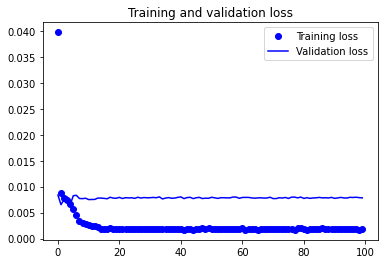

In [19]:
loss = running_loss_history
val_loss = val_running_loss_history

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("plot/train-valid-loss-vresnet-50-scratch.jpg")
plt.show()

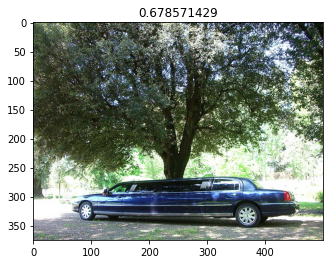

In [20]:
file = ""

def show_sample_from_dataset(i=0):
    global file

    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join(
        "images/"+str(dataset_validation.iloc[i]["image"]))
    file = image_path
    mem_val = os.path.join(
        str(dataset_validation.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_val)

show_sample_from_dataset()

In [21]:
image = None

def image_loader(loader, image_name):
    global image

    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print((resmodel_50_scratch(image_loader(
    data_transforms, file).double().to(device)).cpu().item()))

0.5304327377097985


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_47535/1949985006.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_47535/1949985006.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


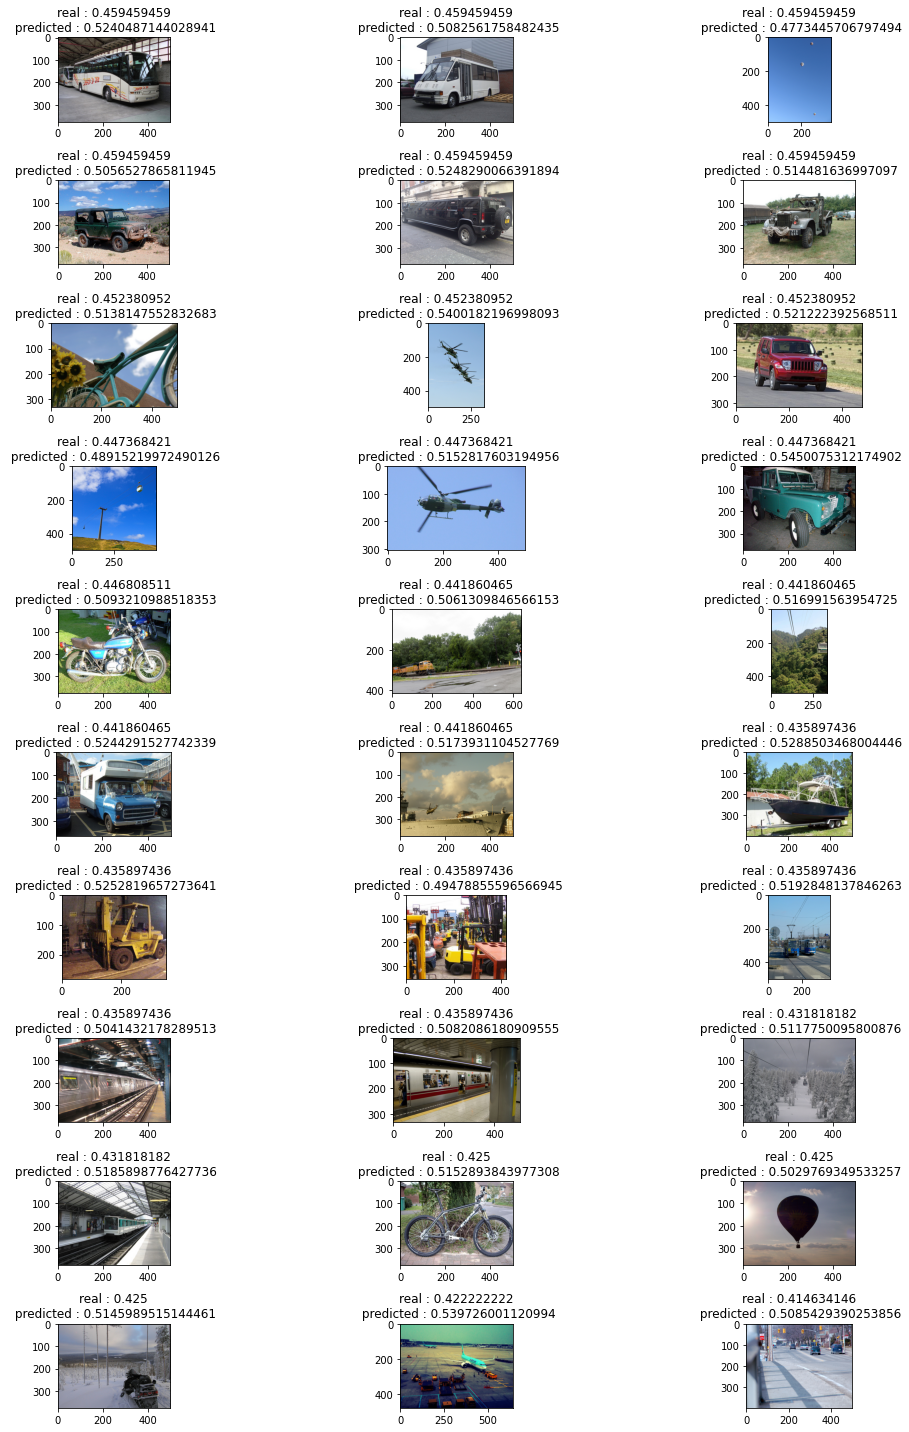

In [22]:
def show_grid(n_row, n_col):
    i = 100
    _, fig = plt.subplots(n_row, n_col, figsize=(20, 20))
    fig = fig.flatten()
    for f in fig:
        #     print(i,f)
        image_path = os.path.join(
            "images/"+str(dataset_validation.iloc[i]["image"]))
        mem_val = os.path.join(
            str(dataset_validation.iloc[i]["memorability_score"]))
        pred = best_model(image_loader(
            data_transforms, image_path).double().to(device)).cpu().item()

        f.imshow(io.imread(image_path))
        plt.tight_layout()
        f.title.set_text("real : " + str(mem_val)+"\n predicted : "+str(pred))
        i = i+1

show_grid(10, 3)

In [23]:
val_running_loss_history

[0.00836997580588305,
 0.006526384277908059,
 0.007521205025023899,
 0.008018214362043186,
 0.00655042349675566,
 0.00825658913361718,
 0.00833333010131802,
 0.0077160031994123555,
 0.007686678135149973,
 0.0077698343157072995,
 0.007507555908110527,
 0.0075257367006549515,
 0.007542672553874459,
 0.007802139690427909,
 0.00779450810131306,
 0.007743852164005256,
 0.007664908983995244,
 0.007954512762150298,
 0.007793397173141505,
 0.00776506640183911,
 0.007932507142198229,
 0.007714409662058036,
 0.007870169155604456,
 0.007827263197570534,
 0.007859130523088113,
 0.007746908945264166,
 0.007958026246636008,
 0.007799813521298723,
 0.007903933936974451,
 0.007850738069248873,
 0.007867679176390434,
 0.007921964647860127,
 0.007863250710319434,
 0.008032092290914524,
 0.007632490003309429,
 0.007791776604935909,
 0.007891583348176386,
 0.007764188326163393,
 0.0077989571121452085,
 0.0079351905433014,
 0.00802171190863804,
 0.007694296967070783,
 0.007891502594068773,
 0.0079476048636

In [24]:
running_loss_history

[0.03977100050556256,
 0.008800149969117236,
 0.0077999317404974676,
 0.007465281039659065,
 0.006598093001484653,
 0.005729341395715573,
 0.004567343942036209,
 0.0034736763495305796,
 0.00304368516207228,
 0.0028057927190802564,
 0.0026118339652784904,
 0.002508478468517293,
 0.002340297568879007,
 0.0021631985135127795,
 0.0018911785906850084,
 0.0018545405664344343,
 0.001898689616472236,
 0.0019470268854429446,
 0.0019085245194756567,
 0.0018822213654480135,
 0.0017581507291929118,
 0.0018592697644371921,
 0.0017578950462793406,
 0.001912173358759097,
 0.0019011453157035208,
 0.0018673879755874956,
 0.0018619015828470148,
 0.0018711275767863888,
 0.00178928696846547,
 0.0018995304004765046,
 0.0017800387716979278,
 0.0018132262704761153,
 0.0017936635116322316,
 0.001776421950717076,
 0.0017476509393444355,
 0.0018503067688701161,
 0.0018736833501945408,
 0.0017979578615894597,
 0.0018173068762027244,
 0.0017542699263119843,
 0.0019128497350121595,
 0.001721372035008031,
 0.001854

In [25]:
resnet

VRNet(
  (stage1_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (stage1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1_maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (stage1_interconv3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (stage1_interpool): AdaptiveAvgPool2d(output_size=64)
  (stage1_intercon1x1): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
  (stage2_convblock): ConvolutionalBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [26]:
predictions = []

for index, row in dataset_validation.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = best_model(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "validation"

    })

for index, row in dataset_train.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = best_model(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "train"

    })

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_47535/1949985006.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


In [27]:
image_list = []
real_list = []
prediction_list = []
image_type_list = []
for p in predictions:
    image_list.append(p["image"])
    real_list.append(p["real"])
    prediction_list.append(p["prediction"])
    image_type_list.append(p["tpye"])

dataframe_dict = {"image": image_list, "real": real_list,
                  "prediction": prediction_list, "tpye": image_type_list}

df = pd.DataFrame(dataframe_dict)

df.to_csv('csv/predictions_vresnet50scratch.csv')